# Background

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

#### Goal(s):

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)
Success Metric(s):
Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.
Bonus(es):
Determine which customers are more likely to be interested in investment products. What makes the customers buy? Tell us which feature we should be focusing more on.

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import plotly.express as px
import plotly.graph_objs as go
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, roc_auc_score, roc_curve, auc, f1_score, recall_score, precision_score, accuracy_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Data

In [2]:
data = pd.read_csv("term-deposit-marketing-2020.csv")

In [3]:
data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no  
3  unknown    5   may        92         1  no  
4  unknown    5   may       198         1  no

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


##### Target Variable

y - has the client subscribed to a term deposit? (binary)

In [5]:
data.describe()

age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000

The months are easy to turn into numerical values, so let's go ahead and change the data types. 

In [6]:
data.month.unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr'], dtype=object)

In [7]:
months_dict = {'jan': 1, 'feb': 2, 'mar' : 3,
              'apr': 4, 'may': 5, 'jun': 6,
              'jul': 7, 'aug': 8, 'sep': 9, 
              'oct': 10, 'nov': 11, 'dec': 12}

In [8]:
data.replace({'month': months_dict}, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  int64 
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(6), object(8)
memory usage: 4.3+ MB


In [10]:
data.describe()

age        balance           day         month      duration  \
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000   
mean      40.544600    1274.277550     16.017225      6.009800    254.824300   
std        9.641776    2903.769716      8.278127      2.301095    259.366498   
min       19.000000   -8019.000000      1.000000      1.000000      0.000000   
25%       33.000000      54.000000      8.000000      5.000000    100.000000   
50%       39.000000     407.000000     17.000000      6.000000    175.000000   
75%       48.000000    1319.000000     21.000000      7.000000    313.000000   
max       95.000000  102127.000000     31.000000     12.000000   4918.000000   

           campaign  
count  40000.000000  
mean       2.882175  
std        3.239051  
min        1.000000  
25%        1.000000  
50%        2.000000  
75%        3.000000  
max       63.000000

#### Missing Data

In [11]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [12]:
data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day  month  duration  campaign   y  
0  unknown    5      5       261         1  no  
1  unknown    5      5       151         1  no  
2  unknown    5      5        76         1  no  
3  unknown    5      5        92         1  no  
4  unknown    5      5       198         1  no

In [13]:
data = data.sample(frac=1)
data.head()

age           job   marital  education default  balance housing loan  \
32971   47   blue-collar  divorced  secondary      no     3823     yes  yes   
1820    47   blue-collar   married    primary      no       94     yes   no   
16869   38  entrepreneur   married    primary      no       21     yes   no   
31489   58    management  divorced   tertiary      no      315     yes   no   
21295   60   blue-collar   married  secondary      no     5450      no   no   

        contact  day  month  duration  campaign   y  
32971  cellular   17      4       647         2  no  
1820    unknown    9      5       209         3  no  
16869  cellular   25      7        65         4  no  
31489  cellular    1      4       121         2  no  
21295  cellular   18      8       113         4  no

# EDA

### Distribution of Data

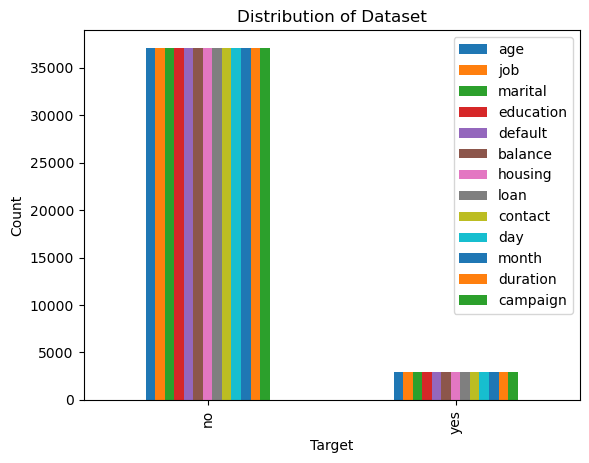

In [14]:
ax = data.groupby('y').count().plot(kind='bar')
plt.title('Distribution of Dataset')
plt.xlabel('Target')
plt.ylabel('Count')
plt.savefig('dist_dataset.png', bbox_inches = 'tight')
plt.show();

We can see the dataset is clearly unbalanced. Let's have a look at the distribution of the two different classes. 

In [15]:
print('Percentage of clients not subscribed: ', (len(data[data['y'] == 'no'])/len(data)*100 ))
print('Percentage of clients subscribed: ', (len(data[data['y'] == 'yes'])/len(data)*100 ))

Percentage of clients not subscribed:  92.75999999999999
Percentage of clients subscribed:  7.24


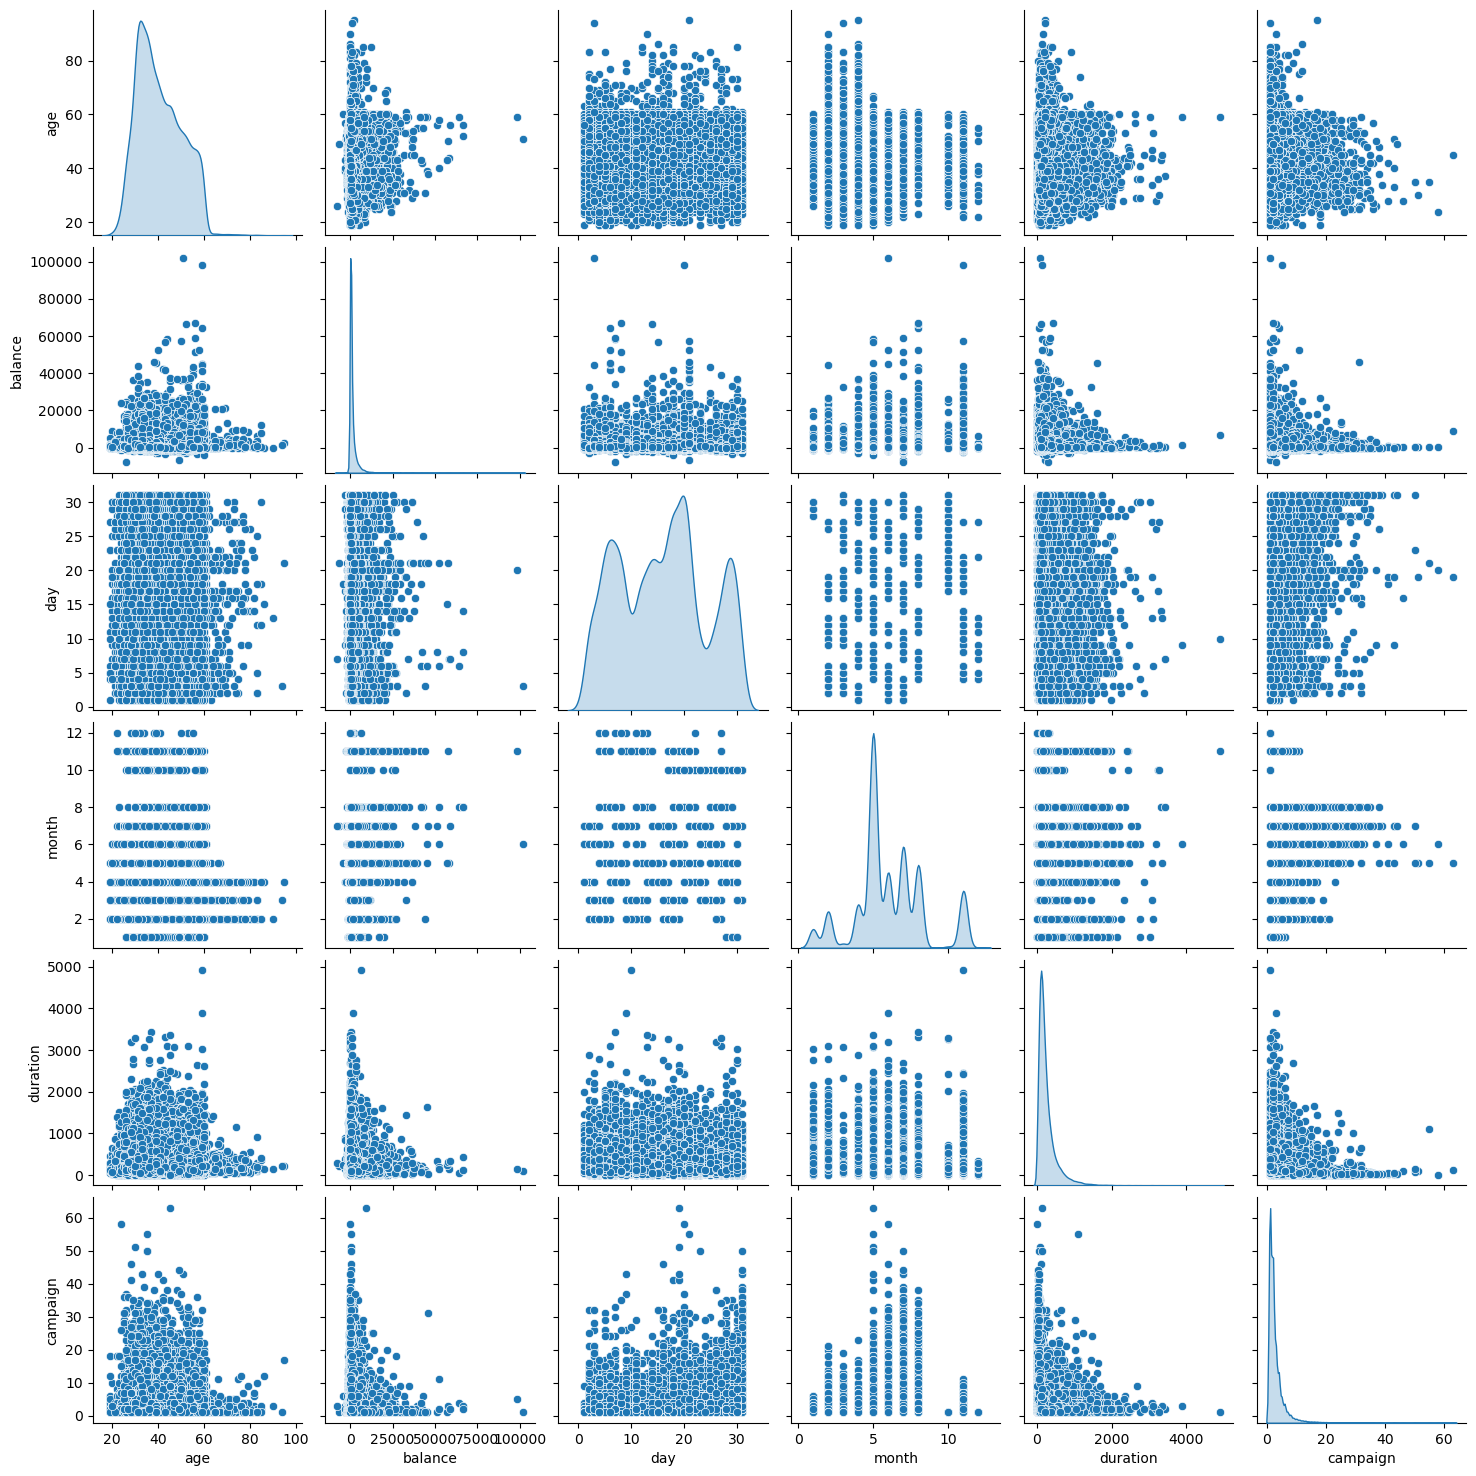

In [16]:
sns.pairplot(data, diag_kind = 'kde')
plt.savefig('pairplot_allfeat.png', bbox_inches = 'tight')
plt.show();

In [17]:
data.skew()

C:\Users\ibane\AppData\Local\Temp\ipykernel_20220\1188251951.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



age         0.436080
balance     8.259236
day         0.067930
month       0.335219
duration    3.165307
campaign    4.730901
dtype: float64

## Customer Profiling
Some of the features in the dataset can be used to categorise cusotmers: age, jobs, martial status, and education

### Age of customer

Type of Data: Numeric (integers)


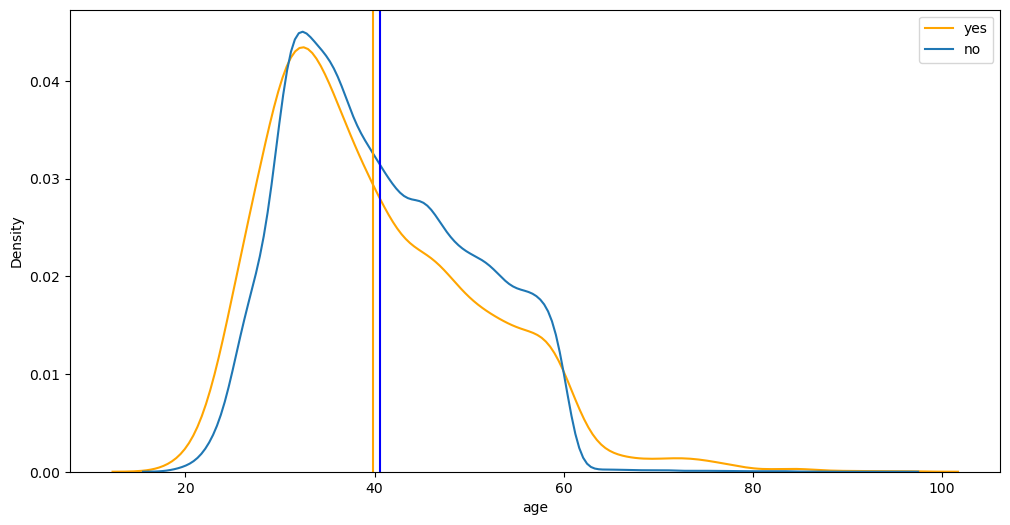

In [18]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.kdeplot(data[data['y']=='yes']['age'], color = 'orange', ax = ax, label = 'yes')
sns.kdeplot(data[data['y']=='no']['age'], ax = ax, label = 'no')
plt.axvline(np.mean((data[data['y']=='yes']['age'])), c = 'orange')
plt.axvline(np.mean((data[data['y']=='no']['age'])), c = 'blue')
ax.legend()
plt.savefig('age.png', bbox_inches = 'tight')
plt.show();

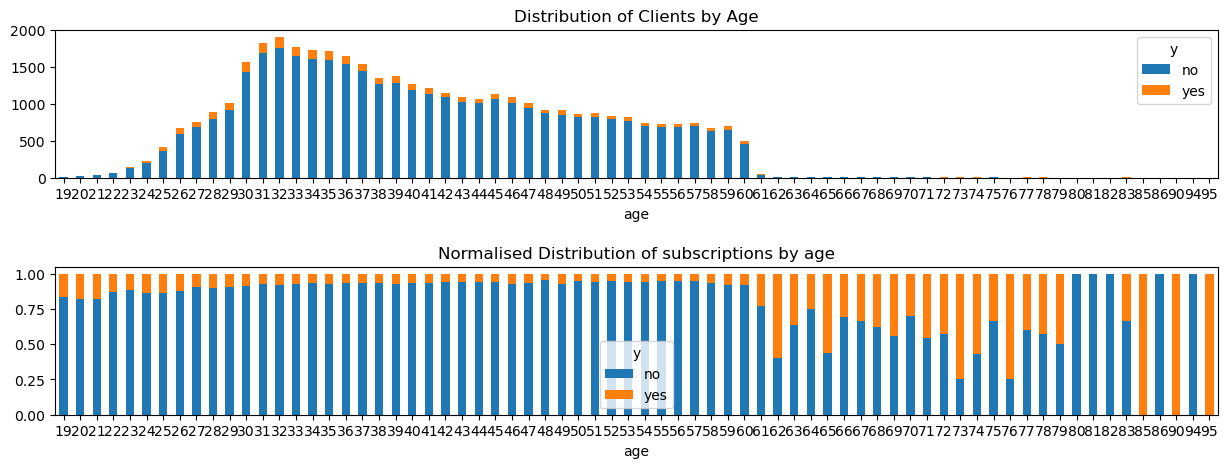

In [19]:
fig, axes = plt.subplots(nrows=2, ncols = 1, figsize = (15,5))
pd.crosstab(data['age'], data['y']).plot(kind='bar', stacked=True, rot=0, ax = axes[0], 
                                         title = 'Distribution of Clients by Age')
data.groupby('age')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 0,
                                                                             title = 'Normalised Distribution of subscriptions by age')
plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.savefig('dist_norm_age.png', bbox_inches = 'tight')
plt.show();

In [20]:
print('No. of clients aged 62: ', data[data['age']==62].size)
print('No of 62 year old clients who subscribed: ',data.query('age==62 & y == "yes"').size)
126/210*100

No. of clients aged 62:  210
No of 62 year old clients who subscribed:  126


60.0

In [21]:
print('No. of clients aged 65: ', data[data['age']==65].size)
print('No of 65 year old clients who subscribed: ',data.query('age==65 & y == "yes"').size)
126/224*100

No. of clients aged 65:  224
No of 65 year old clients who subscribed:  126


56.25

In [22]:
print('No. of clients aged 73: ', data[data['age']==73].size)
print('No of 73 year old clients who subscribed: ',data.query('age==73 & y == "yes"').size)
84/112*100

No. of clients aged 73:  112
No of 73 year old clients who subscribed:  84


75.0

In [23]:
print('No. of clients aged 85: ', data[data['age']==85].size)
print('No of 85 year old clients who subscribed: ',data.query('age==85 & y == "yes"').size)
42/42*100

No. of clients aged 85:  42
No of 85 year old clients who subscribed:  42


100.0

In [24]:
print('No. of clients aged 90: ', data[data['age']==90].size)
print('No of 90 year old clients who subscribed: ',data.query('age==90 & y == "yes"').size)
14/14*100

No. of clients aged 90:  14
No of 90 year old clients who subscribed:  14


100.0

In [25]:
print('No. of clients aged 95: ', data[data['age']==95].size)
print('No of 95 year old clients who subscribed: ',data.query('age==95 & y == "yes"').size)
95/95*100

No. of clients aged 95:  14
No of 95 year old clients who subscribed:  14


100.0

In [26]:
print('No. of clients aged 80: ', data[data['age']==80].size)
print('No of 80 year old clients who subscribed: ',data.query('age==80 & y == "yes"').size)

No. of clients aged 80:  28
No of 80 year old clients who subscribed:  0


In [27]:
print('No. of clients aged 81: ', data[data['age']==81].size)
print('No of 81 year old clients who subscribed: ',data.query('age==81 & y == "yes"').size)

No. of clients aged 81:  14
No of 81 year old clients who subscribed:  0


In [28]:
print('No. of clients aged 82: ', data[data['age']==82].size)
print('No of 82 year old clients who subscribed: ',data.query('age==82 & y == "yes"').size)

No. of clients aged 82:  42
No of 82 year old clients who subscribed:  0


In [29]:
print('No. of clients aged 86: ', data[data['age']==86].size)
print('No of 86 year old clients who subscribed: ',data.query('age==86 & y == "yes"').size)

No. of clients aged 86:  14
No of 86 year old clients who subscribed:  0


In [30]:
print('No. of clients aged 94: ', data[data['age']==94].size)
print('No of 94 year old clients who subscribed: ',data.query('age==94 & y == "yes"').size)

No. of clients aged 94:  14
No of 94 year old clients who subscribed:  0


There're some clear age groups where there is a higher percentage of clients who sign up for term deposits. It's worth noting that customers aged 90 and 95 have exactly the same number of people, all of whom have subscribed for term deposits. This could possibly be spurious or a mere coincidence. For now, there's not sufficient information to suggest these groups out outliers and so I'll leave them in the dataset. 

It's also interesting to note that the dataset has a higher proportion of clients aged between 26 to 60, but the percentage of clients who sign up for term deposits is higher for clients who are older. 

Age groups worth exploring further are 80-82 inclusive, 86 and 94 as these groups exclusively have customers who didn't subscribe for term deposits

In [31]:
print('Age of youngest customer: ', data['age'].min())
print('Age of oldest customer: ',data['age'].max())
print('\n')
print('Age by quartile: \n', data['age'].quantile([0.25, 0.5, 0.75]));

Age of youngest customer:  19
Age of oldest customer:  95


Age by quartile: 
 0.25    33.0
0.50    39.0
0.75    48.0
Name: age, dtype: float64


Age of youngest customer (Yes):  19
Age of oldest customer (Yes):  95


Age by quartile (yes): 
 0.25    31.0
0.50    37.0
0.75    47.0
Name: age, dtype: float64
Age of youngest customer (No):  19
Age of oldest customer (No):  94


Age by quartile:  0.25    33.0
0.50    39.0
0.75    48.0
Name: age, dtype: float64


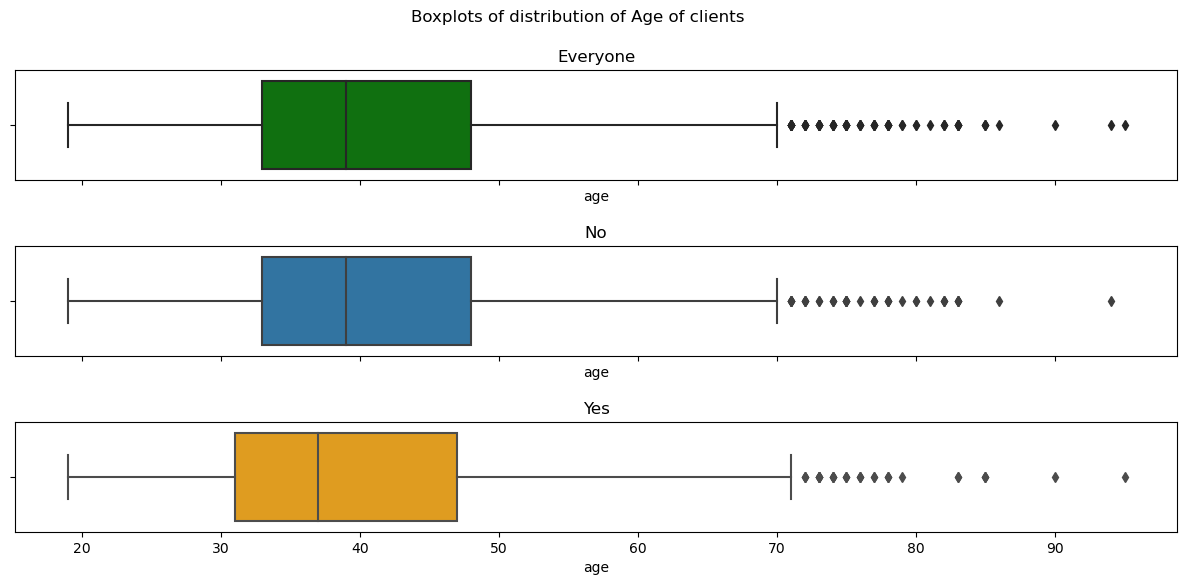

In [32]:
print('Age of youngest customer (Yes): ', data[data['y']=='yes']['age'].min())
print('Age of oldest customer (Yes): ',data[data['y']=='yes']['age'].max())
print('\n')
print('Age by quartile (yes): \n', data[data['y']=='yes']['age'].quantile([0.25, 0.5, 0.75]))
print('Age of youngest customer (No): ', data[data['y']=='no']['age'].min())
print('Age of oldest customer (No): ',data[data['y']=='no']['age'].max())
print('\n')
print('Age by quartile: ', data[data['y']=='no']['age'].quantile([0.25, 0.5, 0.75]))
fig, axes = plt.subplots(3, 1, sharex = True, figsize=(15,6))
fig.suptitle('Boxplots of distribution of Age of clients')
sns.boxplot(ax = axes[0],x='age', data = data, color= 'green')
axes[0].set_title('Everyone')
sns.boxplot(ax = axes[1],x='age', data = data[data['y']=='no'])
axes[1].set_title('No')
sns.boxplot(ax = axes[2], x='age', data = data[data['y']=='yes'], color = 'orange')
axes[2].set_title('Yes')
plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.savefig('boxp_age.png', bbox_inches = 'tight')
plt.show();

The distribution of the age groups of clients in the whole dataset is roughly comparable between those clients who did and didn't subscribe of term deposits. The median is slightly lower for those who with term deposit subscriptions when compared to those clients who didn't register for subscriptions: 37 compared to 39. 

### Jobs

Type of Data: Categorical

In [33]:
data['job'].unique()

array(['blue-collar', 'entrepreneur', 'management', 'services',
       'technician', 'retired', 'self-employed', 'admin', 'unemployed',
       'housemaid', 'unknown', 'student'], dtype=object)

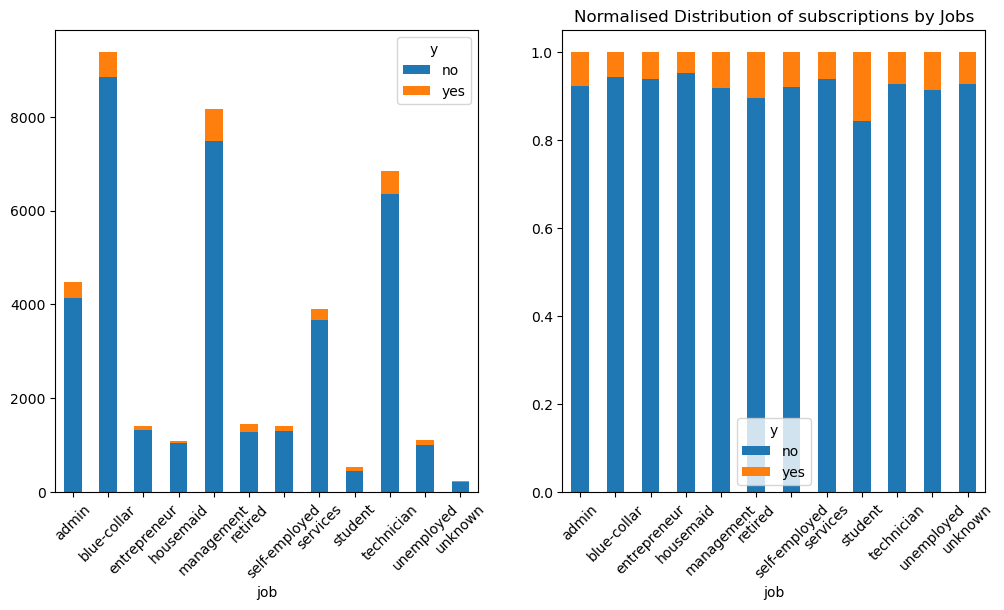

In [34]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['job'], data['y']).plot(kind='bar', stacked=True, ax=axes[0], rot=45)
data.groupby('job')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                             title = 'Normalised Distribution of subscriptions by Jobs')
plt.savefig('dist_norm_job.png', bbox_inches = 'tight')
plt.show();

Count of Clients by Jobs who subscribed for term deposits: 
 management       23.342541
blue-collar      18.473757
technician       17.161602
admin            12.120166
services          8.218232
retired           5.214088
self-employed     3.867403
unemployed        3.314917
entrepreneur      3.038674
student           2.831492
housemaid         1.830110
unknown           0.587017
Name: job, dtype: float64


Count of Clients by Jobs who didn't subscribe for term deposits: 
 blue-collar      23.846486
management       20.186503
technician       17.127533
admin            11.136266
services          9.896507
entrepreneur      3.549483
self-employed     3.509056
retired           3.465934
housemaid         2.786762
unemployed        2.716688
student           1.191246
unknown           0.587538
Name: job, dtype: float64


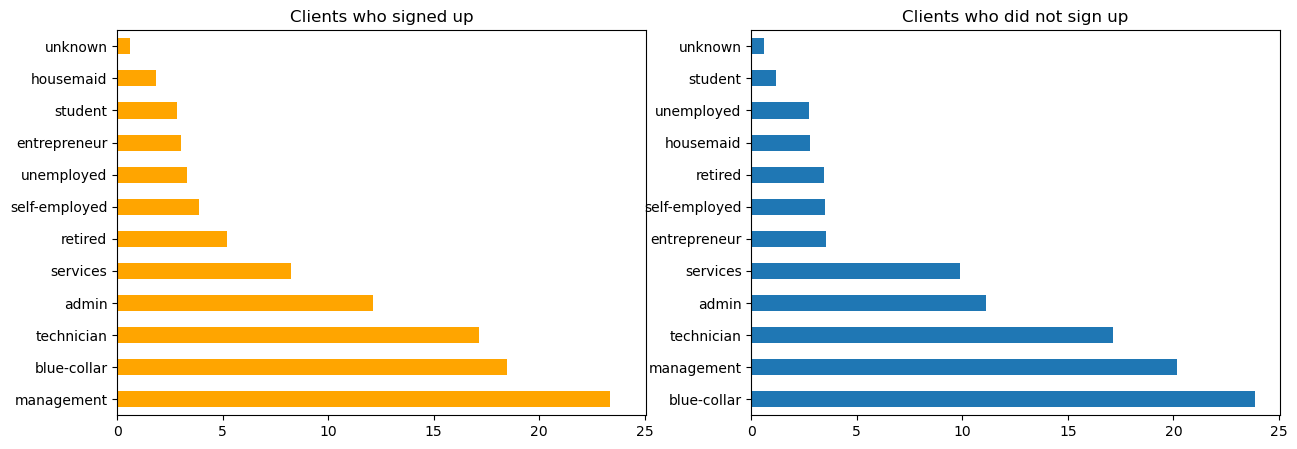

In [35]:
print("Count of Clients by Jobs who subscribed for term deposits: \n",
      (data[data['y']=='yes']['job'].value_counts()/len(data[data['y']=='yes']['job']))*100)
print('\n')
print("Count of Clients by Jobs who didn't subscribe for term deposits: \n",
      (data[data['y']=='no']['job'].value_counts()/len(data[data['y']=='no']['job']))*100)
fig, axes = plt.subplots(1, 2, sharex = True, figsize = (15,5))
((data[data['y']=='yes']['job'].value_counts()/len(data[data['y']=='yes']['job']))*100).plot(ax=axes[0],kind='barh', color = 'orange', 
                                                                                             title = 'Clients who signed up' )
((data[data['y']=='no']['job'].value_counts()/len(data[data['y']=='no']['job']))*100).plot(kind='barh', ax= axes[1], 
                                                                                          title = 'Clients who did not sign up')
plt.savefig('class_job.png', bbox_inches = 'tight')
plt.show();

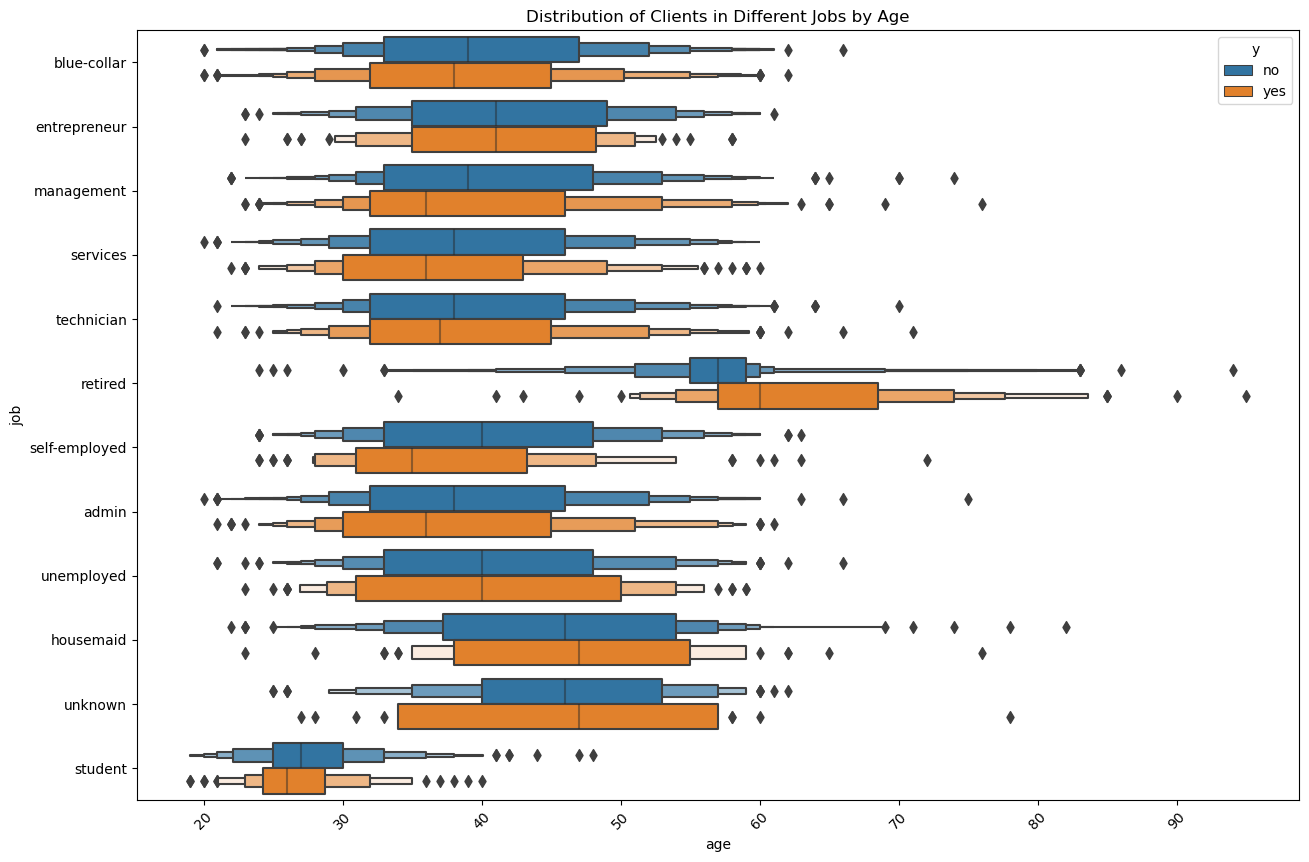

In [36]:
plt.figure(figsize=(15,10))
sns.boxenplot(x='age', y='job', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients in Different Jobs by Age')
plt.savefig('dist_jobs_age.png', bbox_inches = 'tight')
plt.show();

When we group the clients by their jobs and the different ages they fall into we see roughly each profession, students, the unemployed, and those whose employment information is recorded as unknown have very similar distributions. The exceptions are the retired clients where we see the orange boxplot are at a much higher agegroup compared to the blue boxplot. This roughly supports what we saw earlier about the percentage of clients who subscribed for term deposits were of an older agegroup. 

### Marital

Type of Data: Categorical

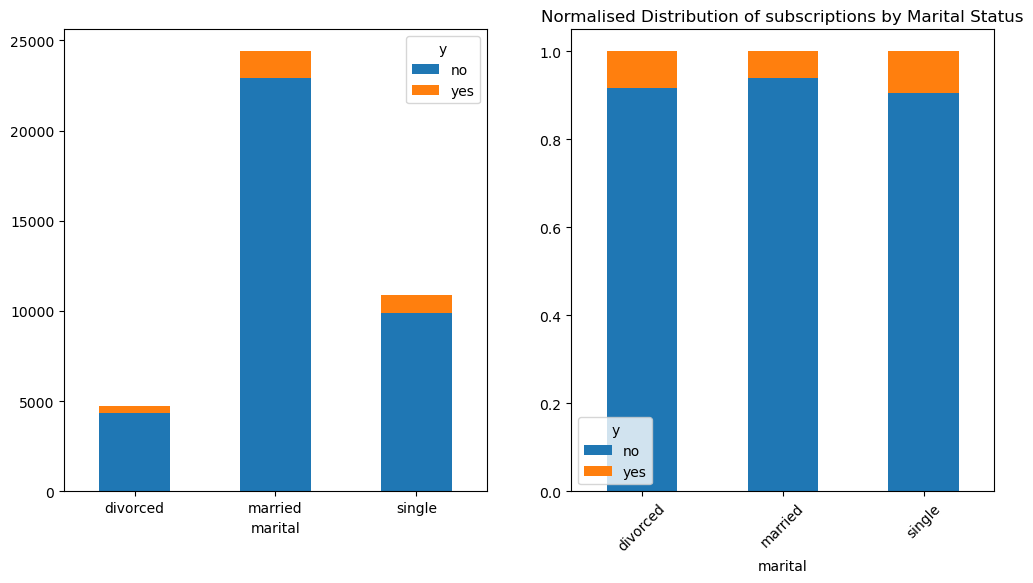

In [37]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['marital'], data['y']).plot(kind='bar', stacked=True, rot=0, ax=axes[0])
data.groupby('marital')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                             title = 'Normalised Distribution of subscriptions by Marital Status')
plt.savefig('dist_norm_marital.png', bbox_inches = 'tight')
plt.show();


Count of Clients by Marital Status who subscribed for term deposits: 
 married     51.035912
single      35.462707
divorced    13.501381
Name: marital, dtype: float64


Count of Clients by Marital Status who didn't subscribe for term deposits: 
 married     61.739974
single      26.579345
divorced    11.680681
Name: marital, dtype: float64


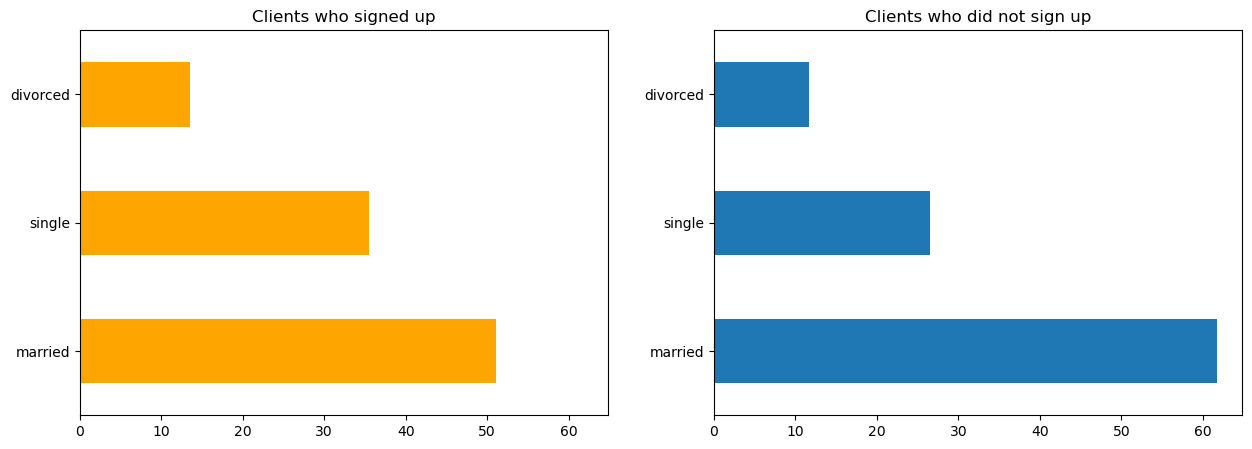

In [38]:
print("Count of Clients by Marital Status who subscribed for term deposits: \n",
      (data[data['y']=='yes']['marital'].value_counts()/len(data[data['y']=='yes']['marital']))*100)
print('\n')
print("Count of Clients by Marital Status who didn't subscribe for term deposits: \n",
      (data[data['y']=='no']['marital'].value_counts()/len(data[data['y']=='no']['marital']))*100)
      

fig, axes = plt.subplots(1, 2, sharex = True, figsize = (15,5))
((data[data['y']=='yes']['marital'].value_counts()/len(data[data['y']=='yes']['marital']))*100).plot(ax = axes[0], kind='barh',
                                                                                                     color = 'orange',
                                                                                                     title = 'Clients who signed up')


((data[data['y']=='no']['marital'].value_counts()/len(data[data['y']=='no']['marital']))*100).plot(ax = axes[1], kind='barh', 
                                                                                                   title = 'Clients who did not sign up')
plt.savefig('dist_marital.png', bbox_inches = 'tight')
plt.show();

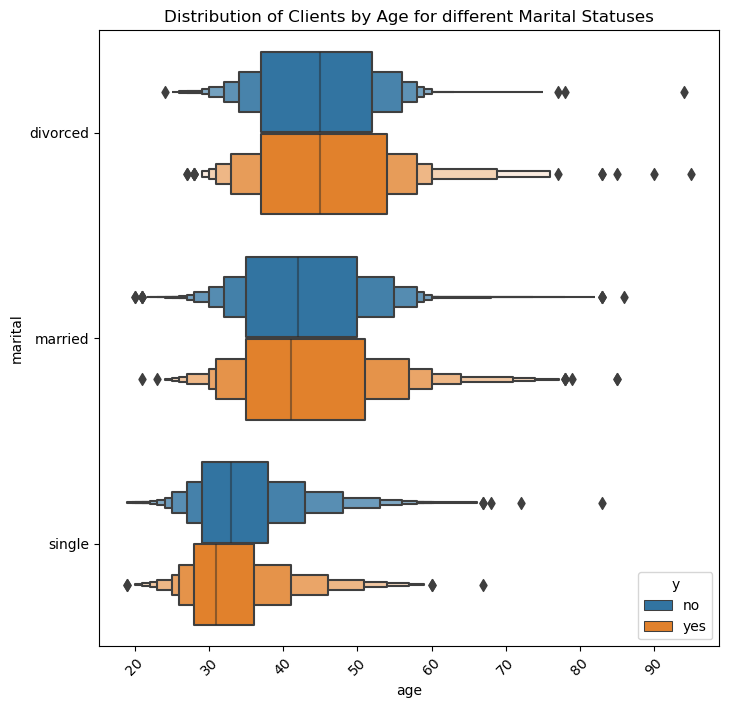

In [39]:
plt.figure(figsize=(8,8))
sns.boxenplot(x='age', y='marital', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Age for different Marital Statuses')
plt.savefig('dist_marital_age.png', bbox_inches = 'tight')
plt.show();

In [40]:
married = data[data['marital']== 'married']
single = data[data['marital']== 'single']
divorced = data[data['marital']== 'divorced']

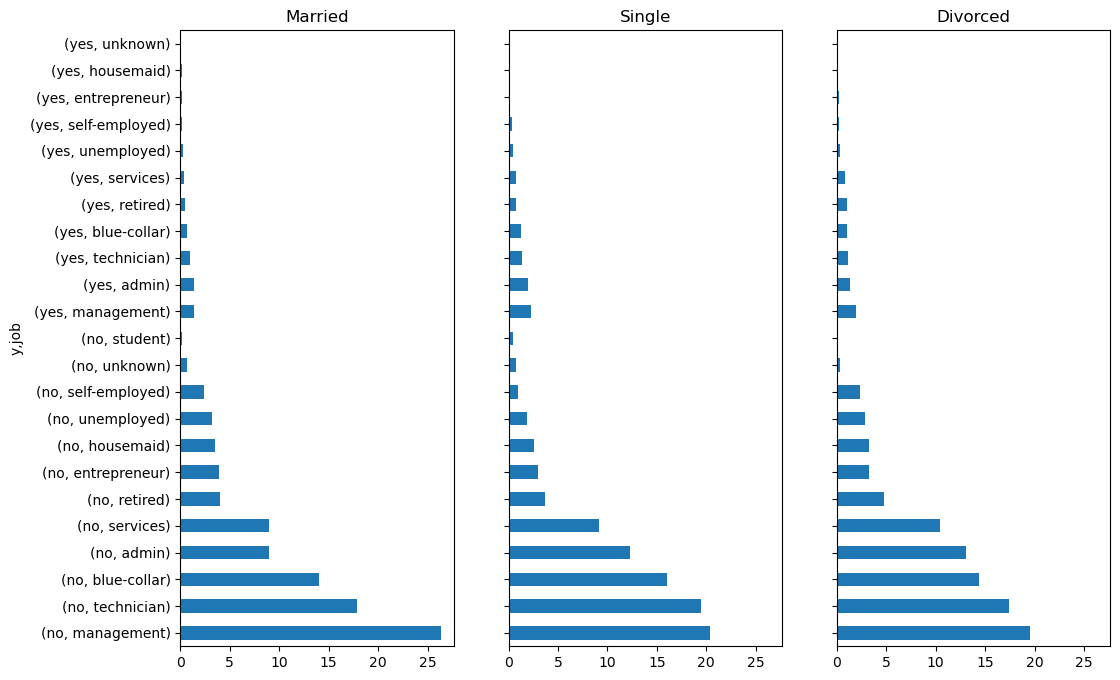

In [41]:
fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (12,8))

(married.groupby('y')['job'].value_counts()/len(married)*100).plot(kind='barh', ax=axes[0],
                                                                            title = 'Married')

(single.groupby('y')['job'].value_counts()/len(single)*100).plot(kind='barh', ax = axes[1], 
                                                                      title = 'Single')

(divorced.groupby('y')['job'].value_counts()/len(divorced)*100).plot(kind='barh', ax = axes[2], 
                                                                      title = 'Divorced')
plt.show();


### Education

Tye of Data: Categorical

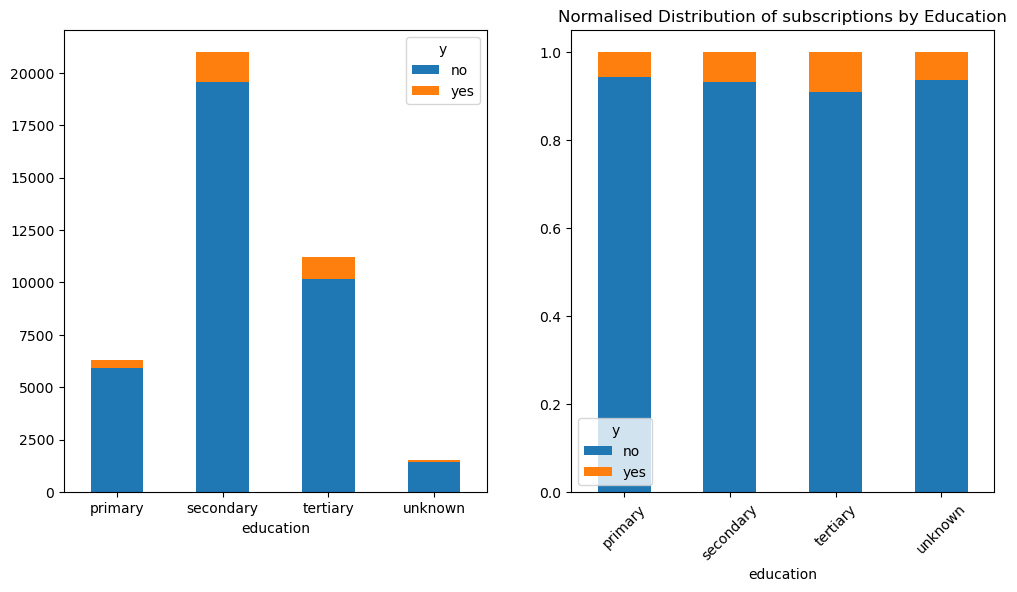

In [42]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['education'], data['y']).plot(ax = axes[0],kind='bar', stacked=True, rot=0)
data.groupby('education')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                             title = 'Normalised Distribution of subscriptions by Education')

plt.savefig('dist_norm_education.png', bbox_inches = 'tight')
plt.show();

It looks like those with tertiary education backgrounds seem to have a higher proportion of subscriptions. 

Count of Clients by Education background who subscribed for term deposits: 
 secondary    48.964088
tertiary     35.531768
primary      12.189227
unknown       3.314917
Name: education, dtype: float64


Count of Clients by Education background who didn't subscribe for term deposits: 
 secondary    52.757115
tertiary     27.428310
primary      15.947068
unknown       3.867508
Name: education, dtype: float64


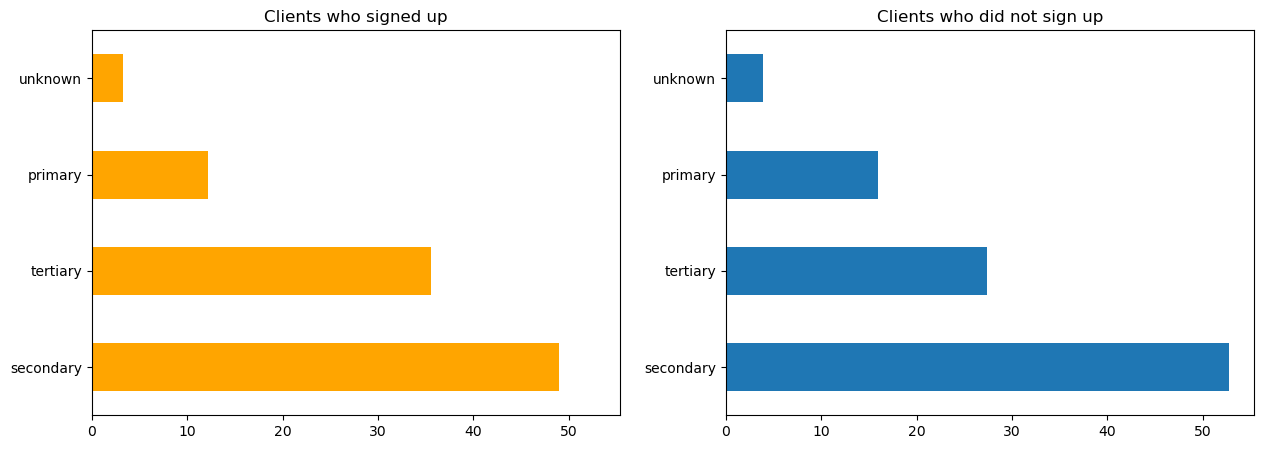

In [43]:
print("Count of Clients by Education background who subscribed for term deposits: \n",
      (data[data['y']=='yes']['education'].value_counts()/len(data[data['y']=='yes']['education']))*100)
print('\n')
print("Count of Clients by Education background who didn't subscribe for term deposits: \n",
      (data[data['y']=='no']['education'].value_counts()/len(data[data['y']=='no']['education']))*100)
      

fig, axes = plt.subplots(1, 2, sharex = True, figsize = (15,5))
((data[data['y']=='yes']['education'].value_counts()/len(data[data['y']=='yes']['education']))*100).plot(ax = axes[0], kind='barh',
                                                                                                     color = 'orange',
                                                                                                     title = 'Clients who signed up')


((data[data['y']=='no']['education'].value_counts()/len(data[data['y']=='no']['education']))*100).plot(ax = axes[1], kind='barh', 
                                                                                                   title = 'Clients who did not sign up')
plt.savefig('class_marital.png', bbox_inches = 'tight')
plt.show();


We see a very similar distribution between clients who did sign up and those who didn't for term deposits. however, it's very obvious that those with a tertiary background is a larger group with subscriptions when compared to those who don't have subscriptions to term deposits. 

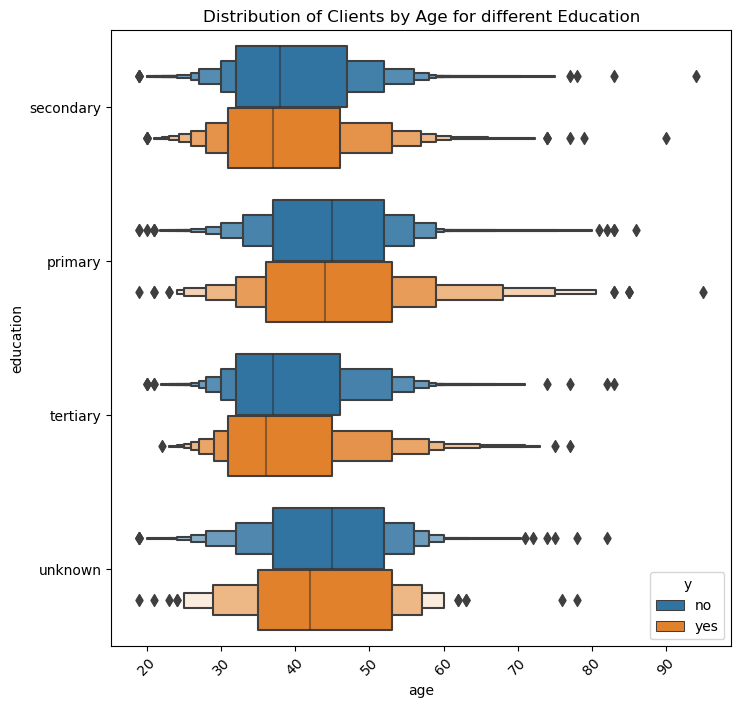

In [44]:
plt.figure(figsize=(8,8))
sns.boxenplot(x='age', y='education', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Age for different Education')
plt.savefig('dist_education_age.png', bbox_inches = 'tight')
plt.show();

We see rougly the same distribution in ages between the different education groups. 

In [45]:
crosstable = pd.crosstab(data['education'], data['marital'])
crosstable = pd.DataFrame(crosstable)
crosstable

marital    divorced  married  single
education                           
primary         652     4836     782
secondary      2614    12560    5819
tertiary       1317     5999    3890
unknown         142      991     398

In [46]:
column_names = list(crosstable.columns)
data_names = list(data.columns)

<Figure size 2000x2000 with 0 Axes>

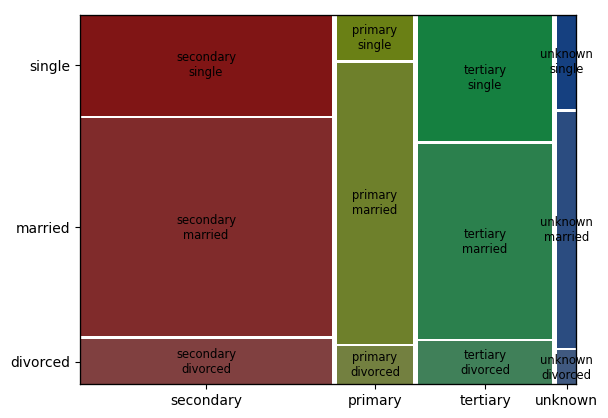

In [47]:
plt.figure(figsize = (20,20))
props = {}
props[(column_names[1], str(crosstable.index[1]))] = {'facecolor': 'red', 'edgecolor': 'white'}
props[(column_names[1], str(crosstable.index[0]))] = {'facecolor': 'yellow', 'edgecolor': 'white'}
props[(column_names[1], str(crosstable.index[2]))] = {'facecolor': 'blue', 'edgecolor': 'white'}
props[(column_names[0], str(crosstable.index[2]))] = {'facecolor': 'green', 'edgecolor': 'white'}
props[(column_names[0], str(crosstable.index[1]))] = {'facecolor': 'orange', 'edgecolor': 'white'}
props[(column_names[0], str(crosstable.index[0]))] = {'facecolor': 'brown', 'edgecolor': 'white'}
props[(column_names[2], str(crosstable.index[0]))] = {'facecolor': 'purple', 'edgecolor': 'white'}
props[(column_names[2], str(crosstable.index[1]))] = {'facecolor': 'cyan', 'edgecolor': 'white'}
props[(column_names[2], str(crosstable.index[2]))] = {'facecolor': 'gray', 'edgecolor': 'white'}
mosaic(data, [data_names[3], data_names[2]], properties = props, gap=0.01 )
plt.show();

## Financial Profile
Some of the features can be used to group customers according to known financial information. For example, we can try to group customers based on their balance, previous borrowing history such as whether they have default on loans, if they have housing and personal loans. 
### Default

Type of Data: Binary where 'yes' indicates the customer defaulted on a loan

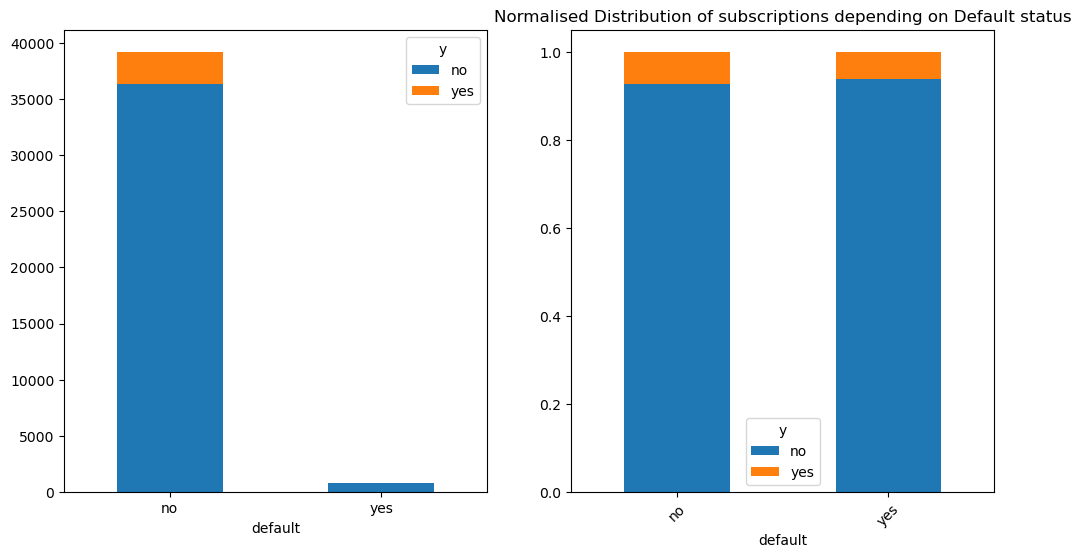

In [48]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['default'], data['y']).plot(ax = axes[0],kind='bar', stacked=True, rot=0)
data.groupby('default')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                                  title = 'Normalised Distribution of subscriptions depending on Default status')
plt.show();

In [49]:
default_cust = data[data['default']=='yes']
default_cust.describe()

age       balance         day       month     duration  \
count  809.000000    809.000000  809.000000  809.000000   809.000000   
mean    39.547590   -141.856613   16.379481    6.401731   239.304079   
std      9.286849    907.028464    8.570940    2.171610   214.758670   
min     21.000000  -8019.000000    1.000000    1.000000     3.000000   
25%     32.000000   -344.000000    8.000000    5.000000    97.000000   
50%     38.000000     -7.000000   17.000000    6.000000   172.000000   
75%     47.000000     13.000000   23.000000    7.000000   305.000000   
max     60.000000  16486.000000   31.000000   11.000000  1558.000000   

         campaign  
count  809.000000  
mean     3.155748  
std      3.637738  
min      1.000000  
25%      1.000000  
50%      2.000000  
75%      4.000000  
max     36.000000

In [50]:
rest_cust = data[data['default']=='no']
rest_cust.describe()

age        balance           day         month      duration  \
count  39191.000000   39191.000000  39191.000000  39191.000000  39191.000000   
mean      40.565181    1303.510092     16.009747      6.001710    255.144676   
std        9.647993    2923.477921      8.271920      2.303014    260.199300   
min       19.000000   -4057.000000      1.000000      1.000000      0.000000   
25%       33.000000      67.000000      8.000000      5.000000    100.000000   
50%       39.000000     425.000000     16.000000      5.000000    175.000000   
75%       48.000000    1348.000000     21.000000      7.000000    313.000000   
max       95.000000  102127.000000     31.000000     12.000000   4918.000000   

           campaign  
count  39191.000000  
mean       2.876528  
std        3.230111  
min        1.000000  
25%        1.000000  
50%        2.000000  
75%        3.000000  
max       63.000000

In [51]:
print('Percentage of customers who default on loans and are either on 0 balance or overdrawn: ', len(default_cust[default_cust['balance']<=0])/len(default_cust) *100)
print('Percentage of customers who do not default on loans, but are on 0 balance or overdrawn: ', len(rest_cust[rest_cust['balance']<=0])/len(rest_cust) *100)

Percentage of customers who default on loans and are either on 0 balance or overdrawn:  68.60321384425217
Percentage of customers who do not default on loans, but are on 0 balance or overdrawn:  16.29200581766222


In [52]:
len(rest_cust[rest_cust['age']>=60])/len(rest_cust)*100

1.8371564900104616

Distribution of customers who have defaulted on loans by edcuation:
 y    education
no   secondary    53.028430
     tertiary     22.620519
     primary      14.833127
     unknown       3.461063
yes  secondary     3.461063
     tertiary      1.483313
     primary       0.618047
     unknown       0.494438
Name: education, dtype: float64


Distribution of customers who have not defaulted on loans by edcuation:
 y    education
no   secondary    48.853053
     tertiary     25.500753
     primary      14.791661
     unknown       3.590110
yes  secondary     3.546733
     tertiary      2.594984
     primary       0.887959
     unknown       0.234748
Name: education, dtype: float64


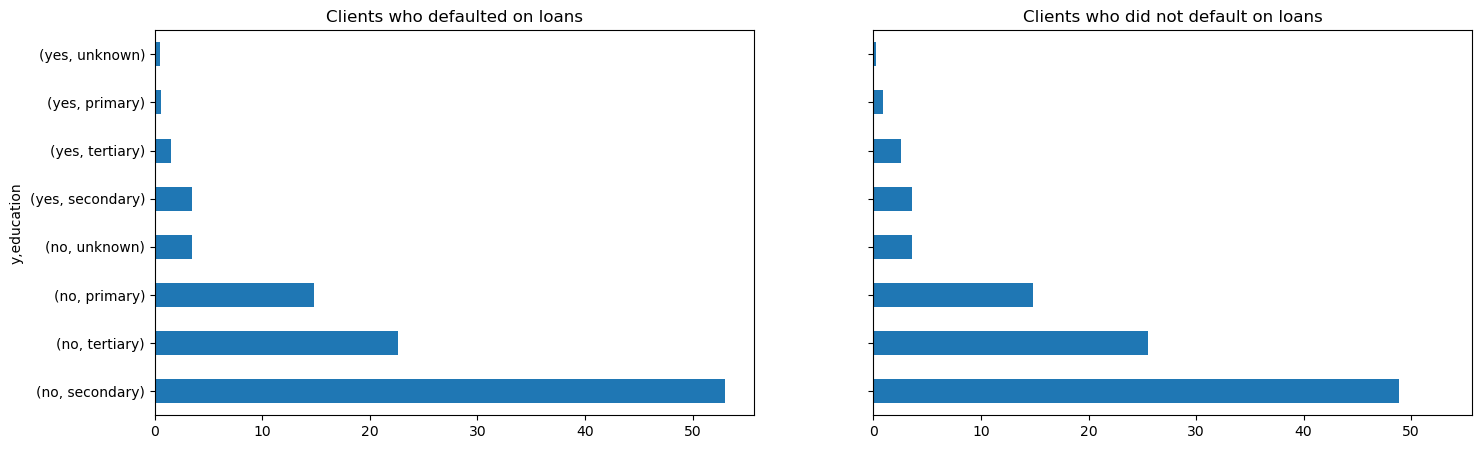

In [53]:
print('Distribution of customers who have defaulted on loans by edcuation:\n' , default_cust.groupby('y')['education'].value_counts()/len(default_cust)*100)
print('\n')
print('Distribution of customers who have not defaulted on loans by edcuation:\n' , rest_cust.groupby('y')['education'].value_counts()/len(rest_cust)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))

(default_cust.groupby('y')['education'].value_counts()/len(default_cust)*100).plot(kind='barh', ax=axes[0], title = 'Clients who defaulted on loans')

(rest_cust.groupby('y')['education'].value_counts()/len(rest_cust)*100).plot(kind='barh', ax=axes[1],
                                                                            title= 'Clients who did not default on loans')
plt.show();

Distribution of customers who have defaulted on loans segmented by jobs:
 y    job          
no   blue-collar      22.991347
     management       19.283066
     technician       14.709518
     admin             8.776267
     services          8.652658
     entrepreneur      6.056860
     self-employed     3.831891
     unemployed        3.461063
     retired           3.090235
     housemaid         2.595797
     student           0.247219
     unknown           0.247219
yes  blue-collar       1.854141
     technician        1.236094
     management        0.865266
     entrepreneur      0.741656
     services          0.494438
     admin             0.370828
     self-employed     0.247219
     housemaid         0.123609
     unemployed        0.123609
Name: job, dtype: float64


Distribution of customers who have not defaulted on loans segmented by jobs:
 y    job          
no   blue-collar      22.102013
     management       18.713480
     technician       15.911816
     admin    

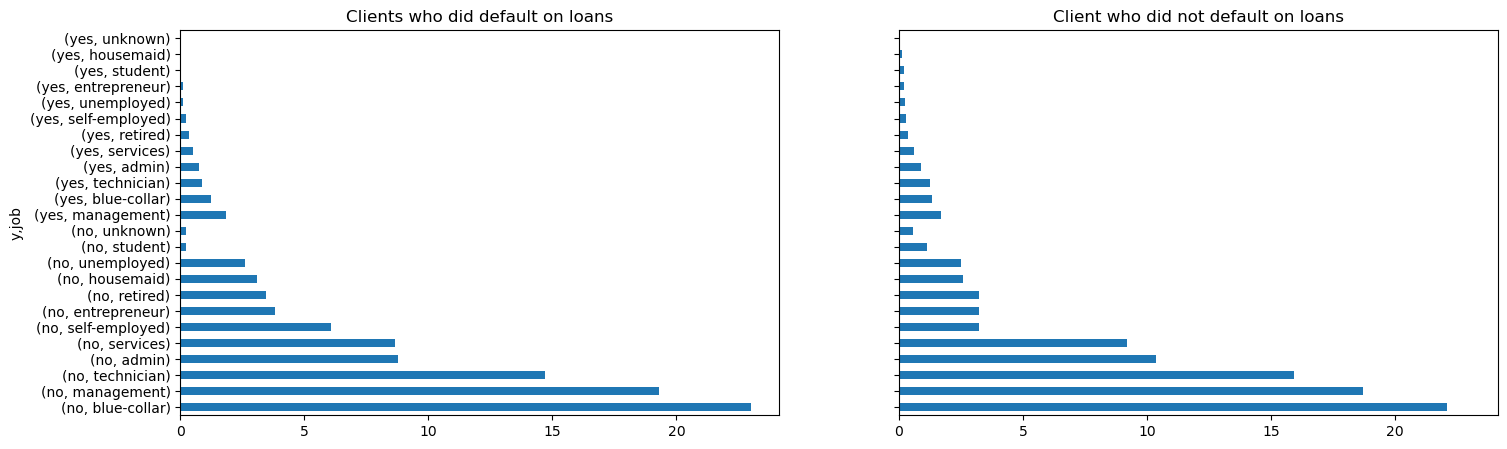

In [54]:
print('Distribution of customers who have defaulted on loans segmented by jobs:\n' , default_cust.groupby('y')['job'].value_counts()/len(default_cust)*100)
print('\n')
print('Distribution of customers who have not defaulted on loans segmented by jobs:\n' , rest_cust.groupby('y')['job'].value_counts()/len(rest_cust)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))

(default_cust.groupby('y')['job'].value_counts()/len(default_cust)*100).plot(kind='barh', ax=axes[0],
                                                                            title = 'Clients who did default on loans')

(rest_cust.groupby('y')['job'].value_counts()/len(rest_cust)*100).plot(kind='barh', ax = axes[1], 
                                                                      title = 'Client who did not default on loans')
plt.show();


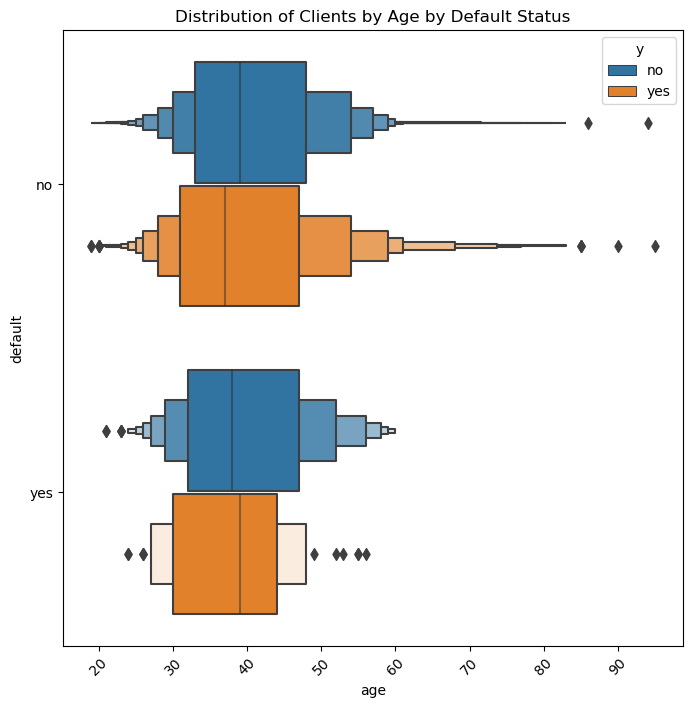

In [55]:
plt.figure(figsize=(8,8))
sns.boxenplot(x='age', y='default', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Age by Default Status')
plt.show();

As we would expect, those who have previously defaulted on loans mostly didn't sign up for term deposits. Those with secondary level education are the largest group of those who took out loans, again forming the largest segmentation of customers who did default on loans and had signed up for term deposits. This doensn't necessarily mean that secondary education is what we should look for when trying to determine which customers to target and could be just a consequence of the inblanaced dataset. 

### Average Yearly Balance (Euros)

Type of Data: Numeric (integer)


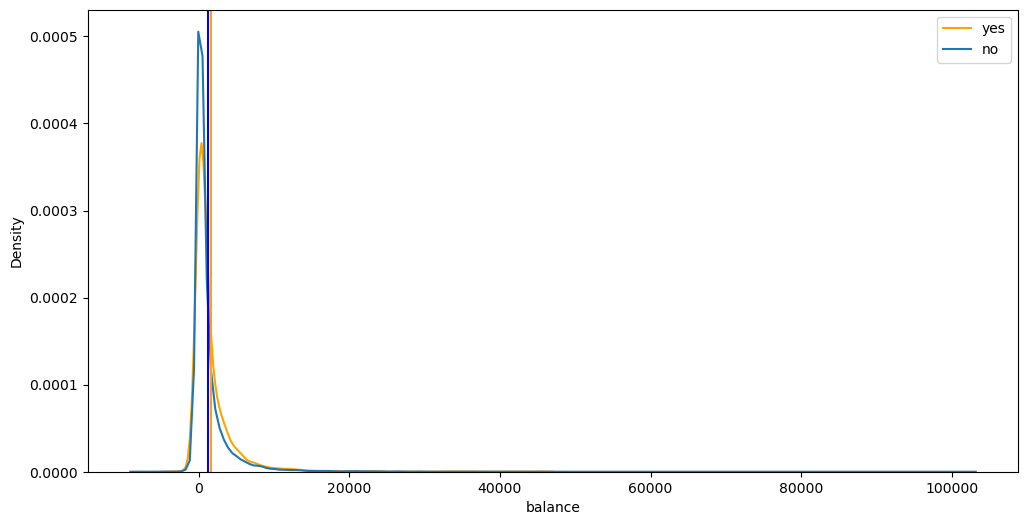

In [56]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.kdeplot(data[data['y']=='yes']['balance'], color = 'orange', ax = ax, label = 'yes')
sns.kdeplot(data[data['y']=='no']['balance'], ax = ax, label = 'no')
plt.axvline(np.mean((data[data['y']=='yes']['balance'])), c = 'orange')
plt.axvline(np.mean((data[data['y']=='no']['balance'])), c = 'blue')
ax.legend()
plt.show();

In [57]:
np.min(data['balance'])

-8019

In [58]:
print('Number of customers who have 0 or negative balance: ', len(data[data['balance']<=0]))
print('Percentage of the whole dataset who are overdrawn or on 0 balance: ',len(data[data['balance']<=0])/len(data)*100)

Number of customers who have 0 or negative balance:  6940
Percentage of the whole dataset who are overdrawn or on 0 balance:  17.349999999999998


In [59]:
overdrawn_customers = data[data['balance']<=0]
overdrawn_customers.head()

age          job  marital  education default  balance housing loan  \
4571    29     services   single  secondary      no        0     yes   no   
3927    40     services   single  secondary      no      -61     yes  yes   
2114    54        admin  married    unknown      no     -337     yes   no   
6728    46  blue-collar  married    unknown      no     -619     yes   no   
15555   37   technician  married   tertiary      no      -86     yes   no   

        contact  day  month  duration  campaign   y  
4571    unknown   20      5       227         9  no  
3927    unknown   16      5       698         9  no  
2114    unknown   12      5       288         2  no  
6728    unknown   28      5        96         1  no  
15555  cellular   21      7        91         4  no

In [60]:
incredit_customers = data[data['balance']>0]
incredit_customers.head()

age           job   marital  education default  balance housing loan  \
32971   47   blue-collar  divorced  secondary      no     3823     yes  yes   
1820    47   blue-collar   married    primary      no       94     yes   no   
16869   38  entrepreneur   married    primary      no       21     yes   no   
31489   58    management  divorced   tertiary      no      315     yes   no   
21295   60   blue-collar   married  secondary      no     5450      no   no   

        contact  day  month  duration  campaign   y  
32971  cellular   17      4       647         2  no  
1820    unknown    9      5       209         3  no  
16869  cellular   25      7        65         4  no  
31489  cellular    1      4       121         2  no  
21295  cellular   18      8       113         4  no

Percentage of Customers who have 0 balance or are overdrawn:  no     94.582133
yes     5.417867
Name: y, dtype: float64


Percentage of Customers who have more than 0 balance:  no     92.377495
yes     7.622505
Name: y, dtype: float64


<AxesSubplot:title={'center':'Clients with balance more than 0'}>

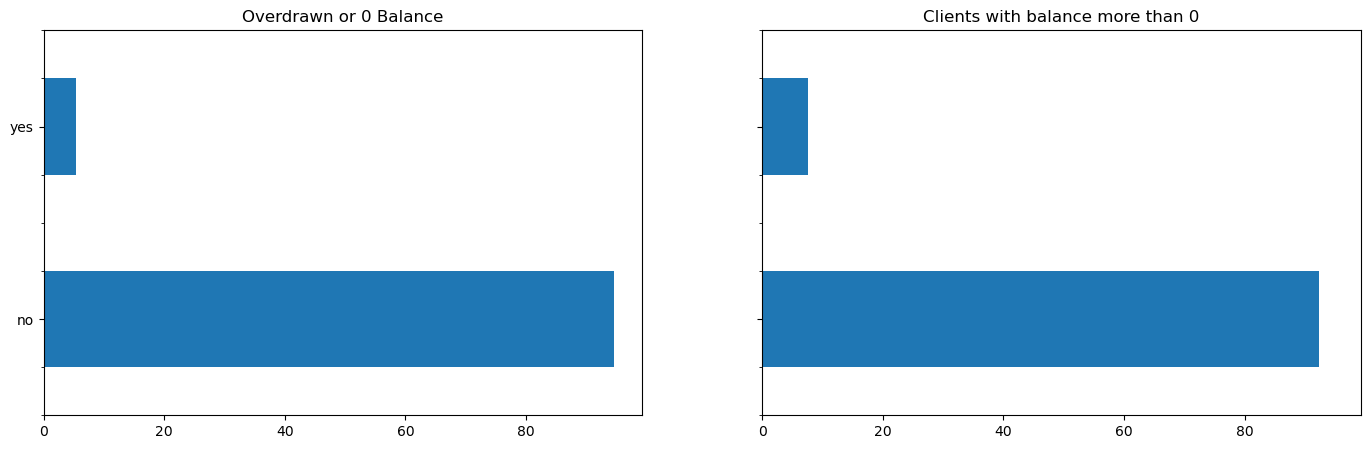

In [61]:
print('Percentage of Customers who have 0 balance or are overdrawn: ', overdrawn_customers['y'].value_counts()/len(overdrawn_customers)*100)
print('\n')
print('Percentage of Customers who have more than 0 balance: ',incredit_customers['y'].value_counts()/len(incredit_customers)*100)

fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))

(overdrawn_customers['y'].value_counts()/len(overdrawn_customers)*100).plot(ax = axes[0], 
                                                                            title= 'Overdrawn or 0 Balance',
                                                                            kind='barh')


(incredit_customers['y'].value_counts()/len(incredit_customers)*100).plot(ax = axes[1],
                                                                          title = "Clients with balance more than 0",
                                                                          kind='barh')

In [62]:
overdrawn_customers.describe()

age      balance          day        month     duration  \
count  6940.000000  6940.000000  6940.000000  6940.000000  6940.000000   
mean     40.302882  -171.647983    16.471182     6.101441   247.664265   
std       9.287698   314.382683     8.474296     2.044419   246.987243   
min      19.000000 -8019.000000     1.000000     1.000000     3.000000   
25%      33.000000  -254.000000     9.000000     5.000000   100.000000   
50%      39.000000   -17.000000    17.000000     6.000000   172.000000   
75%      47.000000     0.000000    23.000000     7.000000   304.000000   
max      86.000000     0.000000    31.000000    12.000000  3253.000000   

          campaign  
count  6940.000000  
mean      3.054035  
std       3.671885  
min       1.000000  
25%       1.000000  
50%       2.000000  
75%       3.000000  
max      43.000000

In [63]:
incredit_customers.describe()

age        balance           day         month      duration  \
count  33060.000000   33060.000000  33060.000000  33060.000000  33060.000000   
mean      40.595342    1577.808197     15.921930      5.990563    256.327344   
std        9.713838    3106.475225      8.233306      2.350996    261.869606   
min       19.000000       1.000000      1.000000      1.000000      0.000000   
25%       33.000000     214.000000      8.000000      5.000000     99.000000   
50%       39.000000     606.000000     16.000000      5.000000    176.000000   
75%       48.000000    1650.250000     21.000000      7.000000    315.000000   
max       95.000000  102127.000000     31.000000     12.000000   4918.000000   

           campaign  
count  33060.000000  
mean       2.846098  
std        3.139491  
min        1.000000  
25%        1.000000  
50%        2.000000  
75%        3.000000  
max       63.000000

Distribution of overdrawn customers by edcuation:
 y    education
no   secondary    53.011527
     tertiary     22.853026
     primary      15.201729
     unknown       3.515850
yes  secondary     2.881844
     tertiary      1.700288
     primary       0.749280
     unknown       0.086455
Name: education, dtype: float64
Distribution of incredit customers by edcuation:
 y    education
no   secondary    48.082275
     tertiary     25.986086
     primary      14.706594
     unknown       3.602541
yes  secondary     3.684211
     tertiary      2.755596
     primary       0.910466
     unknown       0.272232
Name: education, dtype: float64


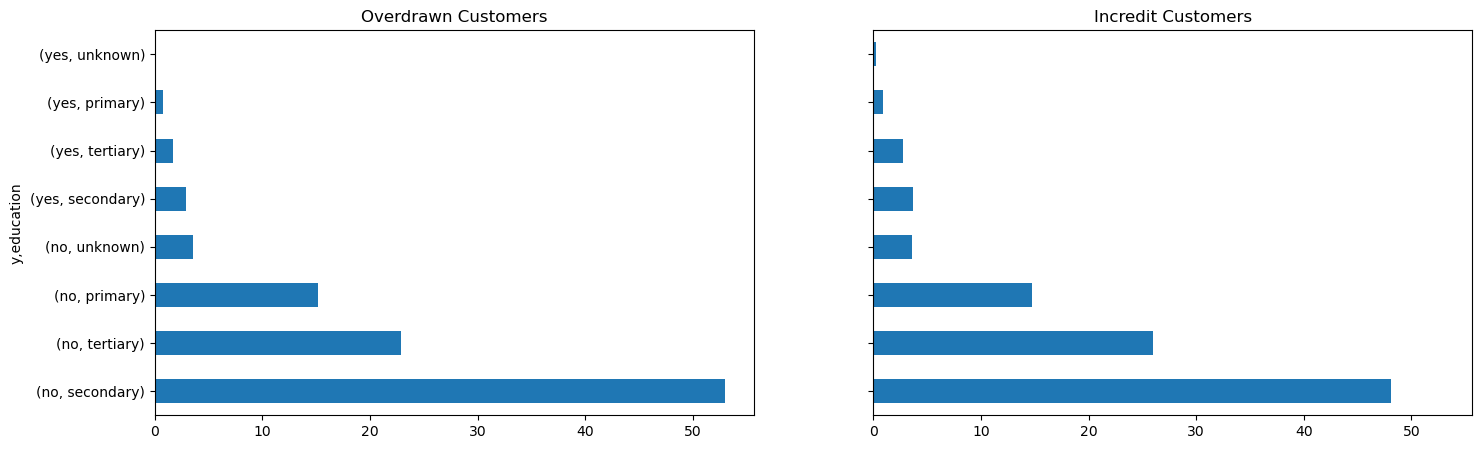

In [64]:
print('Distribution of overdrawn customers by edcuation:\n' , overdrawn_customers.groupby('y')['education'].value_counts()/len(overdrawn_customers)*100)
print('Distribution of incredit customers by edcuation:\n' , incredit_customers.groupby('y')['education'].value_counts()/len(incredit_customers)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))
(overdrawn_customers.groupby('y')['education'].value_counts()/len(overdrawn_customers)*100).plot(ax = axes[0],kind='barh', 
                                                                                 title= 'Overdrawn Customers')
(incredit_customers.groupby('y')['education'].value_counts()/len(incredit_customers)*100).plot(kind='barh', ax=axes[1], 
                                                                              title = 'Incredit Customers')
plt.show();

Distribution of overdrawn customers by employment:
 y    job          
no   blue-collar      23.371758
     management       18.198847
     technician       16.469741
     admin            10.936599
     services         10.619597
     entrepreneur      3.429395
     retired           3.097983
     self-employed     2.766571
     housemaid         2.449568
     unemployed        2.319885
     student           0.533141
     unknown           0.389049
yes  blue-collar       1.167147
     management        0.951009
     technician        0.907781
     services          0.691643
     admin             0.662824
     entrepreneur      0.331412
     self-employed     0.201729
     retired           0.187320
     unemployed        0.129683
     student           0.086455
     housemaid         0.072046
     unknown           0.028818
Name: job, dtype: float64


Distribution of incredit customers by employment:
 y    job          
no   blue-collar      21.857229
     management       18.835451

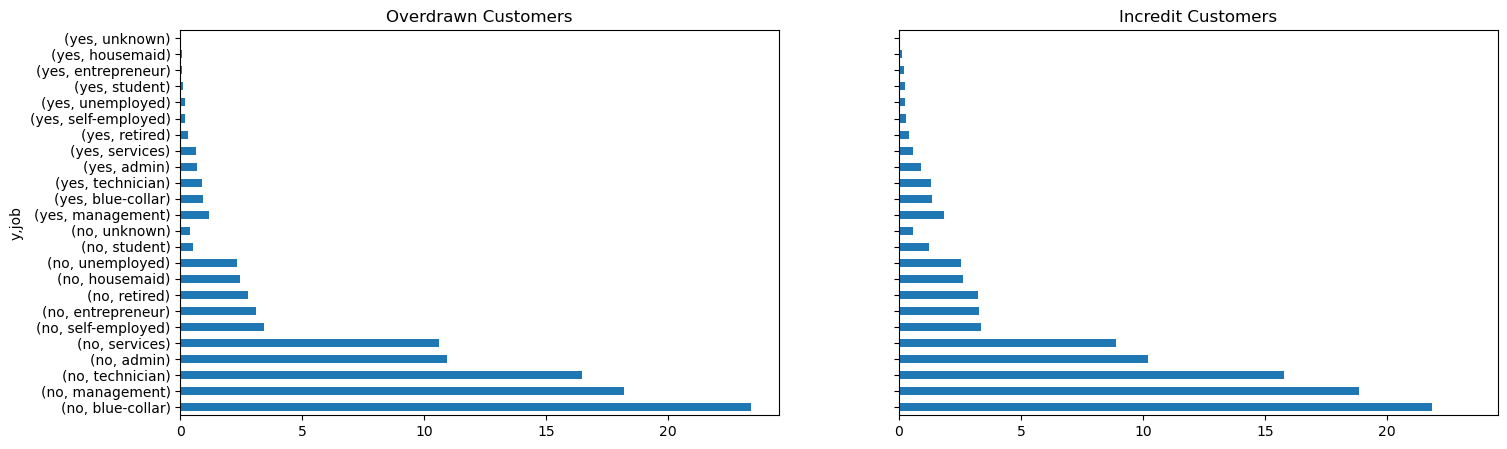

In [65]:
print('Distribution of overdrawn customers by employment:\n' , overdrawn_customers.groupby('y')['job'].value_counts()/len(overdrawn_customers)*100)
print('\n')
print('Distribution of incredit customers by employment:\n' , incredit_customers.groupby('y')['job'].value_counts()/len(incredit_customers)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))
(overdrawn_customers.groupby('y')['job'].value_counts()/len(overdrawn_customers)*100).plot(ax=axes[0],kind='barh', 
                                                                                          title = 'Overdrawn Customers')
(incredit_customers.groupby('y')['job'].value_counts()/len(incredit_customers)*100).plot(kind='barh', stacked=True, ax=axes[1], 
                                                                                        title = 'Incredit Customers')
plt.show();

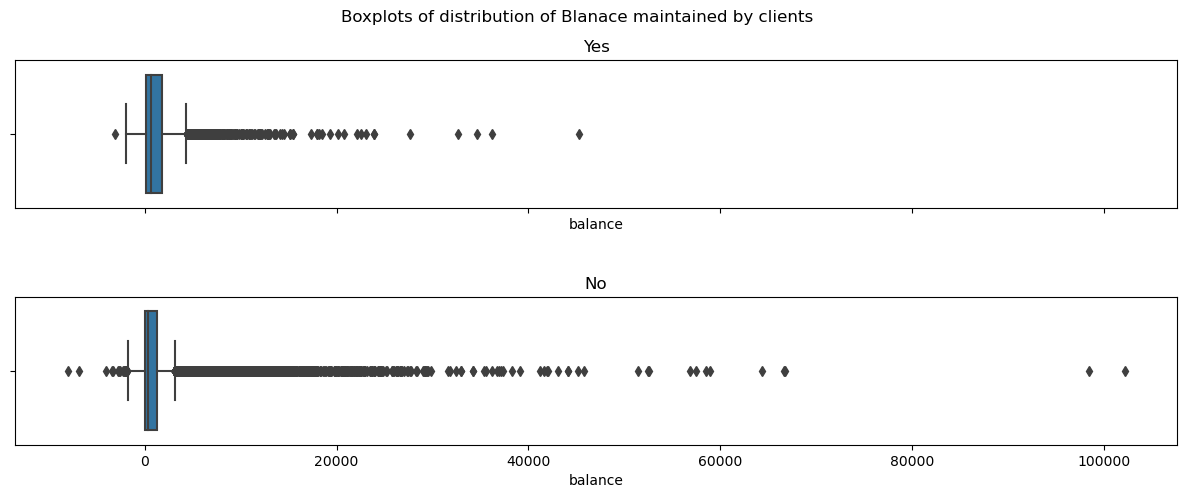

In [66]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (15,5))
fig.suptitle('Boxplots of distribution of Blanace maintained by clients')
sns.boxplot(x='balance', data = data[data['y']=='yes'], ax= axes[0])
axes[0].set_title('Yes')
sns.boxplot(x='balance', data = data[data['y']=='no'], ax = axes[1] )
axes[1].set_title('No')
plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show();

In [67]:
np.min(data[data['y']=='yes']['balance'])

-3058

In [68]:
np.max(data[data['y']=='no']['balance'])

102127

In [69]:
np.max(data[data['y']=='yes']['balance'])

45248

<AxesSubplot:xlabel='balance', ylabel='default'>

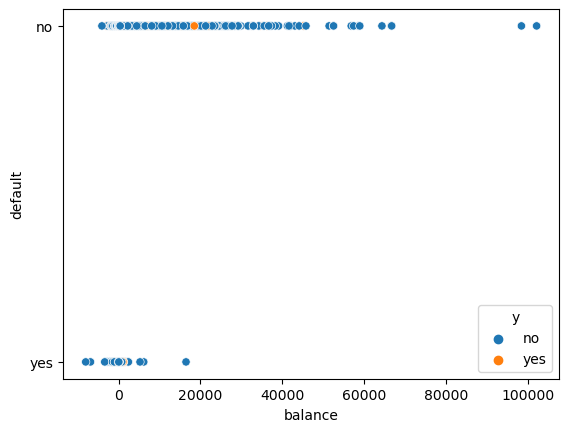

In [70]:
sns.scatterplot(x='balance', y='default', data=data, hue='y')

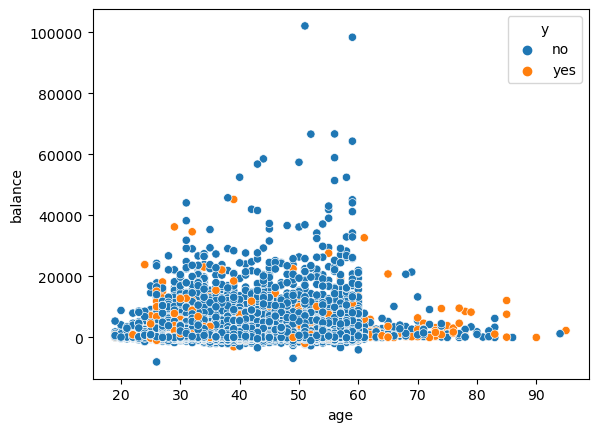

In [71]:
sns.scatterplot(x='age', y='balance', data = data, hue = 'y')
plt.savefig('dist_balance_age.png', bbox_inches = 'tight')
plt.show();

We see roughly 5% of customers who had defaulted on loans and had agreed to term deposits maintained an average annual balance of 0 or were overdrawn. This goes up to roughly 8% when we look at customers who haven't defaulted on loans. When we compare the customer profiling metrics between overdrawn and incredit customers we see that both of these groups have roughly the same distribution in ages of customers. We see the the percentages of customers from various education backgrounds and to some extent in jobs are also mimicked between those who are overdrawn and those who aren't. This suggests that looking to differentiate between customers with overdrawn as a feature is not useful. When we look at the balance of customers who have signed up for term deposits grouped by employmnet and education backgrounds, we do see that for every segment customers who have higher balances sign up for term deposits. This suggests balance is a possible key feature, however how to segment customers based on balance is something we need to dig deeper into. 

### Housing Loans

Type of data: Binary where 'yes' indicates whether the customer has housing loans or not

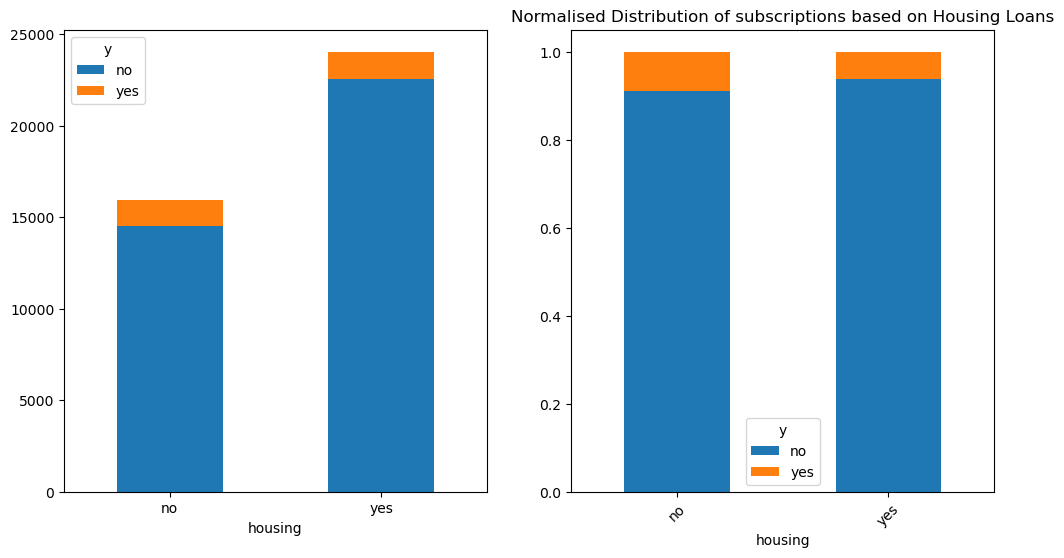

In [72]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['housing'], data['y']).plot(kind='bar', stacked=True, rot=0, ax=axes[0])
data.groupby('housing')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                             title = 'Normalised Distribution of subscriptions based on Housing Loans')
plt.show();

In [73]:
has_housing = data[data['housing']=='yes']
no_housing = data[data['housing']=='no']

Distribution of customers who have housing loans segmented by education:
 y    education
no   secondary    52.969082
     tertiary     22.679040
     primary      15.163747
     unknown       3.096001
yes  secondary     3.324872
     tertiary      1.747742
     primary       0.853065
     unknown       0.166452
Name: education, dtype: float64
Distribution of customers without housing loans segmented by education:
 y    education
no   secondary    42.870562
     tertiary     29.601102
     primary      14.233828
     unknown       4.327134
yes  secondary     3.876260
     tertiary      3.813639
     primary       0.926796
     unknown       0.350679
Name: education, dtype: float64


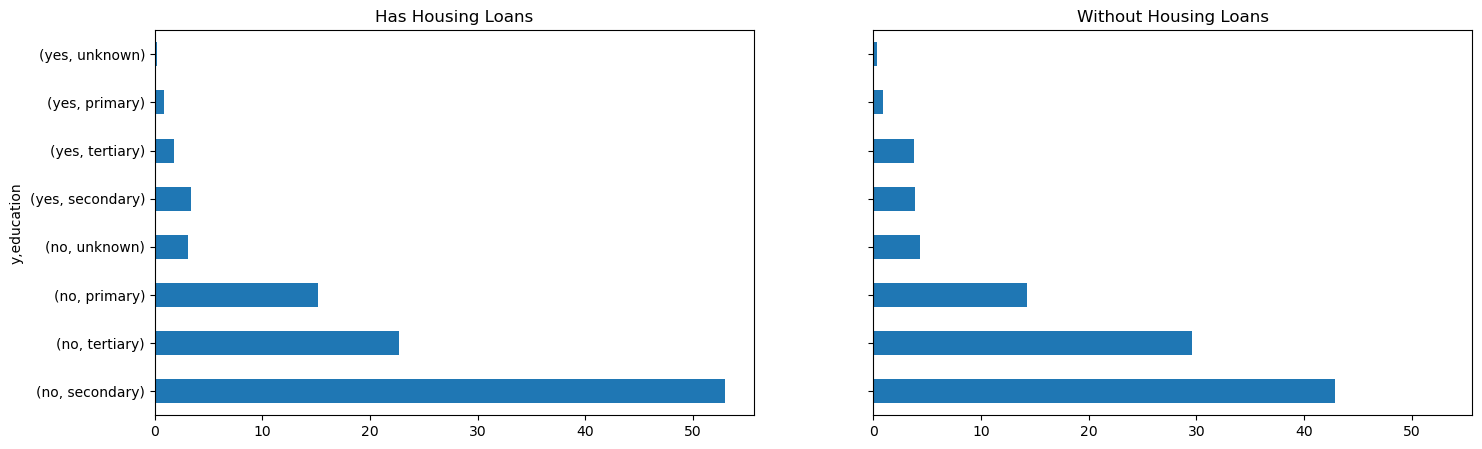

In [74]:
print('Distribution of customers who have housing loans segmented by education:\n' , has_housing.groupby('y')['education'].value_counts()/len(has_housing)*100)
print('Distribution of customers without housing loans segmented by education:\n' , no_housing.groupby('y')['education'].value_counts()/len(no_housing)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))
(has_housing.groupby('y')['education'].value_counts()/len(has_housing)*100).plot(ax = axes[0],kind='barh', 
                                                                                 title= 'Has Housing Loans')
(no_housing.groupby('y')['education'].value_counts()/len(no_housing)*100).plot(kind='barh', ax=axes[1], 
                                                                              title = 'Without Housing Loans')
plt.show();

Distribution of customers who have housing loans segmented by jobs:
 y    job          
no   blue-collar      27.281428
     management       16.940618
     technician       15.142940
     admin            11.401939
     services         10.644584
     entrepreneur      3.366485
     self-employed     2.821356
     unemployed        2.022388
     retired           1.776872
     housemaid         1.498065
     student           0.915484
     unknown           0.095710
yes  blue-collar       1.568807
     management        1.240065
     technician        0.998710
     admin             0.819774
     services          0.640839
     self-employed     0.228871
     entrepreneur      0.195581
     unemployed        0.120677
     retired           0.112355
     housemaid         0.079065
     student           0.079065
     unknown           0.008323
Name: job, dtype: float64
Distribution of customers without housing loans segmented by education:
 y    job          
no   management       21.4

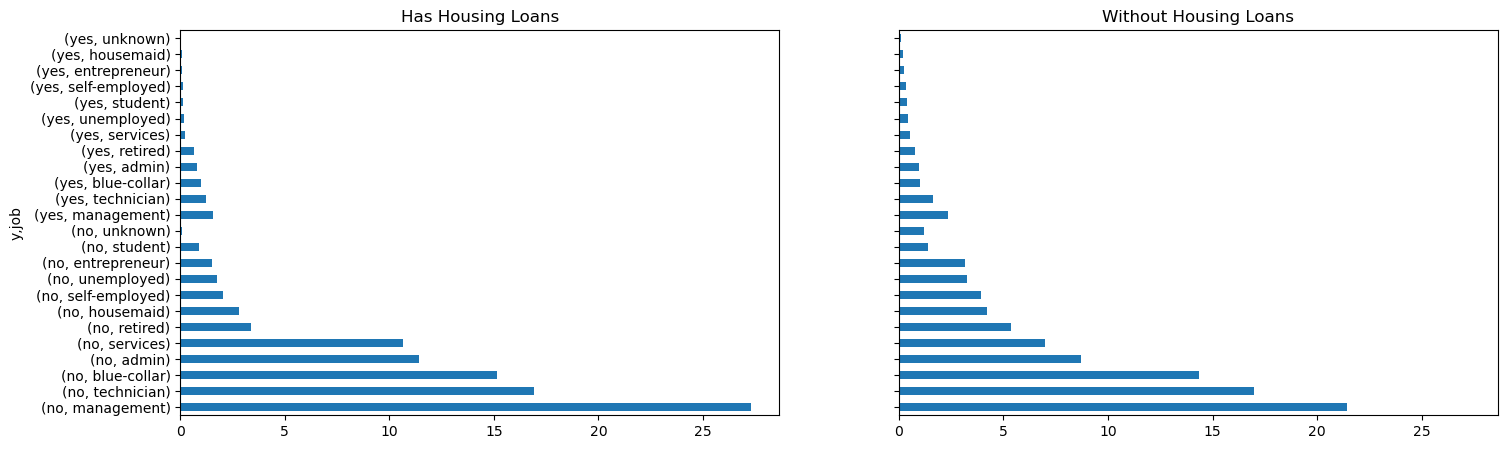

In [75]:
print('Distribution of customers who have housing loans segmented by jobs:\n' , has_housing.groupby('y')['job'].value_counts()/len(has_housing)*100)
print('Distribution of customers without housing loans segmented by education:\n' , no_housing.groupby('y')['job'].value_counts()/len(no_housing)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))
(has_housing.groupby('y')['job'].value_counts()/len(has_housing)*100).plot(ax = axes[0],kind='barh', 
                                                                                 title= 'Has Housing Loans')
(no_housing.groupby('y')['job'].value_counts()/len(no_housing)*100).plot(kind='barh', ax=axes[1], 
                                                                              title = 'Without Housing Loans')
plt.show();

In [76]:
has_housing

age            job   marital  education default  balance housing loan  \
32971   47    blue-collar  divorced  secondary      no     3823     yes  yes   
1820    47    blue-collar   married    primary      no       94     yes   no   
16869   38   entrepreneur   married    primary      no       21     yes   no   
31489   58     management  divorced   tertiary      no      315     yes   no   
29075   56    blue-collar   married  secondary      no      659     yes   no   
...    ...            ...       ...        ...     ...      ...     ...  ...   
16586   34  self-employed    single   tertiary      no      693     yes   no   
38167   39    blue-collar   married    primary      no       49     yes   no   
15209   36     management  divorced   tertiary      no      210     yes   no   
38077   32     technician   married  secondary      no      344     yes  yes   
8714    41          admin    single  secondary      no      400     yes   no   

        contact  day  month  duration  campaign   y  
32971  cellular   17      4       647         2  no  
1820    unknown    9      5       209         3  no  
16869  cellular   25      7        65         4  no  
31489  cellular    1      4       121         2  no  
29075  cellular    2      2       148         1  no  
...         ...  ...    ...       ...       ...  ..  
16586  cellular   24      7       130         1  no  
38167  cellular   15      5       259         1  no  
15209  cellular   17      7       182         2  no  
38077  cellular   14      5        54        11  no  
8714    unknown    4      6        99         6  no  

[24031 rows x 14 columns]

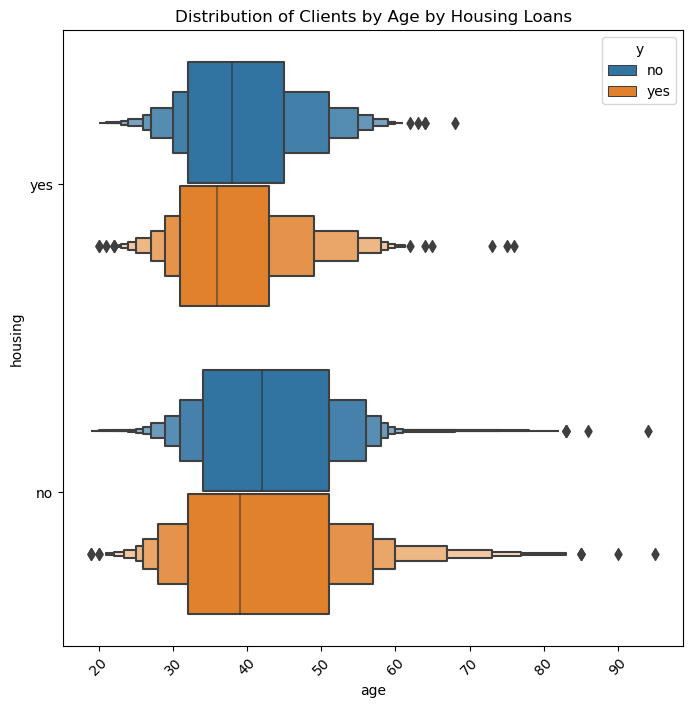

In [77]:
plt.figure(figsize=(8,8))
sns.boxenplot(x='age', y='housing', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Age by Housing Loans')
plt.show();

### Personal Loan

Type of Data: Binary data where 'yes' indicates the customer has personal loans 

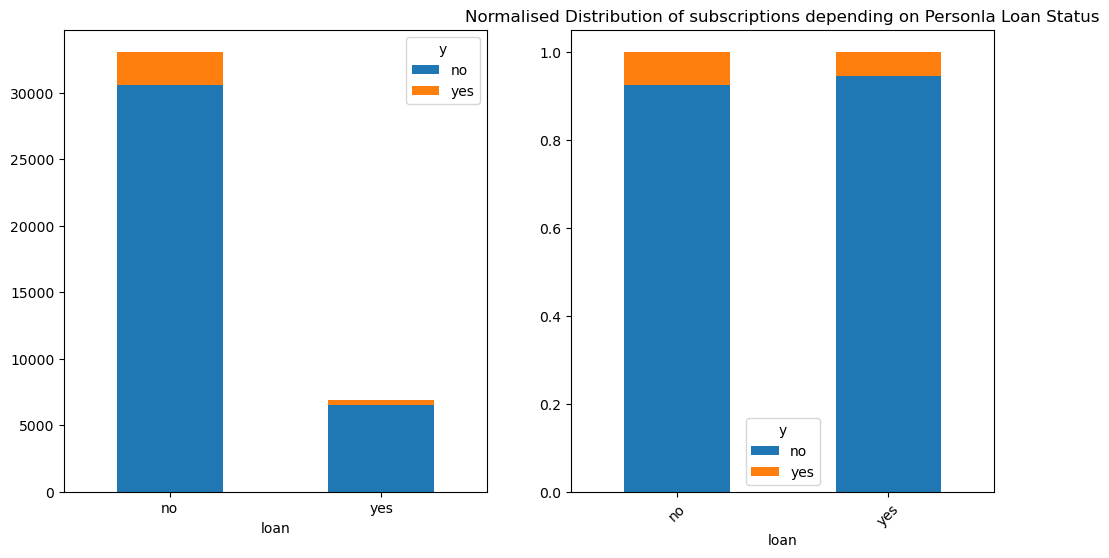

In [78]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['loan'], data['y']).plot(ax = axes[0],kind='bar', stacked=True, rot=0)
data.groupby('loan')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                                  title = 'Normalised Distribution of subscriptions depending on Personla Loan Status')
plt.show();

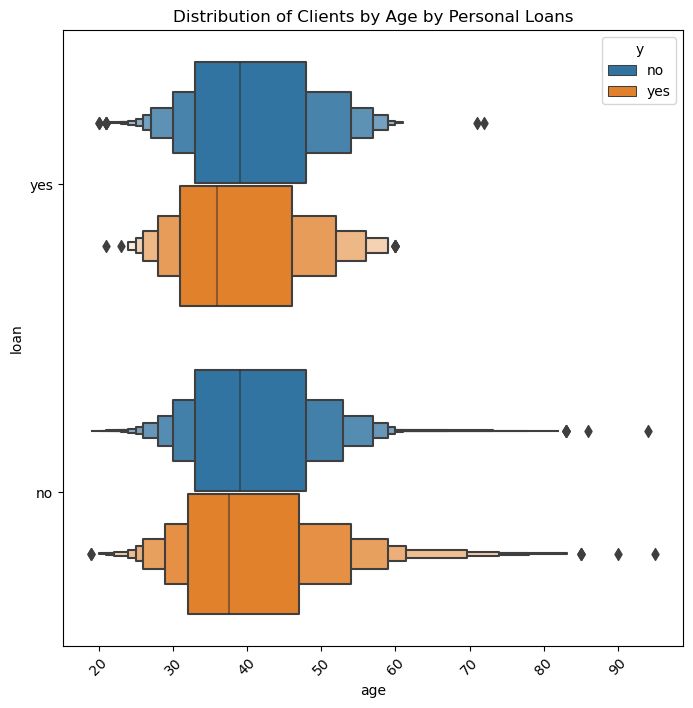

In [79]:
plt.figure(figsize=(8,8))
sns.boxenplot(x='age', y='loan', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Age by Personal Loans')
plt.show();

In [80]:
has_personal_loan = data[data['loan']=='yes']
has_no_loan = data[data['loan']=='no']

Distribution of customers with personal loans:
 y    education
no   secondary    56.349206
     tertiary     22.510823
     primary      13.924964
     unknown       1.731602
yes  secondary     3.275613
     tertiary      1.385281
     primary       0.721501
     unknown       0.101010
Name: education, dtype: float64


Distribution of customers without personal loans: 
 y    education
no   secondary    47.384336
     tertiary     26.056849
     primary      14.974297
     unknown       3.976414
yes  secondary     3.601451
     tertiary      2.821288
     primary       0.916238
     unknown       0.269126
Name: education, dtype: float64


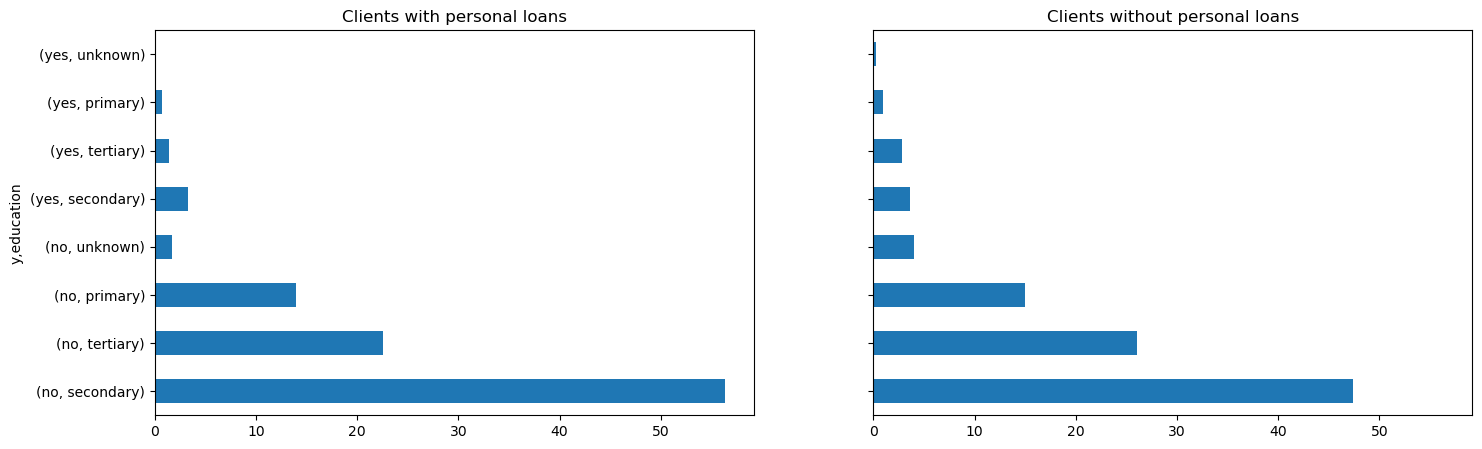

In [81]:
print('Distribution of customers with personal loans:\n' , has_personal_loan.groupby('y')['education'].value_counts()/len(has_personal_loan)*100)
print('\n')
print('Distribution of customers without personal loans: \n' , has_no_loan.groupby('y')['education'].value_counts()/len(has_no_loan)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))

(has_personal_loan.groupby('y')['education'].value_counts()/len(has_personal_loan)*100).plot(kind='barh', ax=axes[0], title = 'Clients with personal loans')

(has_no_loan.groupby('y')['education'].value_counts()/len(has_no_loan)*100).plot(kind='barh', ax=axes[1],
                                                                            title= 'Clients without personal loans')
plt.show();

Distribution of customers with personal loans:
 y    job          
no   blue-collar      22.582973
     technician       16.940837
     management       16.161616
     admin            12.077922
     services         11.269841
     entrepreneur      4.819625
     retired           4.098124
     self-employed     2.929293
     housemaid         2.049062
     unemployed        1.428571
     student           0.129870
     unknown           0.028860
yes  blue-collar       1.399711
     management        0.923521
     technician        0.880231
     admin             0.865801
     services          0.577201
     self-employed     0.245310
     entrepreneur      0.230880
     retired           0.202020
     housemaid         0.072150
     unemployed        0.057720
     unknown           0.028860
Name: job, dtype: float64


Distribution of customers without personal loans: 
 y    job          
no   blue-collar      22.022982
     management       19.262171
     technician       15.666767
  

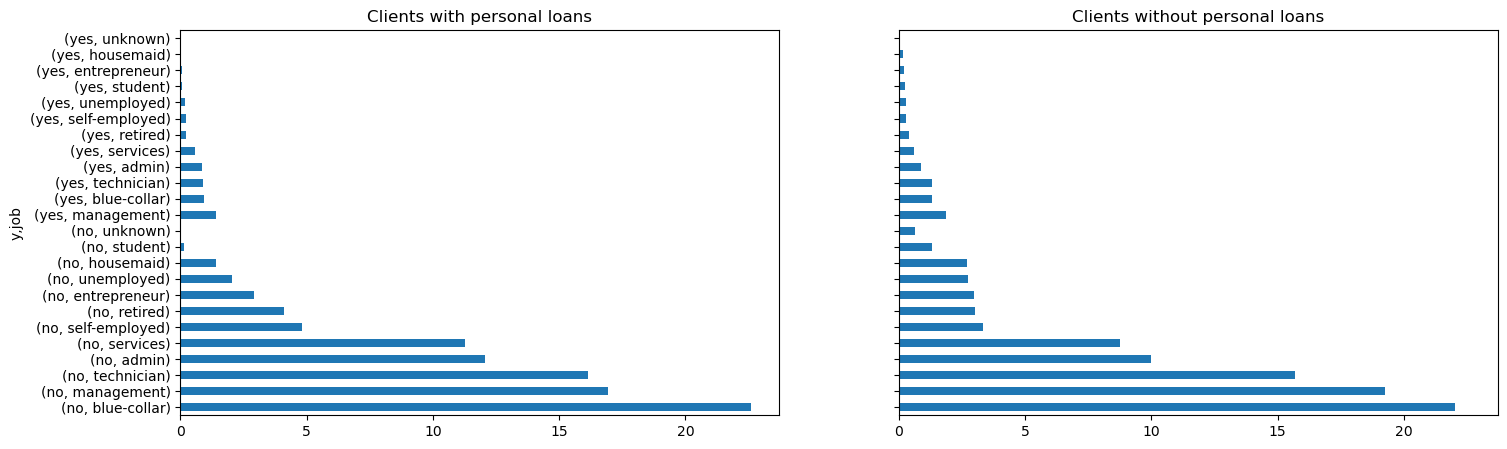

In [82]:
print('Distribution of customers with personal loans:\n' , has_personal_loan.groupby('y')['job'].value_counts()/len(has_personal_loan)*100)
print('\n')
print('Distribution of customers without personal loans: \n' , has_no_loan.groupby('y')['job'].value_counts()/len(has_no_loan)*100)
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17,5))

(has_personal_loan.groupby('y')['job'].value_counts()/len(has_personal_loan)*100).plot(kind='barh', ax=axes[0], title = 'Clients with personal loans')

(has_no_loan.groupby('y')['job'].value_counts()/len(has_no_loan)*100).plot(kind='barh', ax=axes[1],
                                                                            title= 'Clients without personal loans')
plt.show();

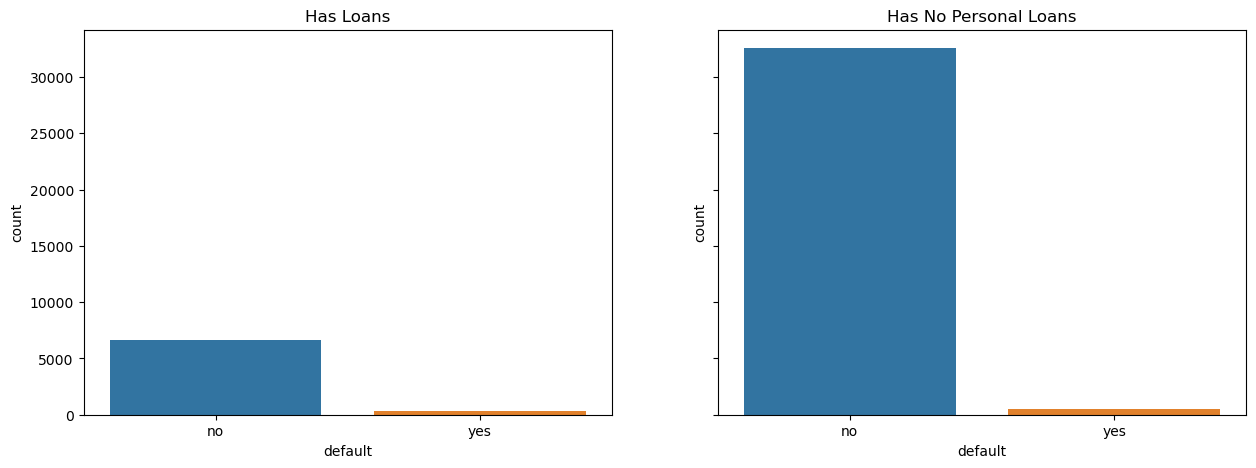

In [83]:
fig, axes = plt.subplots(1, 2, sharey = True, figsize = (15,5))
sns.countplot(x='default', data = has_personal_loan, ax=axes[0])
axes[0].set_title('Has Loans')
sns.countplot(x='default', data = has_no_loan, ax = axes[1])
axes[1].set_title('Has No Personal Loans')
plt.show();


## Marketing Strategies
We can finally explore features such as communication type, the last day and month of contact, duration of last contact, and number of times contacted during the last campaign to see if there are strategies that have yielded a higher number of subscriptions for term deposits. 

### Communication Type

Type of Data: categorical

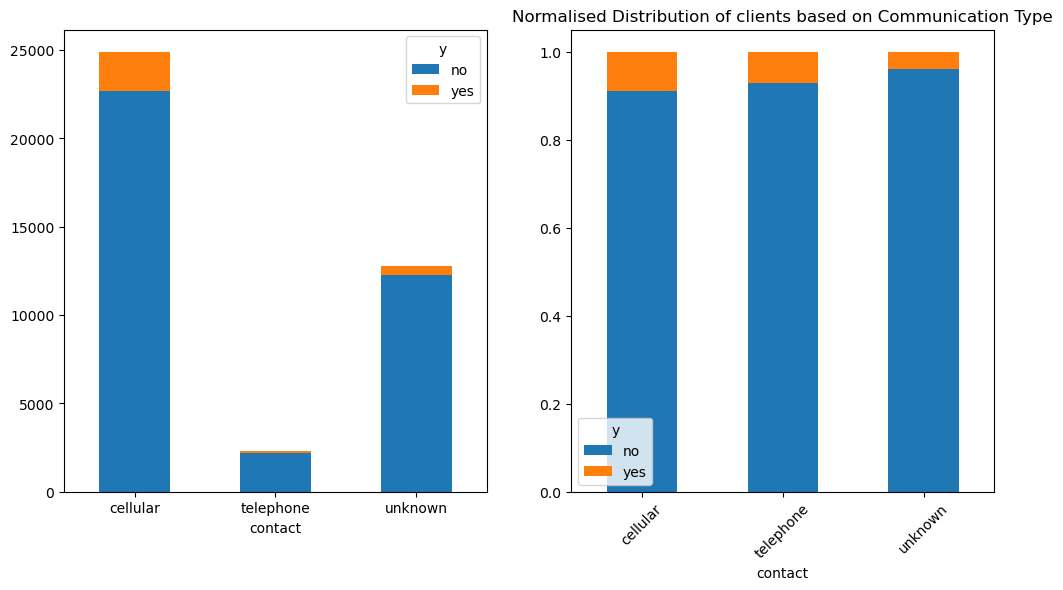

In [84]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
pd.crosstab(data['contact'], data['y']).plot(kind='bar', stacked=True,rot=0, ax= axes[0])
data.groupby('contact')['y'].value_counts(normalize = True).unstack('y').plot.bar(rot = 45, stacked=True, ax = axes[1], 
                                                                                 title = 'Normalised Distribution of clients based on Communication Type')
plt.show();

In [85]:
cellular = data[data['contact']=='cellular']
tel_contact = data[data['contact']=='telephone']
misc_cont = data[data['contact']=='unknown']

Count of Clients by communication style who subscribed for term deposits: 
 cellular     77.106354
unknown      17.161602
telephone     5.732044
Name: contact, dtype: float64


Count of Clients by communication style who didn't subscribe for term deposits: 
 cellular     61.128180
unknown      33.063821
telephone     5.807999
Name: contact, dtype: float64


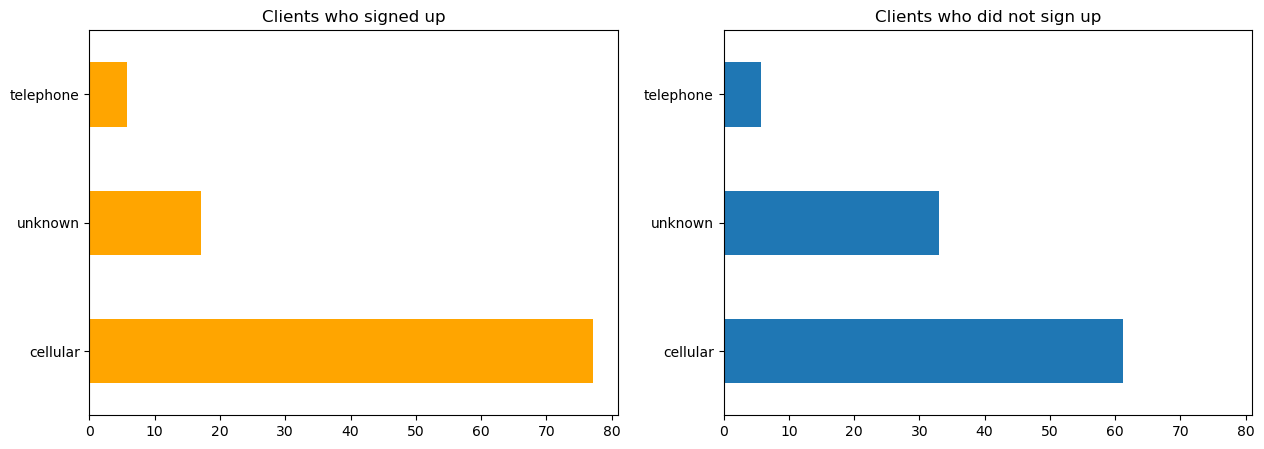

In [86]:
print("Count of Clients by communication style who subscribed for term deposits: \n",
      (data[data['y']=='yes']['contact'].value_counts()/len(data[data['y']=='yes']['contact']))*100)
print('\n')
print("Count of Clients by communication style who didn't subscribe for term deposits: \n",
      (data[data['y']=='no']['contact'].value_counts()/len(data[data['y']=='no']['contact']))*100)
fig, axes = plt.subplots(1, 2, sharex = True, figsize = (15,5))
((data[data['y']=='yes']['contact'].value_counts()/len(data[data['y']=='yes']['contact']))*100).plot(ax=axes[0],kind='barh', color = 'orange', 
                                                                                             title = 'Clients who signed up' )
((data[data['y']=='no']['contact'].value_counts()/len(data[data['y']=='no']['contact']))*100).plot(kind='barh', ax= axes[1], 
                                                                                          title = 'Clients who did not sign up')
plt.show();

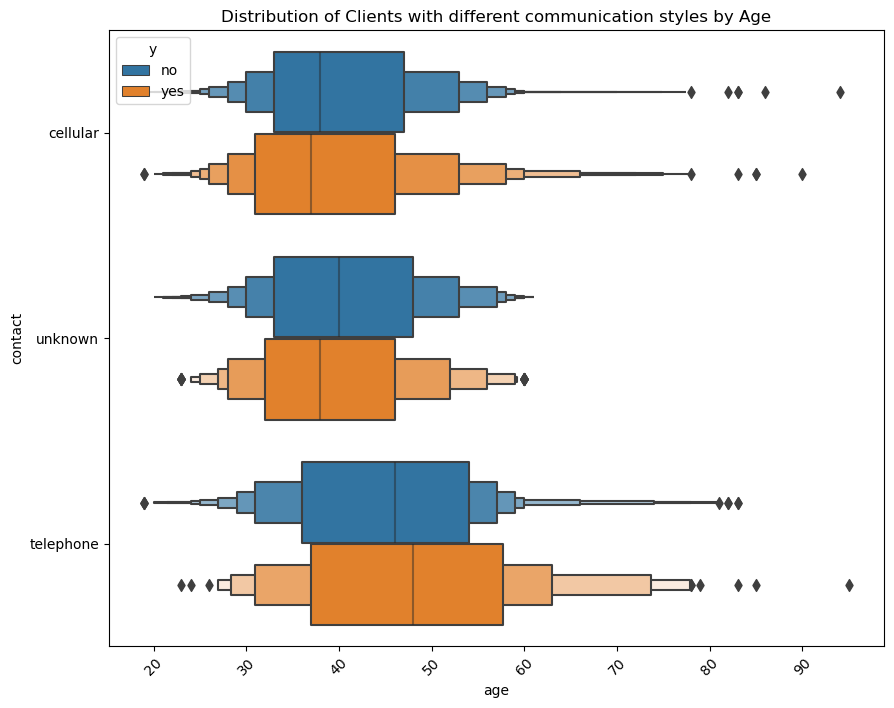

In [87]:
plt.figure(figsize=(10,8))
sns.boxenplot(x='age', y='contact', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients with different communication styles by Age')
plt.show();

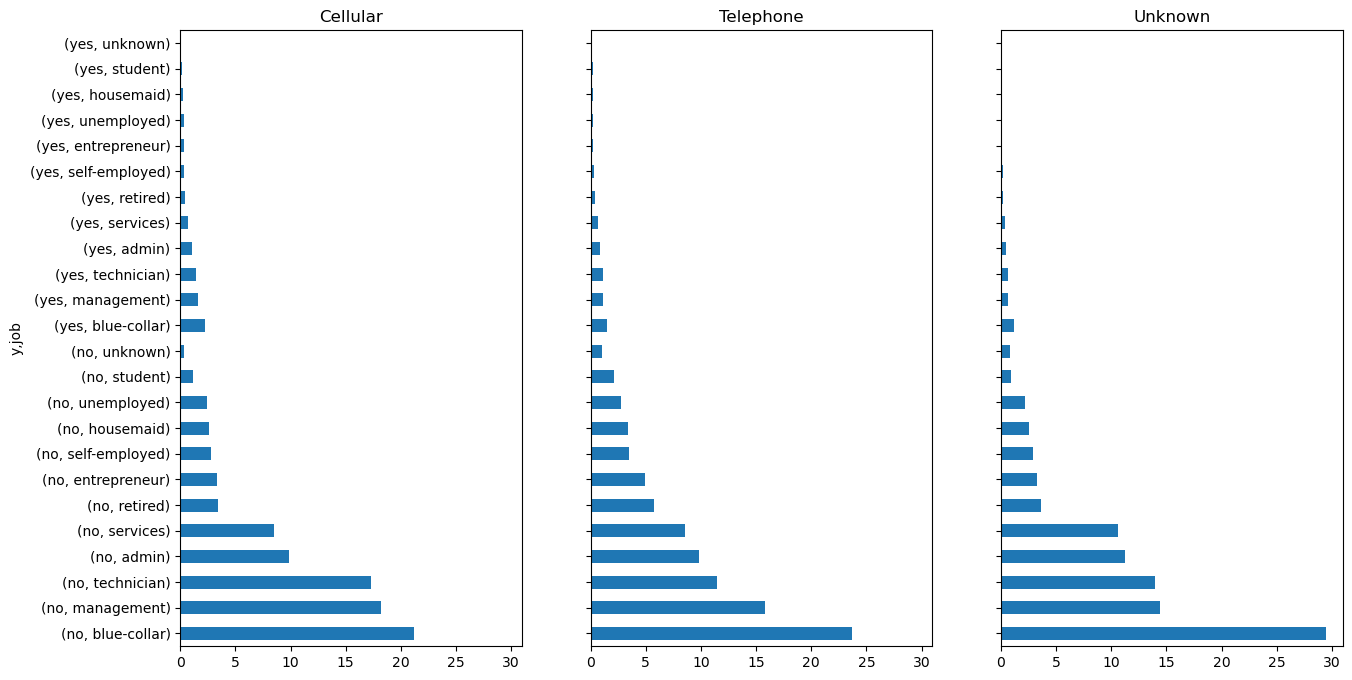

In [88]:
fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (15,8))

(cellular.groupby('y')['job'].value_counts()/len(cellular)*100).plot(kind='barh', ax=axes[0],
                                                                            title = 'Cellular')

(tel_contact.groupby('y')['job'].value_counts()/len(tel_contact)*100).plot(kind='barh', ax = axes[1], 
                                                                      title = 'Telephone')

(misc_cont.groupby('y')['job'].value_counts()/len(misc_cont)*100).plot(kind='barh', ax = axes[2], 
                                                                      title = 'Unknown')
plt.show();


Similar distributions however we can see that celluar contact has a higher frequency amongst the clients who signed up for subsciptions. 

### Last Day of Contact of the Month

Type of Data: numeric

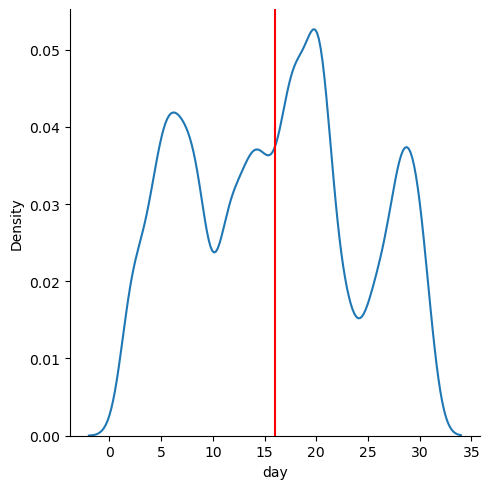

In [89]:
sns.displot(data['day'], kind='kde')
plt.axvline(np.mean(data['day']), c='red')
plt.show();

In [90]:
print("Day's of the month by freqeuncy:\n", data['day'].value_counts()/len(data)*100)

Day's of the month by freqeuncy:
 20    6.6375
18    5.4325
21    4.7850
17    4.5300
6     4.4450
5     4.2275
28    4.1250
19    4.1250
14    4.0900
8     4.0500
7     4.0300
29    4.0000
15    3.6700
30    3.6425
9     3.4350
13    3.3125
12    3.2225
11    3.1800
16    3.0375
4     2.9575
2     2.7725
27    2.4350
26    2.2375
3     2.1850
23    2.0575
22    1.9325
25    1.7375
31    1.4775
10    0.9100
24    0.8800
1     0.4400
Name: day, dtype: float64


The distribution looks multimodal.

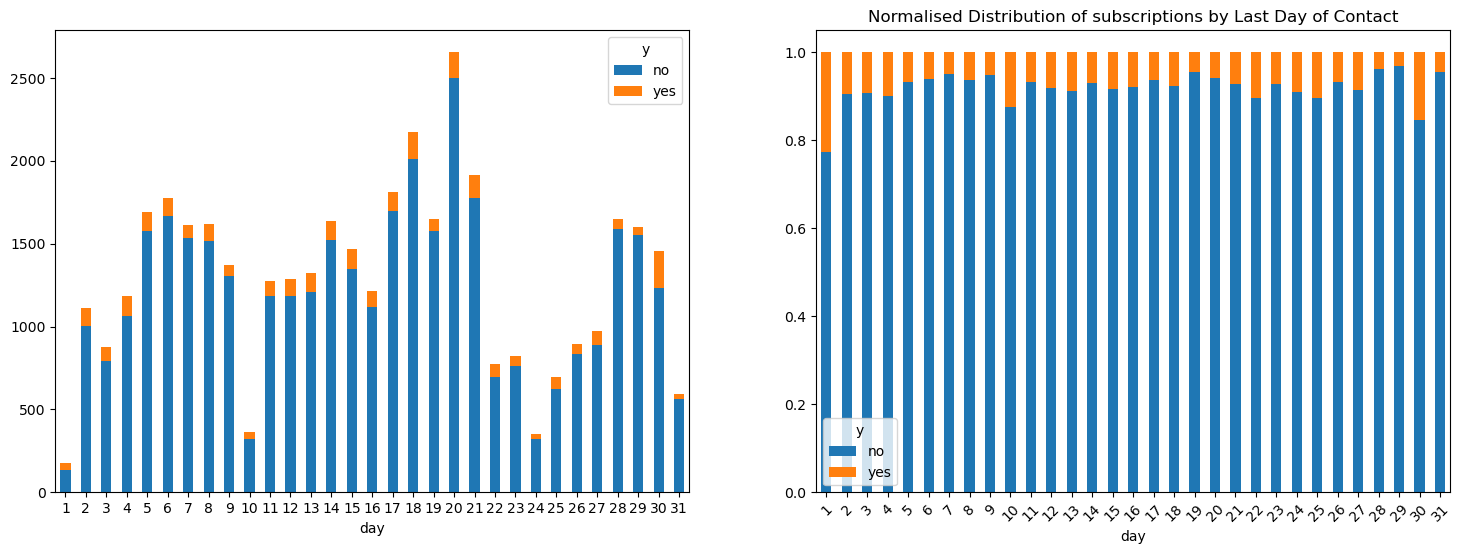

In [91]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (18,6))

pd.crosstab(data['day'], data['y']).plot(kind='bar', stacked=True, ax=axes[0], rot=0)
data.groupby('day')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                             title = 'Normalised Distribution of subscriptions by Last Day of Contact')
plt.show();

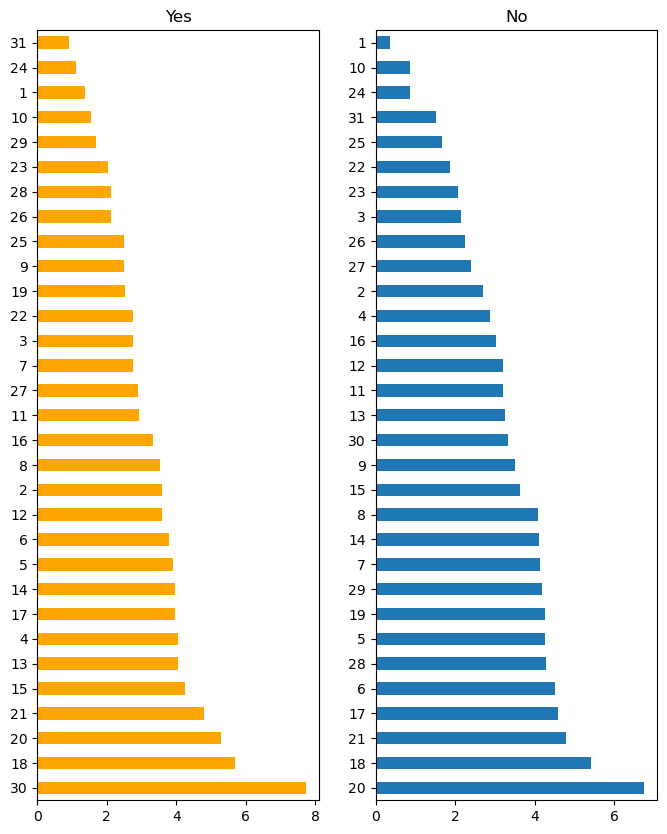

In [92]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (8, 10))
(data[data['y']=='yes']['day'].value_counts()/len(data[data['y']=='yes'])*100).plot(ax = axes[0], kind='barh', color = 'orange',
                                                                                   title = 'Yes')
(data[data['y']=='no']['day'].value_counts()/len(data[data['y']=='no'])*100).plot(ax = axes[1], kind='barh', title = 'No')
plt.show();

### Last Contact Month of the Year

Type of Data: Categorical

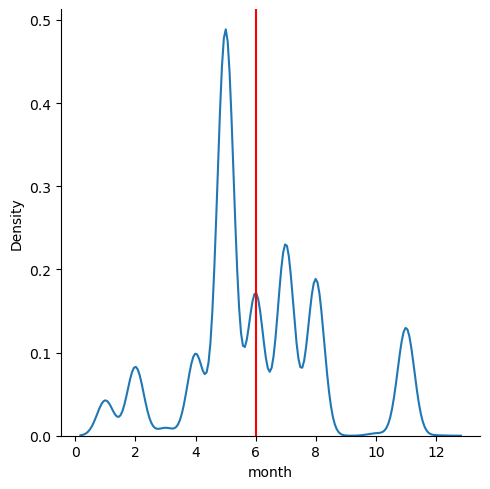

In [93]:
sns.displot(data['month'], kind='kde')
plt.axvline(np.mean(data['month']), c='red')
plt.show();

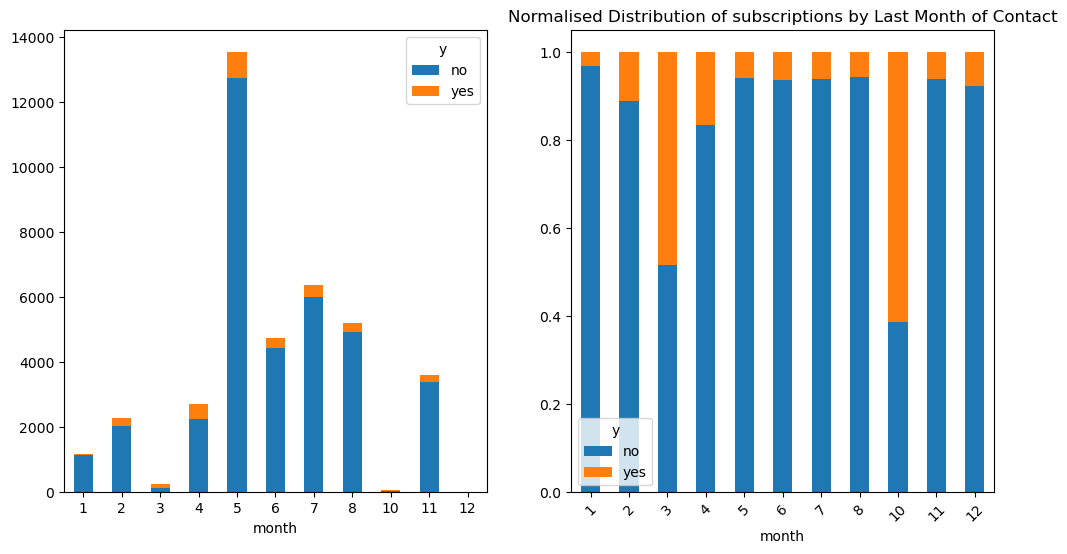

In [94]:
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))

pd.crosstab(data['month'], data['y']).plot(kind='bar', stacked=True, ax=axes[0], rot=0)
data.groupby('month')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 45,
                                                                             title = 'Normalised Distribution of subscriptions by Last Month of Contact')
plt.show();

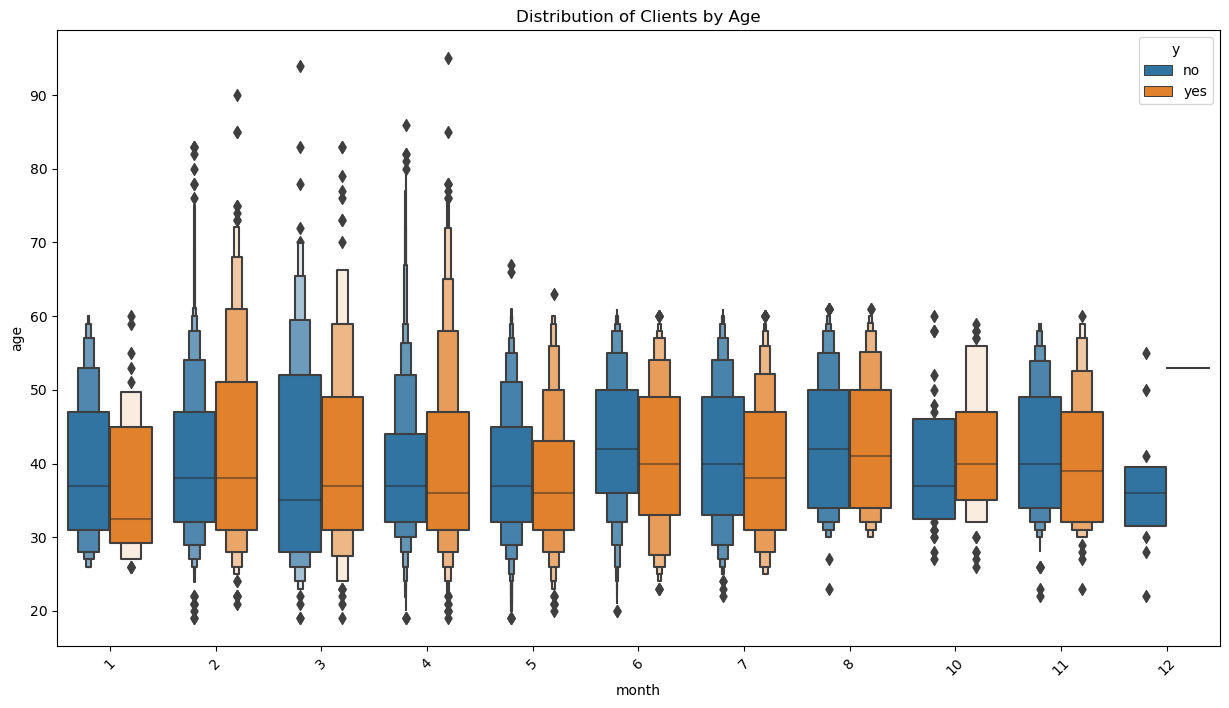

In [95]:
plt.figure(figsize=(15,8))
sns.boxenplot(y='age', x='month', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Age')
plt.show();

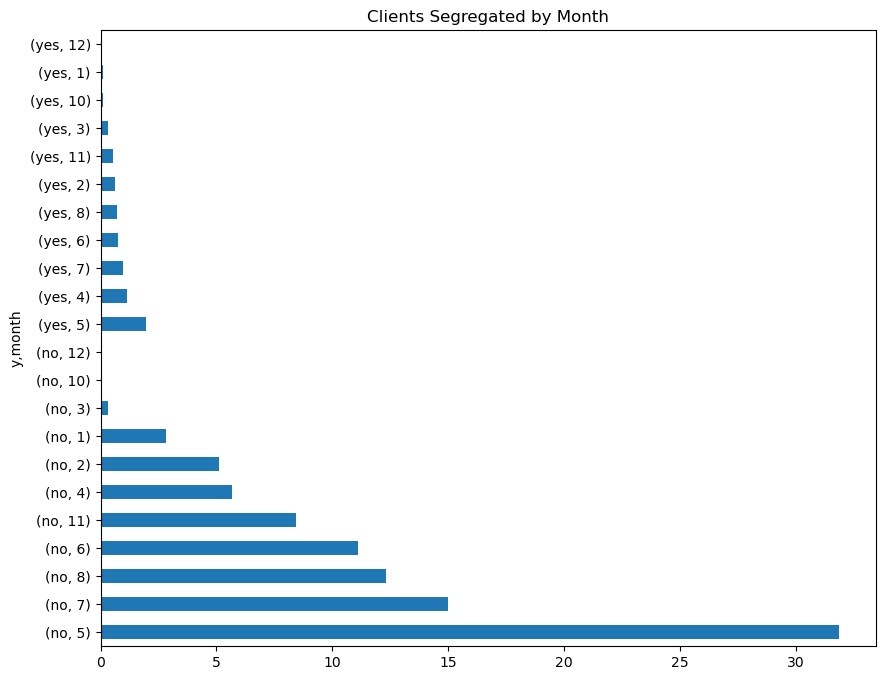

In [96]:
plt.figure(figsize = (10,8))
(data.groupby('y')['month'].value_counts()/len(data)*100).plot(kind='barh', title = 'Clients Segregated by Month')
plt.show();

We see that the highest number of customers who subscribed and those who didn't subscribe for term deposits all occured during the month of May. This is most likely due to there being a higher frequency of customers in may. This further supports the idea we should look at months of March and October as the months of higher subscription rates. 

### Duration of the Last Contact (Seconds)

Type of Data: Numeric

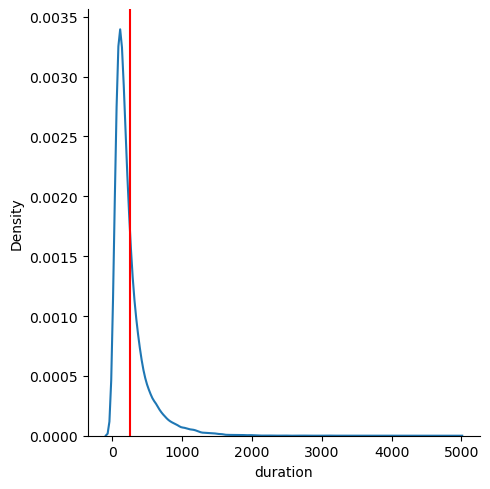

In [97]:
sns.displot(data['duration'], kind='kde')
plt.axvline(np.mean(data['duration']), c='red')
plt.show();

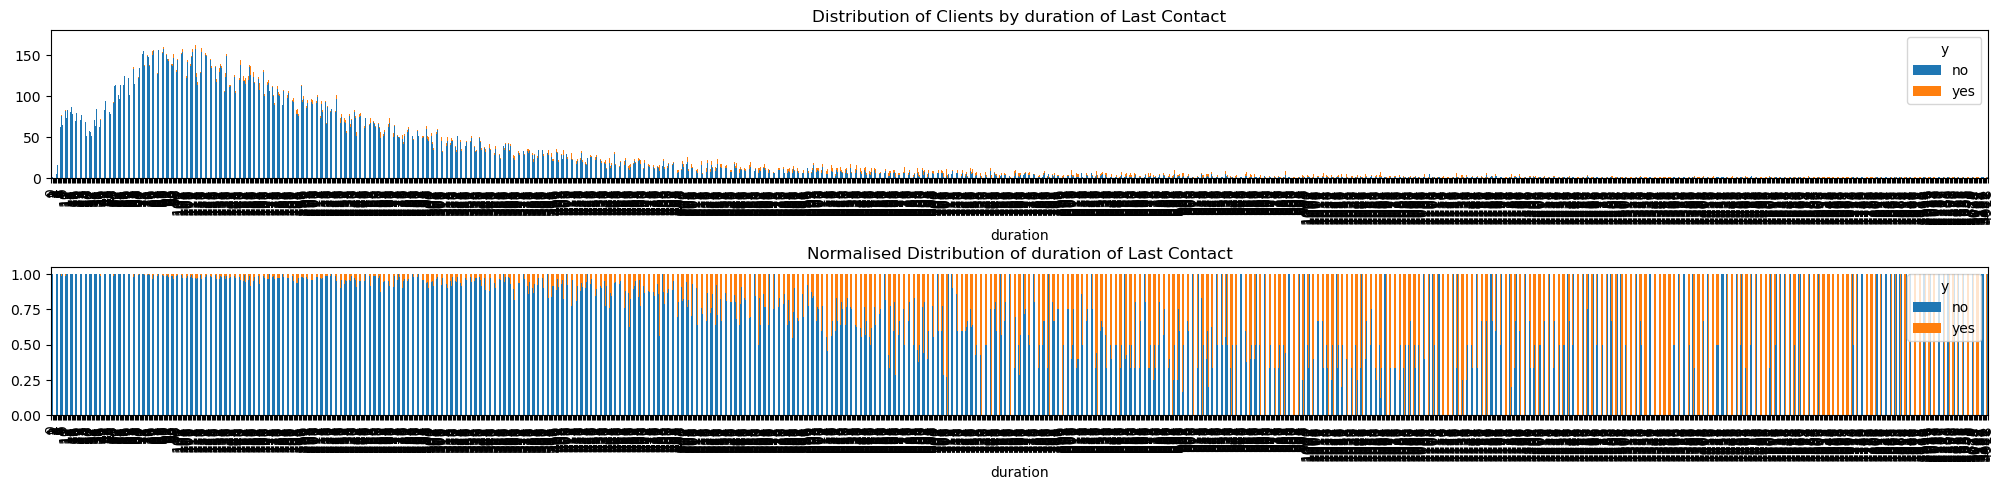

In [98]:
fig, axes = plt.subplots(nrows=2, ncols = 1, figsize = (25,5))
pd.crosstab(data['duration'], data['y']).plot(kind='bar', stacked=True, rot=90, ax = axes[0], 
                                         title = 'Distribution of Clients by duration of Last Contact')
data.groupby('duration')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 90,
                                                                             title = 'Normalised Distribution of duration of Last Contact')
plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show();

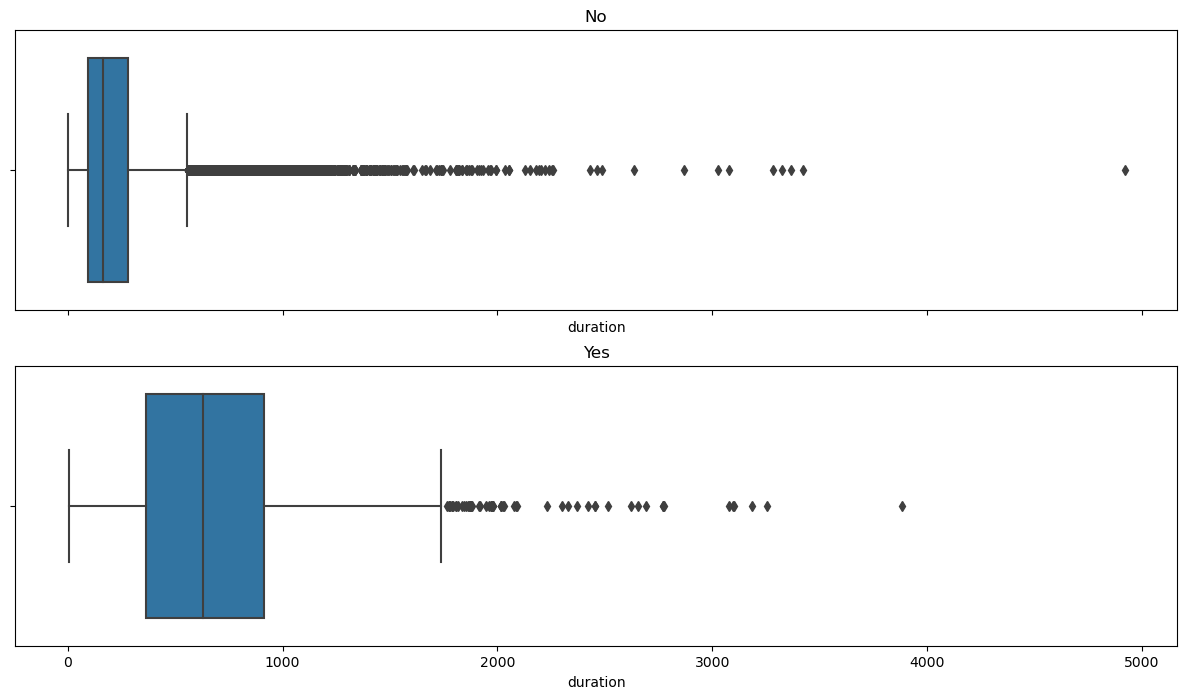

In [99]:
fig, axes = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (15,8))
sns.boxplot(x='duration', data = data[data['y']=='no'], ax = axes[0])
axes[0].set_title('No')
sns.boxplot(x='duration', data = data[data['y']=='yes'], ax = axes[1] )
axes[1].set_title('Yes')
plt.show();

In [100]:
np.min(data[data['y']=='no']['duration'])

0

In [101]:
zero_duration = data[data['duration']==0]

In [102]:
zero_duration['y'].nunique()

1

In [103]:
np.max(data[data['y']=='no']['duration'])

4918

In [104]:
np.min(data[data['y']=='yes']['duration'])

8

In [105]:
np.max(data[data['y']=='yes']['duration'])

3881

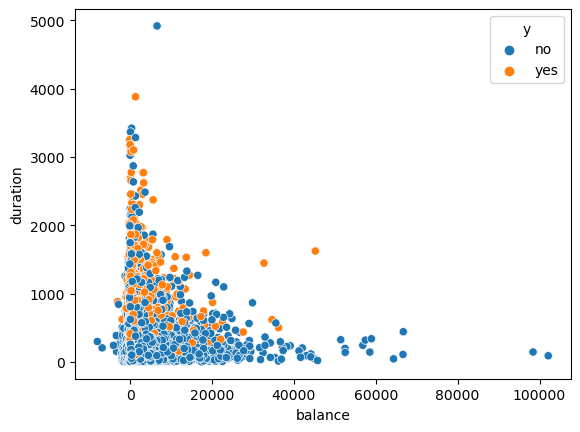

In [106]:
sns.scatterplot(x='balance', y='duration', data = data, hue = 'y')
plt.savefig('duration_age.png', bbox_inches = 'tight')
plt.show();

### Number of Contacts for each client for this campaign

(note: this includes the last contact)

Type of Data: Numeric

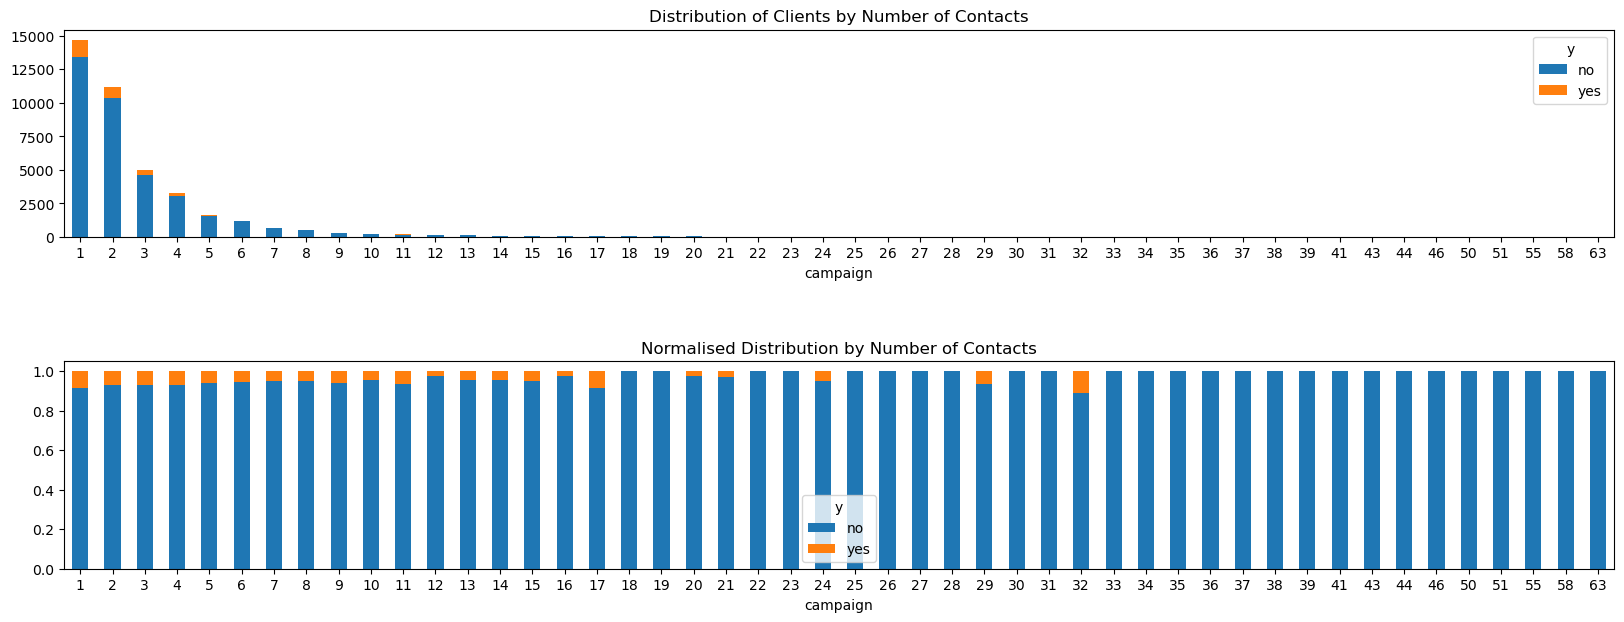

In [107]:
fig, axes = plt.subplots(nrows=2, ncols = 1, figsize = (20,7))
pd.crosstab(data['campaign'], data['y']).plot(kind='bar', stacked=True, rot=0, ax = axes[0], 
                                         title = 'Distribution of Clients by Number of Contacts')
data.groupby('campaign')['y'].value_counts(normalize = True).unstack('y').plot.bar(stacked=True, ax = axes[1], rot = 0,
                                                                             title = 'Normalised Distribution by Number of Contacts')
plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show();

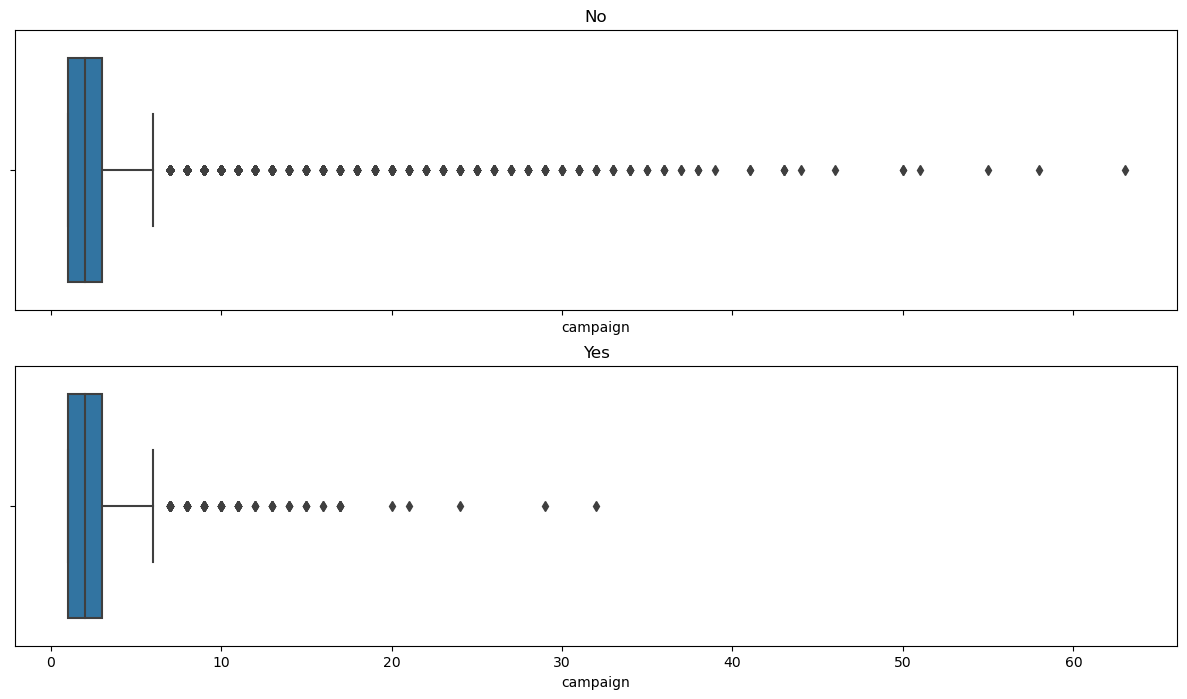

In [108]:
fig, axes = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (15,8))
sns.boxplot(x='campaign', data = data[data['y']=='no'], ax = axes[0])
axes[0].set_title('No')
sns.boxplot(x='campaign', data = data[data['y']=='yes'], ax = axes[1] )
axes[1].set_title('Yes')
plt.show();


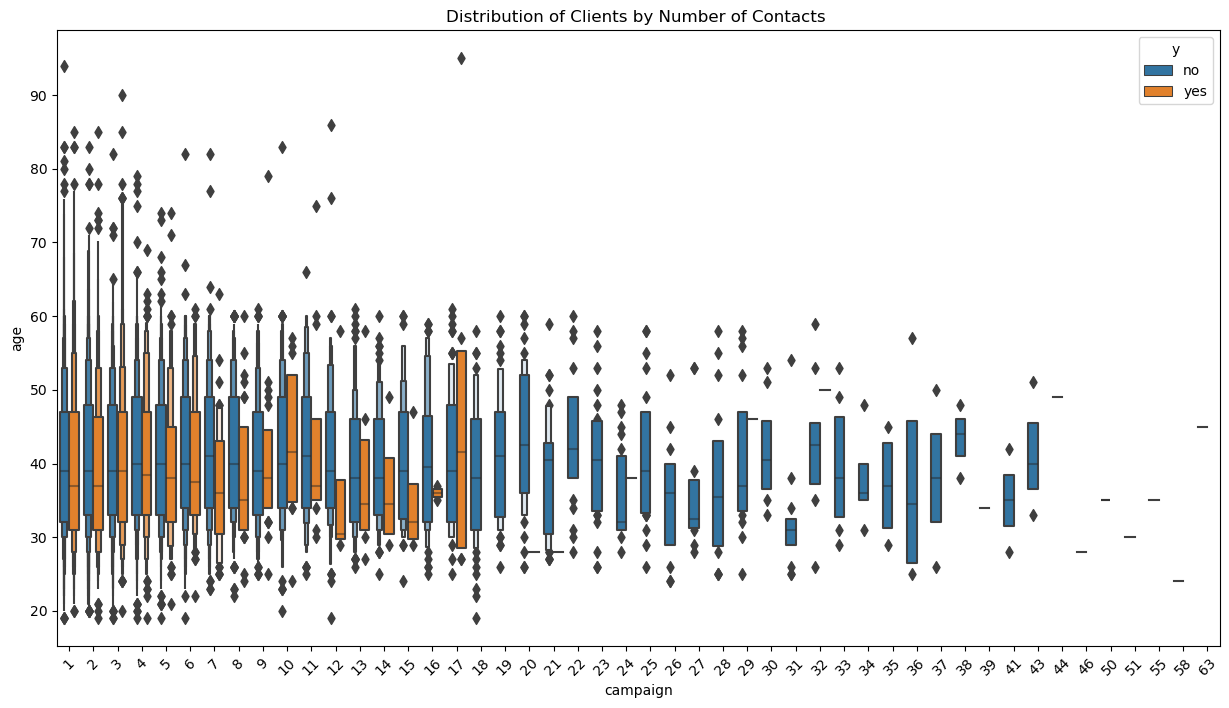

In [109]:
plt.figure(figsize=(15,8))
sns.boxenplot(y='age', x='campaign', data = data, hue = 'y')
plt.xticks(rotation = 45)
plt.title('Distribution of Clients by Number of Contacts ')
plt.show();

In [110]:
data[data['campaign']==17]['y'].nunique()

2

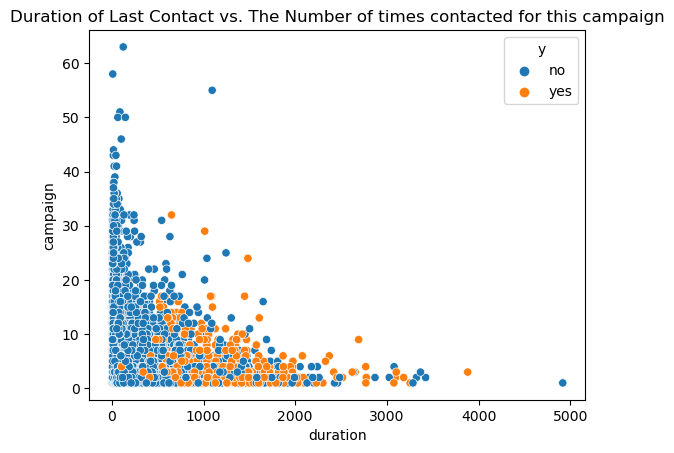

In [111]:
sns.scatterplot(x='duration', y='campaign', data = data, hue = 'y')
plt.title('Duration of Last Contact vs. The Number of times contacted for this campaign')
plt.savefig('campaign_duration.png', bbox_inches = 'tight')
plt.show()

### Correlation

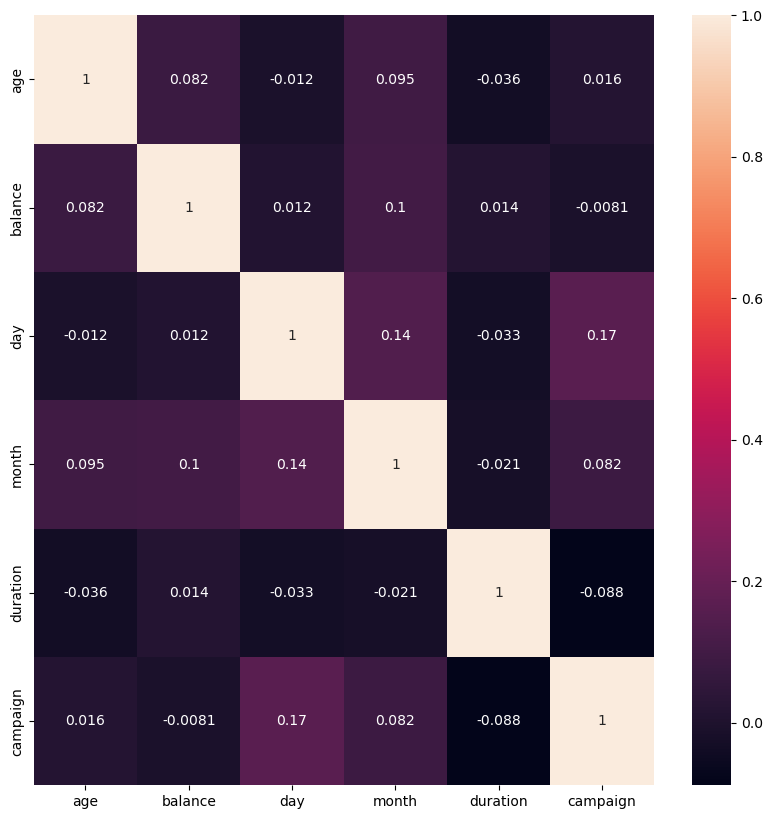

In [112]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)
plt.show();

In [113]:
data_og = data

In [114]:
data_og

age           job   marital  education default  balance housing loan  \
32971   47   blue-collar  divorced  secondary      no     3823     yes  yes   
1820    47   blue-collar   married    primary      no       94     yes   no   
16869   38  entrepreneur   married    primary      no       21     yes   no   
31489   58    management  divorced   tertiary      no      315     yes   no   
21295   60   blue-collar   married  secondary      no     5450      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
13195   57    technician   married    primary      no     4442      no   no   
38077   32    technician   married  secondary      no      344     yes  yes   
20134   55    technician   married  secondary      no      462      no   no   
7631    59       retired   married  secondary      no     8107      no   no   
8714    41         admin    single  secondary      no      400     yes   no   

        contact  day  month  duration  campaign   y  
32971  cellular   17      4       647         2  no  
1820    unknown    9      5       209         3  no  
16869  cellular   25      7        65         4  no  
31489  cellular    1      4       121         2  no  
21295  cellular   18      8       113         4  no  
...         ...  ...    ...       ...       ...  ..  
13195  cellular    8      7        97         6  no  
38077  cellular   14      5        54        11  no  
20134  cellular   11      8       116         2  no  
7631    unknown   30      5       210         1  no  
8714    unknown    4      6        99         6  no  

[40000 rows x 14 columns]

# Feature Engineering 

### Categorical Data

Categorical Features: job, marital, education, default, housing, loan, contact,y

In [115]:
label_encoding = LabelEncoder()
data['job'] = label_encoding.fit_transform(data['job'])
data['marital'] = label_encoding.fit_transform(data['marital'])
data['education'] = label_encoding.fit_transform(data['education'])
data['default'] = label_encoding.fit_transform(data['default'])
data['housing'] = label_encoding.fit_transform(data['housing'])
data['loan'] = label_encoding.fit_transform(data['loan'])
data['contact'] = label_encoding.fit_transform(data['contact'])
data['y'] = label_encoding.fit_transform(data['y'])

In [116]:
data.head()

age  job  marital  education  default  balance  housing  loan  contact  \
32971   47    1        0          1        0     3823        1     1        0   
1820    47    1        1          0        0       94        1     0        2   
16869   38    2        1          0        0       21        1     0        0   
31489   58    4        0          2        0      315        1     0        0   
21295   60    1        1          1        0     5450        0     0        0   

       day  month  duration  campaign  y  
32971   17      4       647         2  0  
1820     9      5       209         3  0  
16869   25      7        65         4  0  
31489    1      4       121         2  0  
21295   18      8       113         4  0

### Numerical Data 

SCALING: robust vs standard scaler

* robust uses IQR so would be less influenced by outliers


Numerical Features: age, day, month, duration

In [117]:
from sklearn.preprocessing import RobustScaler
data_robust = data

In [118]:
rs = RobustScaler()
rs_data = rs.fit_transform(data_robust)
rs_data = pd.DataFrame(rs_data)
rs_data.columns = data.columns
rs_data.head()

age       job  marital  education  default   balance  housing  loan  \
0  0.533333 -0.500000     -1.0        0.0      0.0  2.700395      0.0   1.0   
1  0.533333 -0.500000      0.0       -1.0      0.0 -0.247431      0.0   0.0   
2 -0.066667 -0.333333      0.0       -1.0      0.0 -0.305138      0.0   0.0   
3  1.266667  0.000000     -1.0        1.0      0.0 -0.072727      0.0   0.0   
4  1.400000 -0.500000      0.0        0.0      0.0  3.986561     -1.0   0.0   

   contact       day  month  duration  campaign    y  
0      0.0  0.000000   -1.0  2.215962       0.0  0.0  
1      1.0 -0.615385   -0.5  0.159624       0.5  0.0  
2      0.0  0.615385    0.5 -0.516432       1.0  0.0  
3      0.0 -1.230769   -1.0 -0.253521       0.0  0.0  
4      0.0  0.076923    1.0 -0.291080       1.0  0.0

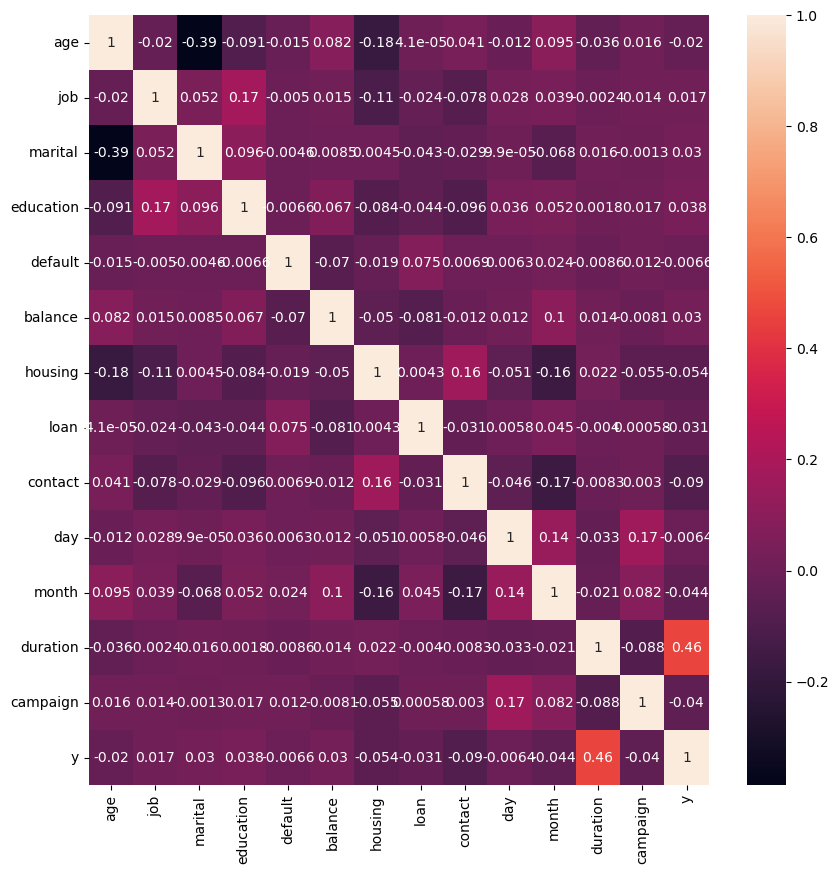

In [119]:
plt.figure(figsize=(10,10))
sns.heatmap(rs_data.corr(), annot=True)
plt.show();

In [120]:
from sklearn.preprocessing import StandardScaler

In [121]:
data_standard = data

In [122]:
ss = StandardScaler()
ss_data = ss.fit_transform(data_standard)
ss_data = pd.DataFrame(ss_data)
ss_data.columns = data.columns
ss_data.head()

age       job   marital  education   default   balance   housing  \
0  0.669532 -0.992362 -1.906098  -0.269608 -0.143675  0.877740  0.815179   
1  0.669532 -0.992362 -0.254510  -1.617983 -0.143675 -0.406469  0.815179   
2 -0.263917 -0.688520 -0.254510  -1.617983 -0.143675 -0.431609  0.815179   
3  1.810415 -0.080837 -1.906098   1.078768 -0.143675 -0.330360  0.815179   
4  2.017849 -0.992362 -0.254510  -0.269608 -0.143675  1.438053 -1.226725   

       loan   contact       day     month  duration  campaign         y  
0  2.184492 -0.755338  0.118721 -0.873421  1.512071 -0.272359 -0.279376  
1 -0.457772  1.414316 -0.847693 -0.438840 -0.176680  0.036377 -0.279376  
2 -0.457772 -0.755338  1.085135  0.430322 -0.731886  0.345113 -0.279376  
3 -0.457772 -0.755338 -1.814107 -0.873421 -0.515972 -0.272359 -0.279376  
4 -0.457772 -0.755338  0.239523  0.864904 -0.546817  0.345113 -0.279376

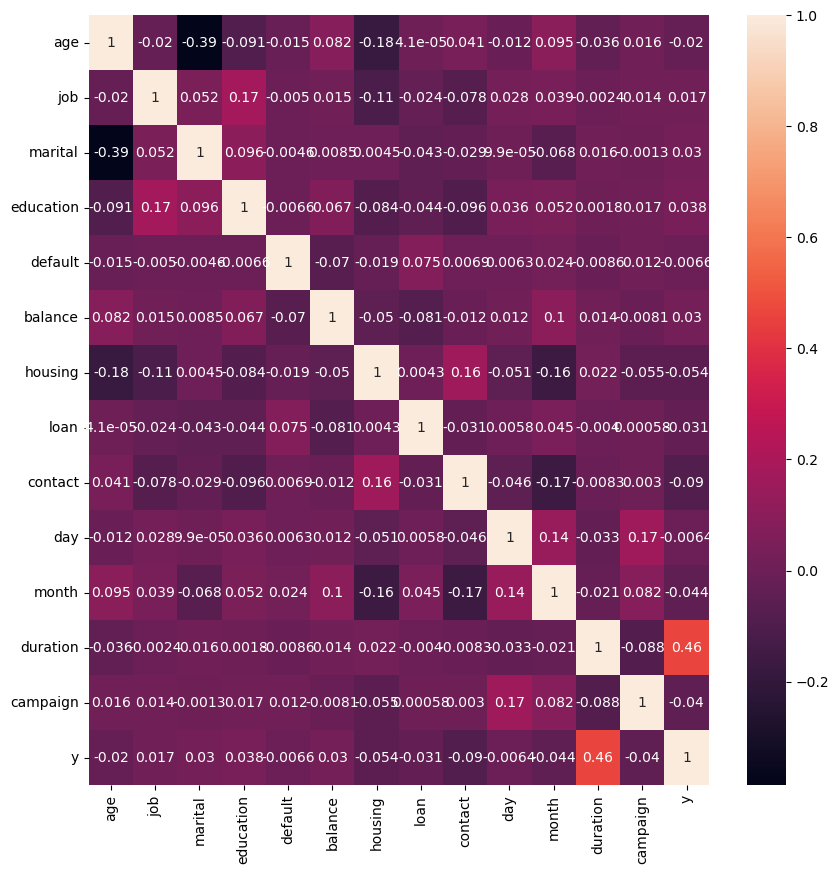

In [123]:
plt.figure(figsize=(10,10))
sns.heatmap(ss_data.corr(), annot=True)
plt.show();

# Train Test Split

In [124]:
X = data.drop('y', axis = 1)
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = 10)

In [125]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32000, 13) (32000,)
(8000, 13) (8000,)


In [126]:
print('Percentage of dataset in Class 0: ', data[data['y'] == 0].shape[0]/len(data)*100)
print('Percentage of dataset in Class 1: ', data[data['y'] == 1].shape[0]/len(data)*100)

Percentage of dataset in Class 0:  92.75999999999999
Percentage of dataset in Class 1:  7.24


In [127]:
print('Percentage of Class 0 in training set:', np.count_nonzero(y_train == 0)/len(y_train)*100)
print('Percentage of Class 1 in training set:', np.count_nonzero(y_train == 1)/len(y_train)*100)

Percentage of Class 0 in training set: 92.70625
Percentage of Class 1 in training set: 7.29375


In [128]:
print('Percentage of Class 0 in validation set:', np.count_nonzero(y_test == 0)/len(y_test)*100)
print('Percentage of Class 1 in validation set:', np.count_nonzero(y_test == 1)/len(y_test)*100)

Percentage of Class 0 in validation set: 92.975
Percentage of Class 1 in validation set: 7.025


### Scaled Data

In [129]:
X_rs = rs_data.drop('y', axis = 1)
y_rs = rs_data['y']

X_rs_train, X_rs_test, y_rs_train, y_rs_test = train_test_split(X_rs.values, y_rs.values, test_size = 0.2, random_state = 10)

In [130]:
X_ss = ss_data.drop('y', axis = 1)
y_ss = ss_data['y']

X_ss_train, X_ss_test, y_ss_train, y_ss_test = train_test_split(X_ss.values, y_ss.values, test_size = 0.2, random_state = 10)

# Classification Models 

1st attempt without scaling or stratefied sampling

## K Nearest Neighbors Classifier

In [131]:
base_knn = KNeighborsClassifier()
base_knn.fit(X_train, y_train)
y_pred = base_knn.predict(X_test)
training_score = base_knn.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
print('Micro F1 Score: ', f1_score(y_test, y_pred, average = 'micro'))

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



Accuracy Score:  0.930375
Training Set Score:  0.94215625
Macro F1 Score:  0.659633624928629
Weighted F1 Score:  0.9205471070576757
Micro F1 Score:  0.930375


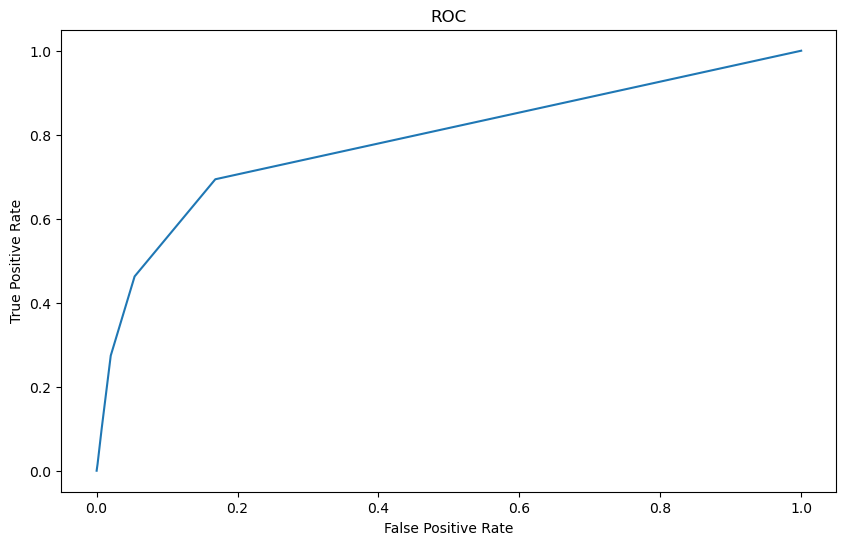

Area Under Curve:  0.7857712726510684


In [132]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = base_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

In [133]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      7438
           1       0.51      0.27      0.36       562

    accuracy                           0.93      8000
   macro avg       0.73      0.63      0.66      8000
weighted avg       0.92      0.93      0.92      8000



Using Scaled Dataset

In [134]:
rs_scaled_knn = KNeighborsClassifier()
rs_scaled_knn.fit(X_rs_train, y_rs_train)
y_pred = rs_scaled_knn.predict(X_test)
training_score = rs_scaled_knn.fit(X_rs_train, y_rs_train).score(X_rs_train, y_rs_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



Accuracy Score:  0.921
Training Set Score:  0.9495
Macro F1 Score:  0.47943779281624155
Weighted F1 Score:  0.8915145757418012


references: https://iopscience.iop.org/article/10.1088/1757-899X/719/1/012072/pdf

## Random Forest

In [135]:
base_rfc = RandomForestClassifier(random_state=10)
base_rfc.fit(X_train, y_train)
y_pred = base_rfc.predict(X_test)
training_score = base_rfc.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))

Accuracy Score:  0.93525
Training Set Score:  1.0
Macro F1 Score:  0.687884025416363
Weighted F1 Score:  0.9267057666740276


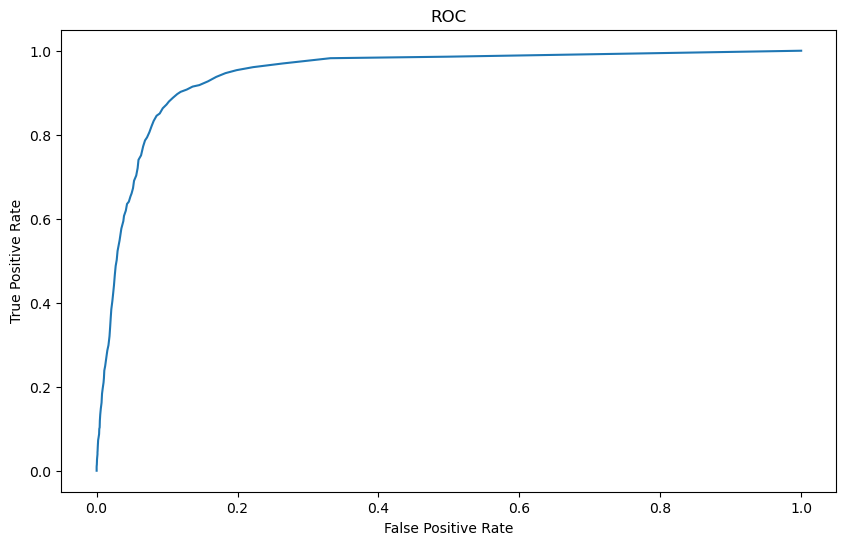

Area Under Curve:  0.9423639931141325


In [136]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = base_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

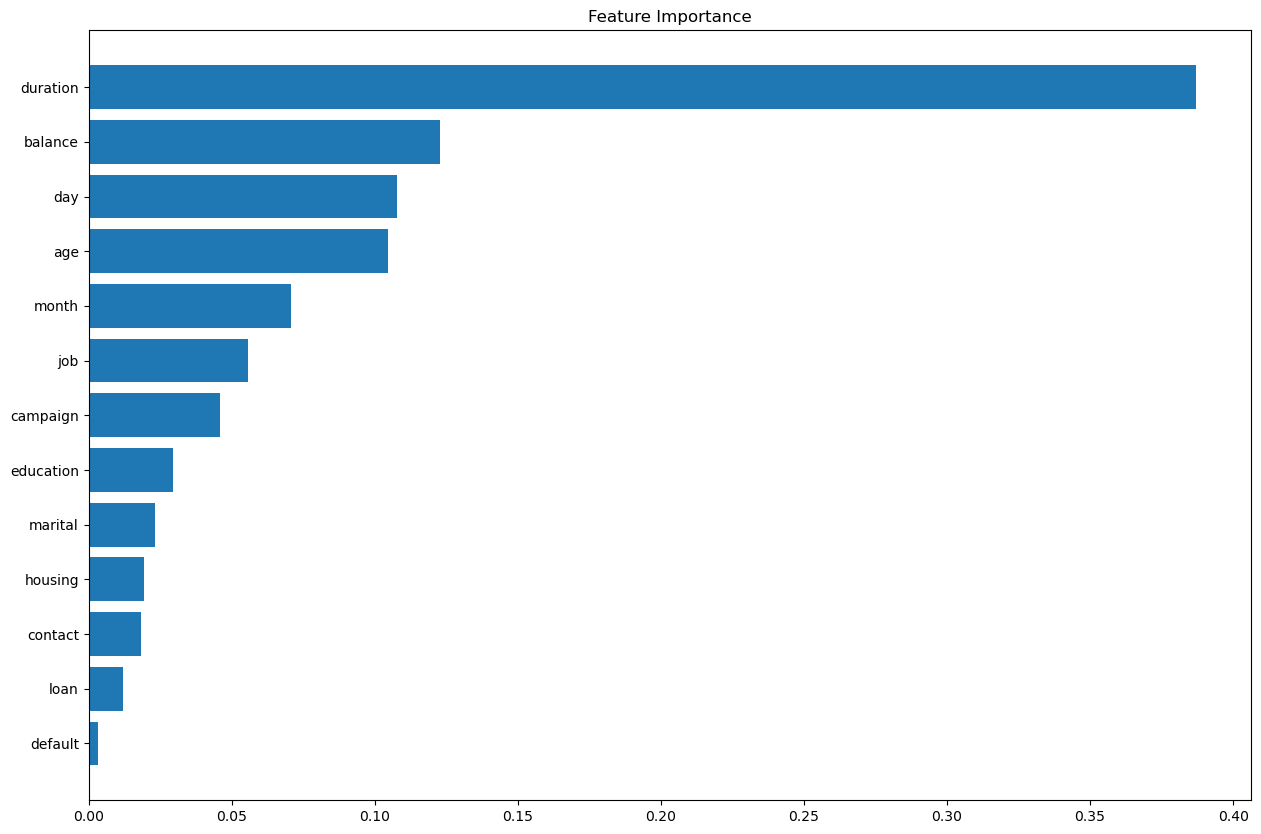

In [137]:
sorted_importances = base_rfc.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], base_rfc.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
_ = plt.savefig('rfc_feature_imp_grid.png', bbox_inches='tight')
plt.show()

## AdaBoosting 

Accuracy Score:  0.91575
Training Set Score:  1.0
Macro F1 Score:  0.6902168505027427
Weighted F1 Score:  0.9174020154519283


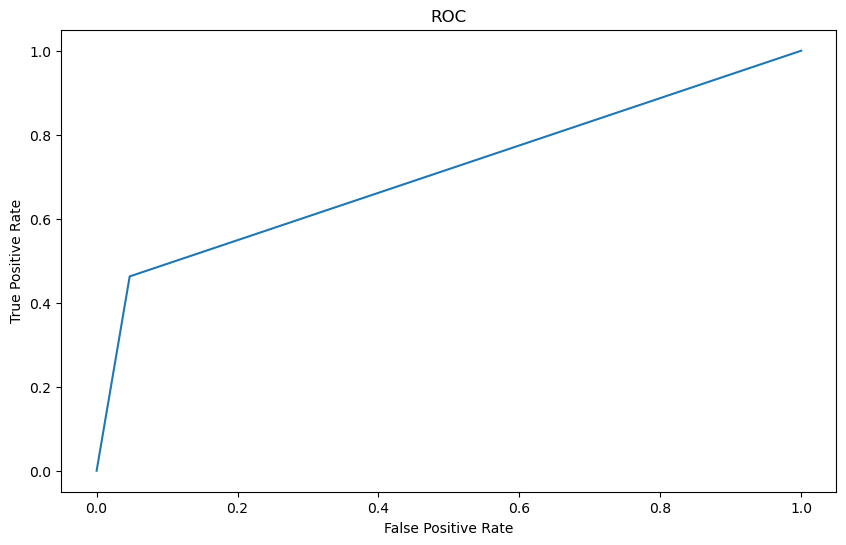

Area Under Curve:  0.7078561182884084


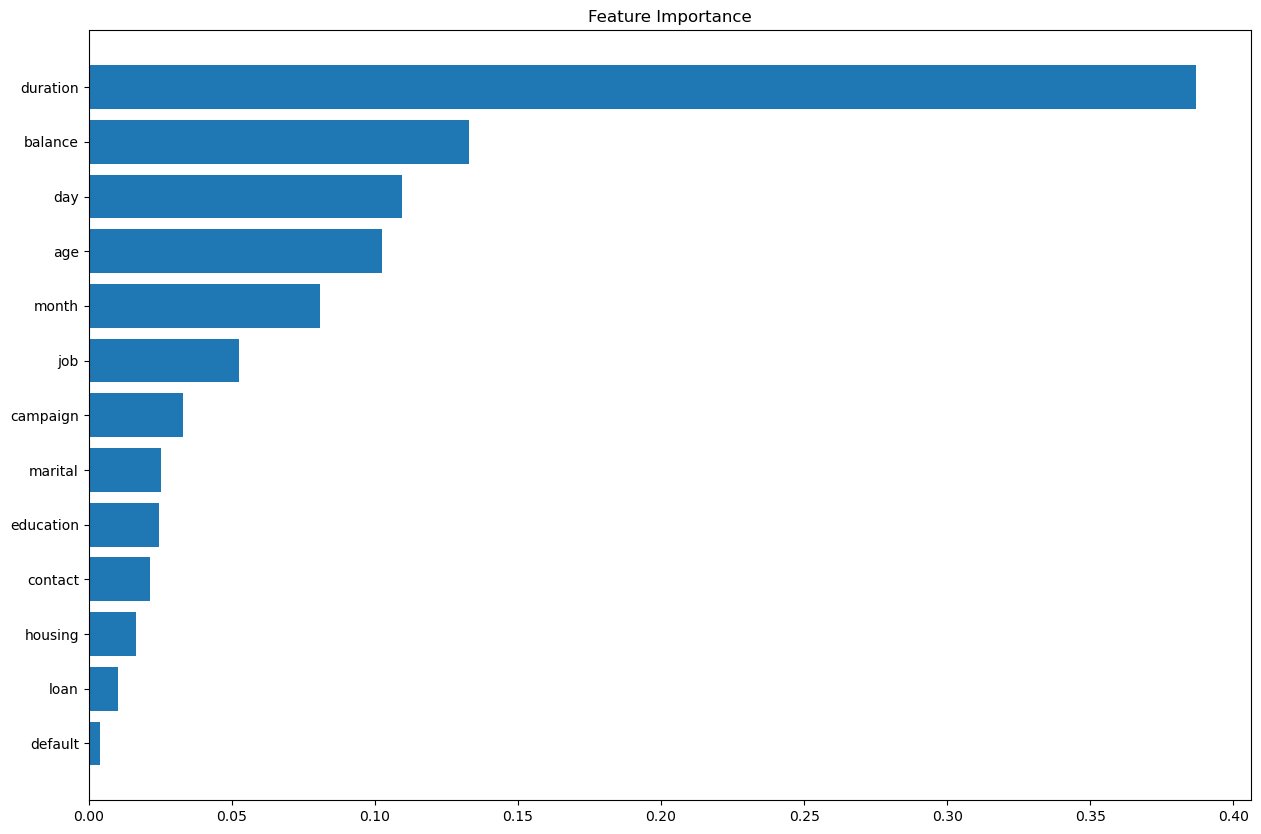

In [138]:
base_estimator = DecisionTreeClassifier(random_state=10)
base_adaboost = AdaBoostClassifier(base_estimator = base_estimator)
base_adaboost.fit(X_train, y_train)
y_pred = base_adaboost.predict(X_test)
training_score = base_adaboost.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = base_adaboost.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = base_adaboost.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], base_adaboost.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

## CatBoost

In [139]:
base_cb = CatBoostClassifier(random_state=10)
base_cb.fit(X_train, y_train)
y_pred = base_cb.predict(X_test)
training_score = base_cb.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))

Learning rate set to 0.045252
0:	learn: 0.6314336	total: 176ms	remaining: 2m 56s
1:	learn: 0.5683525	total: 192ms	remaining: 1m 36s
2:	learn: 0.5218223	total: 209ms	remaining: 1m 9s
3:	learn: 0.4730365	total: 223ms	remaining: 55.6s
4:	learn: 0.4345110	total: 241ms	remaining: 47.9s
5:	learn: 0.4019680	total: 257ms	remaining: 42.6s
6:	learn: 0.3726091	total: 274ms	remaining: 38.9s
7:	learn: 0.3508862	total: 293ms	remaining: 36.4s
8:	learn: 0.3294836	total: 314ms	remaining: 34.5s
9:	learn: 0.3087558	total: 336ms	remaining: 33.3s
10:	learn: 0.2930267	total: 359ms	remaining: 32.3s
11:	learn: 0.2801719	total: 380ms	remaining: 31.3s
12:	learn: 0.2681317	total: 418ms	remaining: 31.8s
13:	learn: 0.2582413	total: 463ms	remaining: 32.6s
14:	learn: 0.2448785	total: 489ms	remaining: 32.1s
15:	learn: 0.2362588	total: 521ms	remaining: 32s
16:	learn: 0.2273326	total: 544ms	remaining: 31.4s
17:	learn: 0.2210603	total: 567ms	remaining: 30.9s
18:	learn: 0.2164341	total: 590ms	remaining: 30.5s
19:	learn: 

160:	learn: 0.1312175	total: 4.84s	remaining: 25.2s
161:	learn: 0.1311559	total: 4.87s	remaining: 25.2s
162:	learn: 0.1310727	total: 4.89s	remaining: 25.1s
163:	learn: 0.1310109	total: 4.91s	remaining: 25s
164:	learn: 0.1308851	total: 4.93s	remaining: 25s
165:	learn: 0.1308218	total: 4.96s	remaining: 24.9s
166:	learn: 0.1307084	total: 4.98s	remaining: 24.8s
167:	learn: 0.1306223	total: 5s	remaining: 24.8s
168:	learn: 0.1304909	total: 5.03s	remaining: 24.7s
169:	learn: 0.1304129	total: 5.05s	remaining: 24.7s
170:	learn: 0.1303156	total: 5.08s	remaining: 24.6s
171:	learn: 0.1302749	total: 5.1s	remaining: 24.6s
172:	learn: 0.1301689	total: 5.13s	remaining: 24.5s
173:	learn: 0.1301162	total: 5.15s	remaining: 24.5s
174:	learn: 0.1300323	total: 5.18s	remaining: 24.4s
175:	learn: 0.1298279	total: 5.21s	remaining: 24.4s
176:	learn: 0.1296806	total: 5.23s	remaining: 24.3s
177:	learn: 0.1296109	total: 5.26s	remaining: 24.3s
178:	learn: 0.1295355	total: 5.29s	remaining: 24.3s
179:	learn: 0.129486

324:	learn: 0.1194987	total: 8.95s	remaining: 18.6s
325:	learn: 0.1194279	total: 8.98s	remaining: 18.6s
326:	learn: 0.1193799	total: 9s	remaining: 18.5s
327:	learn: 0.1193772	total: 9.03s	remaining: 18.5s
328:	learn: 0.1193447	total: 9.06s	remaining: 18.5s
329:	learn: 0.1192731	total: 9.11s	remaining: 18.5s
330:	learn: 0.1192001	total: 9.16s	remaining: 18.5s
331:	learn: 0.1191243	total: 9.19s	remaining: 18.5s
332:	learn: 0.1190922	total: 9.22s	remaining: 18.5s
333:	learn: 0.1190898	total: 9.24s	remaining: 18.4s
334:	learn: 0.1190218	total: 9.27s	remaining: 18.4s
335:	learn: 0.1189517	total: 9.31s	remaining: 18.4s
336:	learn: 0.1189494	total: 9.33s	remaining: 18.4s
337:	learn: 0.1189472	total: 9.35s	remaining: 18.3s
338:	learn: 0.1188571	total: 9.39s	remaining: 18.3s
339:	learn: 0.1187992	total: 9.42s	remaining: 18.3s
340:	learn: 0.1187271	total: 9.44s	remaining: 18.2s
341:	learn: 0.1186387	total: 9.48s	remaining: 18.2s
342:	learn: 0.1185644	total: 9.52s	remaining: 18.2s
343:	learn: 0.1

490:	learn: 0.1111479	total: 13.3s	remaining: 13.8s
491:	learn: 0.1111466	total: 13.4s	remaining: 13.8s
492:	learn: 0.1110931	total: 13.4s	remaining: 13.8s
493:	learn: 0.1110449	total: 13.4s	remaining: 13.7s
494:	learn: 0.1109952	total: 13.4s	remaining: 13.7s
495:	learn: 0.1109940	total: 13.5s	remaining: 13.7s
496:	learn: 0.1109618	total: 13.5s	remaining: 13.6s
497:	learn: 0.1109606	total: 13.5s	remaining: 13.6s
498:	learn: 0.1109383	total: 13.5s	remaining: 13.6s
499:	learn: 0.1108818	total: 13.5s	remaining: 13.5s
500:	learn: 0.1107726	total: 13.6s	remaining: 13.5s
501:	learn: 0.1107234	total: 13.6s	remaining: 13.5s
502:	learn: 0.1106817	total: 13.6s	remaining: 13.5s
503:	learn: 0.1106300	total: 13.6s	remaining: 13.4s
504:	learn: 0.1105838	total: 13.7s	remaining: 13.4s
505:	learn: 0.1105462	total: 13.7s	remaining: 13.4s
506:	learn: 0.1105253	total: 13.7s	remaining: 13.3s
507:	learn: 0.1105243	total: 13.7s	remaining: 13.3s
508:	learn: 0.1104674	total: 13.8s	remaining: 13.3s
509:	learn: 

655:	learn: 0.1043611	total: 17.3s	remaining: 9.05s
656:	learn: 0.1043132	total: 17.3s	remaining: 9.02s
657:	learn: 0.1042569	total: 17.3s	remaining: 8.99s
658:	learn: 0.1042231	total: 17.3s	remaining: 8.96s
659:	learn: 0.1041782	total: 17.3s	remaining: 8.93s
660:	learn: 0.1041467	total: 17.4s	remaining: 8.9s
661:	learn: 0.1041096	total: 17.4s	remaining: 8.87s
662:	learn: 0.1040782	total: 17.4s	remaining: 8.85s
663:	learn: 0.1040441	total: 17.4s	remaining: 8.82s
664:	learn: 0.1040080	total: 17.4s	remaining: 8.79s
665:	learn: 0.1039652	total: 17.5s	remaining: 8.76s
666:	learn: 0.1039310	total: 17.5s	remaining: 8.74s
667:	learn: 0.1038703	total: 17.5s	remaining: 8.71s
668:	learn: 0.1038300	total: 17.6s	remaining: 8.68s
669:	learn: 0.1038121	total: 17.6s	remaining: 8.66s
670:	learn: 0.1037925	total: 17.6s	remaining: 8.63s
671:	learn: 0.1037483	total: 17.6s	remaining: 8.61s
672:	learn: 0.1037144	total: 17.7s	remaining: 8.58s
673:	learn: 0.1036859	total: 17.7s	remaining: 8.55s
674:	learn: 0

820:	learn: 0.0983120	total: 21.2s	remaining: 4.62s
821:	learn: 0.0982803	total: 21.2s	remaining: 4.59s
822:	learn: 0.0982178	total: 21.2s	remaining: 4.57s
823:	learn: 0.0982022	total: 21.3s	remaining: 4.54s
824:	learn: 0.0981778	total: 21.3s	remaining: 4.51s
825:	learn: 0.0981246	total: 21.3s	remaining: 4.49s
826:	learn: 0.0980832	total: 21.3s	remaining: 4.46s
827:	learn: 0.0980703	total: 21.3s	remaining: 4.43s
828:	learn: 0.0980433	total: 21.4s	remaining: 4.41s
829:	learn: 0.0980308	total: 21.4s	remaining: 4.38s
830:	learn: 0.0979857	total: 21.4s	remaining: 4.36s
831:	learn: 0.0979614	total: 21.4s	remaining: 4.33s
832:	learn: 0.0979134	total: 21.5s	remaining: 4.3s
833:	learn: 0.0978765	total: 21.5s	remaining: 4.28s
834:	learn: 0.0978481	total: 21.5s	remaining: 4.25s
835:	learn: 0.0978131	total: 21.5s	remaining: 4.23s
836:	learn: 0.0977752	total: 21.6s	remaining: 4.2s
837:	learn: 0.0977372	total: 21.6s	remaining: 4.17s
838:	learn: 0.0976912	total: 21.6s	remaining: 4.15s
839:	learn: 0.

979:	learn: 0.0929318	total: 24.9s	remaining: 507ms
980:	learn: 0.0929032	total: 24.9s	remaining: 482ms
981:	learn: 0.0928577	total: 24.9s	remaining: 457ms
982:	learn: 0.0928206	total: 24.9s	remaining: 431ms
983:	learn: 0.0927835	total: 25s	remaining: 406ms
984:	learn: 0.0927482	total: 25s	remaining: 380ms
985:	learn: 0.0927295	total: 25s	remaining: 355ms
986:	learn: 0.0926991	total: 25s	remaining: 330ms
987:	learn: 0.0926664	total: 25s	remaining: 304ms
988:	learn: 0.0926525	total: 25.1s	remaining: 279ms
989:	learn: 0.0926222	total: 25.1s	remaining: 253ms
990:	learn: 0.0925823	total: 25.1s	remaining: 228ms
991:	learn: 0.0925476	total: 25.1s	remaining: 203ms
992:	learn: 0.0924951	total: 25.1s	remaining: 177ms
993:	learn: 0.0924702	total: 25.2s	remaining: 152ms
994:	learn: 0.0924265	total: 25.2s	remaining: 127ms
995:	learn: 0.0924072	total: 25.2s	remaining: 101ms
996:	learn: 0.0923811	total: 25.2s	remaining: 75.9ms
997:	learn: 0.0923388	total: 25.2s	remaining: 50.6ms
998:	learn: 0.092297

147:	learn: 0.1325258	total: 3.22s	remaining: 18.5s
148:	learn: 0.1324760	total: 3.24s	remaining: 18.5s
149:	learn: 0.1323728	total: 3.26s	remaining: 18.5s
150:	learn: 0.1322708	total: 3.28s	remaining: 18.5s
151:	learn: 0.1321693	total: 3.3s	remaining: 18.4s
152:	learn: 0.1320822	total: 3.33s	remaining: 18.4s
153:	learn: 0.1319214	total: 3.35s	remaining: 18.4s
154:	learn: 0.1317993	total: 3.37s	remaining: 18.4s
155:	learn: 0.1316712	total: 3.39s	remaining: 18.3s
156:	learn: 0.1316231	total: 3.41s	remaining: 18.3s
157:	learn: 0.1315428	total: 3.44s	remaining: 18.3s
158:	learn: 0.1314582	total: 3.46s	remaining: 18.3s
159:	learn: 0.1313992	total: 3.49s	remaining: 18.3s
160:	learn: 0.1312175	total: 3.51s	remaining: 18.3s
161:	learn: 0.1311559	total: 3.54s	remaining: 18.3s
162:	learn: 0.1310727	total: 3.56s	remaining: 18.3s
163:	learn: 0.1310109	total: 3.58s	remaining: 18.3s
164:	learn: 0.1308851	total: 3.6s	remaining: 18.2s
165:	learn: 0.1308218	total: 3.63s	remaining: 18.2s
166:	learn: 0.

307:	learn: 0.1205045	total: 7.12s	remaining: 16s
308:	learn: 0.1204516	total: 7.14s	remaining: 16s
309:	learn: 0.1204000	total: 7.16s	remaining: 15.9s
310:	learn: 0.1203554	total: 7.18s	remaining: 15.9s
311:	learn: 0.1202759	total: 7.2s	remaining: 15.9s
312:	learn: 0.1202728	total: 7.22s	remaining: 15.8s
313:	learn: 0.1202300	total: 7.24s	remaining: 15.8s
314:	learn: 0.1201870	total: 7.27s	remaining: 15.8s
315:	learn: 0.1201842	total: 7.29s	remaining: 15.8s
316:	learn: 0.1201441	total: 7.32s	remaining: 15.8s
317:	learn: 0.1200669	total: 7.34s	remaining: 15.7s
318:	learn: 0.1199230	total: 7.37s	remaining: 15.7s
319:	learn: 0.1198588	total: 7.39s	remaining: 15.7s
320:	learn: 0.1197894	total: 7.42s	remaining: 15.7s
321:	learn: 0.1197090	total: 7.44s	remaining: 15.7s
322:	learn: 0.1196195	total: 7.46s	remaining: 15.6s
323:	learn: 0.1195359	total: 7.49s	remaining: 15.6s
324:	learn: 0.1194987	total: 7.51s	remaining: 15.6s
325:	learn: 0.1194279	total: 7.53s	remaining: 15.6s
326:	learn: 0.119

468:	learn: 0.1120370	total: 10.6s	remaining: 12s
469:	learn: 0.1120144	total: 10.6s	remaining: 12s
470:	learn: 0.1119802	total: 10.7s	remaining: 12s
471:	learn: 0.1119177	total: 10.7s	remaining: 11.9s
472:	learn: 0.1118970	total: 10.7s	remaining: 11.9s
473:	learn: 0.1118316	total: 10.7s	remaining: 11.9s
474:	learn: 0.1117550	total: 10.7s	remaining: 11.9s
475:	learn: 0.1117202	total: 10.8s	remaining: 11.9s
476:	learn: 0.1116883	total: 10.8s	remaining: 11.8s
477:	learn: 0.1116268	total: 10.8s	remaining: 11.8s
478:	learn: 0.1115728	total: 10.9s	remaining: 11.8s
479:	learn: 0.1115599	total: 10.9s	remaining: 11.8s
480:	learn: 0.1115105	total: 10.9s	remaining: 11.8s
481:	learn: 0.1115091	total: 10.9s	remaining: 11.8s
482:	learn: 0.1114776	total: 11s	remaining: 11.7s
483:	learn: 0.1114373	total: 11s	remaining: 11.7s
484:	learn: 0.1114078	total: 11s	remaining: 11.7s
485:	learn: 0.1113570	total: 11s	remaining: 11.7s
486:	learn: 0.1113095	total: 11.1s	remaining: 11.6s
487:	learn: 0.1112547	tota

630:	learn: 0.1053267	total: 15.3s	remaining: 8.92s
631:	learn: 0.1052983	total: 15.3s	remaining: 8.9s
632:	learn: 0.1052481	total: 15.3s	remaining: 8.89s
633:	learn: 0.1052150	total: 15.4s	remaining: 8.87s
634:	learn: 0.1051738	total: 15.4s	remaining: 8.86s
635:	learn: 0.1051479	total: 15.4s	remaining: 8.83s
636:	learn: 0.1051220	total: 15.5s	remaining: 8.81s
637:	learn: 0.1050982	total: 15.5s	remaining: 8.79s
638:	learn: 0.1050565	total: 15.5s	remaining: 8.78s
639:	learn: 0.1050167	total: 15.6s	remaining: 8.75s
640:	learn: 0.1049831	total: 15.6s	remaining: 8.73s
641:	learn: 0.1049496	total: 15.6s	remaining: 8.7s
642:	learn: 0.1049151	total: 15.6s	remaining: 8.68s
643:	learn: 0.1048972	total: 15.7s	remaining: 8.66s
644:	learn: 0.1048519	total: 15.7s	remaining: 8.64s
645:	learn: 0.1048302	total: 15.7s	remaining: 8.62s
646:	learn: 0.1047865	total: 15.8s	remaining: 8.59s
647:	learn: 0.1047475	total: 15.8s	remaining: 8.57s
648:	learn: 0.1047162	total: 15.8s	remaining: 8.55s
649:	learn: 0.

790:	learn: 0.0994512	total: 19.4s	remaining: 5.13s
791:	learn: 0.0994283	total: 19.5s	remaining: 5.11s
792:	learn: 0.0993670	total: 19.5s	remaining: 5.09s
793:	learn: 0.0993246	total: 19.5s	remaining: 5.06s
794:	learn: 0.0992969	total: 19.5s	remaining: 5.04s
795:	learn: 0.0992671	total: 19.6s	remaining: 5.01s
796:	learn: 0.0992184	total: 19.6s	remaining: 4.99s
797:	learn: 0.0991918	total: 19.6s	remaining: 4.96s
798:	learn: 0.0991414	total: 19.6s	remaining: 4.93s
799:	learn: 0.0990952	total: 19.6s	remaining: 4.91s
800:	learn: 0.0990533	total: 19.7s	remaining: 4.88s
801:	learn: 0.0990244	total: 19.7s	remaining: 4.86s
802:	learn: 0.0989972	total: 19.7s	remaining: 4.83s
803:	learn: 0.0989638	total: 19.7s	remaining: 4.81s
804:	learn: 0.0989370	total: 19.7s	remaining: 4.78s
805:	learn: 0.0988942	total: 19.8s	remaining: 4.75s
806:	learn: 0.0988172	total: 19.8s	remaining: 4.73s
807:	learn: 0.0987821	total: 19.8s	remaining: 4.7s
808:	learn: 0.0987477	total: 19.8s	remaining: 4.68s
809:	learn: 0

949:	learn: 0.0939948	total: 23s	remaining: 1.21s
950:	learn: 0.0939389	total: 23s	remaining: 1.19s
951:	learn: 0.0939133	total: 23s	remaining: 1.16s
952:	learn: 0.0938613	total: 23s	remaining: 1.14s
953:	learn: 0.0938075	total: 23.1s	remaining: 1.11s
954:	learn: 0.0937828	total: 23.1s	remaining: 1.09s
955:	learn: 0.0937567	total: 23.1s	remaining: 1.06s
956:	learn: 0.0937051	total: 23.1s	remaining: 1.04s
957:	learn: 0.0936820	total: 23.1s	remaining: 1.01s
958:	learn: 0.0936576	total: 23.2s	remaining: 991ms
959:	learn: 0.0936213	total: 23.2s	remaining: 966ms
960:	learn: 0.0935573	total: 23.2s	remaining: 942ms
961:	learn: 0.0935474	total: 23.2s	remaining: 918ms
962:	learn: 0.0934920	total: 23.3s	remaining: 893ms
963:	learn: 0.0934685	total: 23.3s	remaining: 869ms
964:	learn: 0.0934327	total: 23.3s	remaining: 845ms
965:	learn: 0.0933802	total: 23.3s	remaining: 821ms
966:	learn: 0.0933508	total: 23.3s	remaining: 796ms
967:	learn: 0.0933379	total: 23.4s	remaining: 772ms
968:	learn: 0.093319

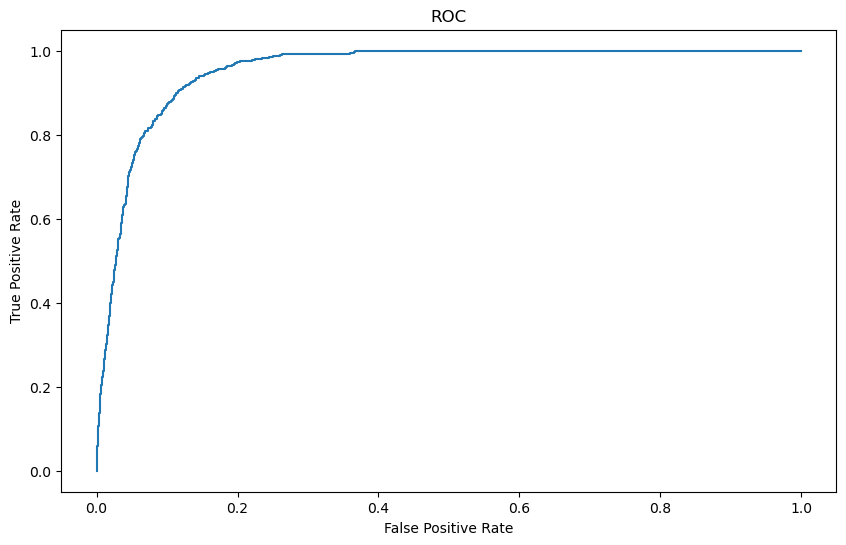

Area Under Curve:  0.9538266036004397


In [140]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = base_cb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

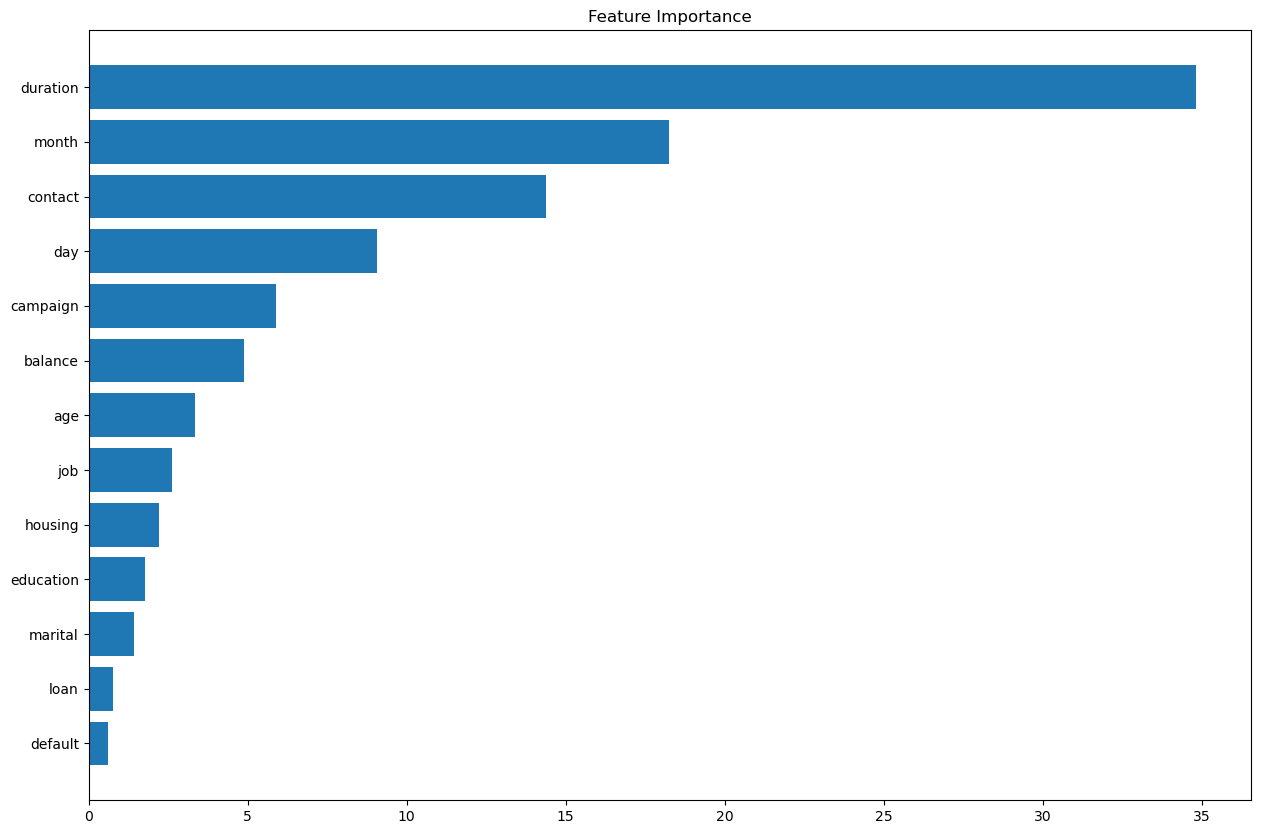

In [141]:
sorted_importances = base_cb.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], base_cb.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

## HistGradBoost

In [142]:
base_histgradboost = HistGradientBoostingClassifier(random_state=10)
base_histgradboost.fit(X_train, y_train)
y_pred = base_histgradboost.predict(X_test)
training_score = base_histgradboost.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))

Accuracy Score:  0.939
Training Set Score:  0.94896875
Macro F1 Score:  0.7214433004402394
Weighted F1 Score:  0.9330302687815284


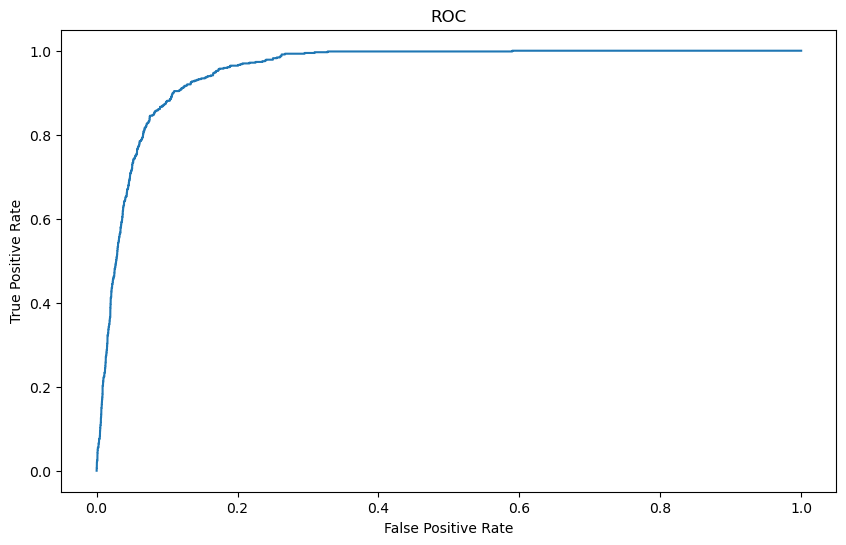

Area Under Curve:  0.9533968349506574


In [143]:
y_pred_prob = base_histgradboost.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

## LightGBM 

Accuracy Score:  0.939625
Training Set Score:  0.9594375
Macro F1 Score:  0.7382417255018745
Weighted F1 Score:  0.9355783929450997


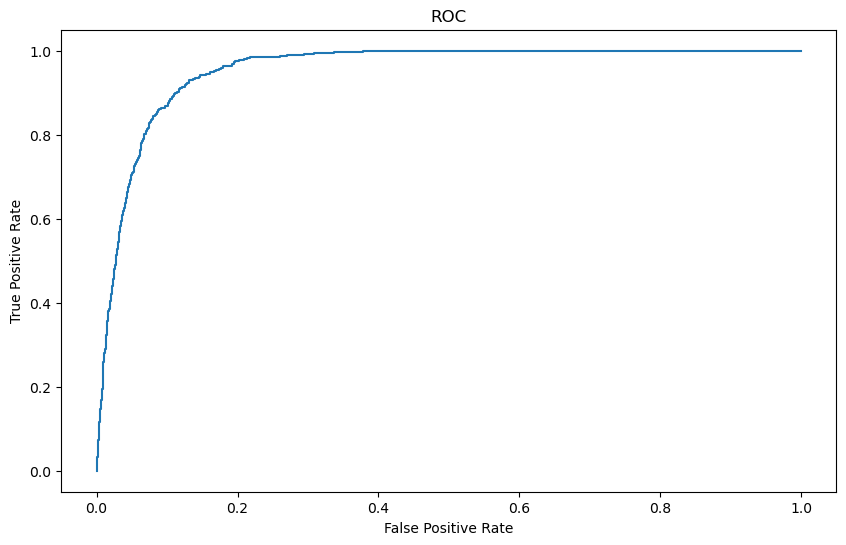

Area Under Curve:  0.9539452594592164


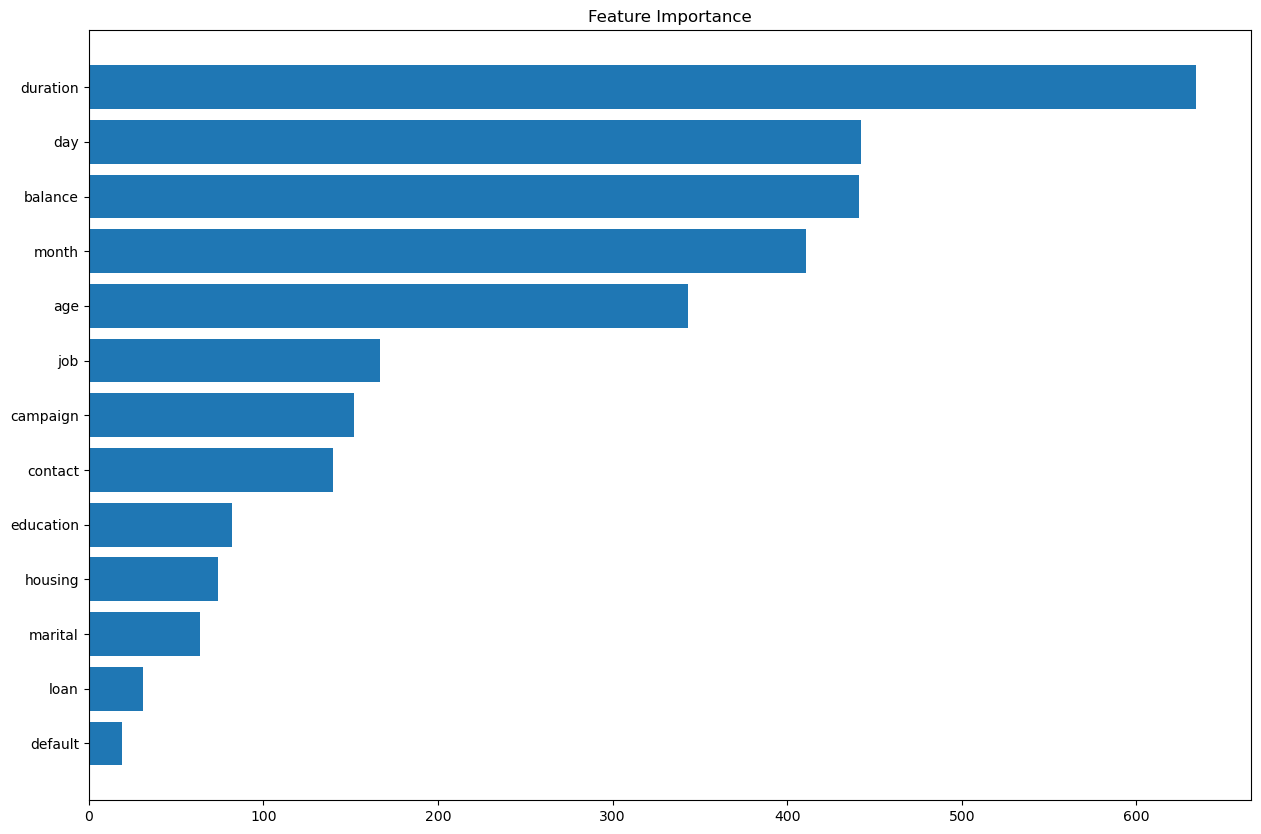

In [144]:
base_lgbm = LGBMClassifier(random_state=10)
base_lgbm.fit(X_train, y_train)
y_pred = base_lgbm.predict(X_test)
training_score = base_lgbm.fit(X_train, y_train).score(X_train, y_train)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
y_pred_prob = base_lgbm.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = base_lgbm.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], base_lgbm.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

References: 
https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/
https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956
https://www.projectpro.io/recipes/use-catboost-classifier-and-regressor-in-python
https://www.kaggle.com/code/prashant111/catboost-classifier-in-python


# Sampling Methods

RandomOverSampler VS SMOTE

## SMOTE

In [145]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [146]:
smt = SMOTE()

In [147]:
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

In [148]:
counter = Counter(y_train)
print(counter)

Counter({0: 29666, 1: 2334})


In [149]:
counter = Counter(y_train_sm)
print(counter)

Counter({0: 29666, 1: 29666})


### KNN

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



Accuracy Score:  0.8115
Training Set Score:  0.9238016584642351
Macro F1 Score:  0.6062383542643237
Weighted F1 Score:  0.8505906873804092


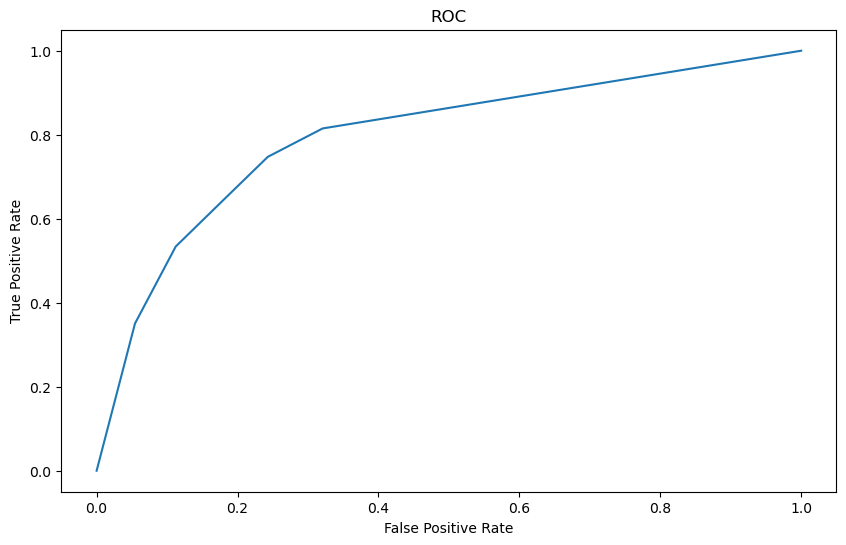

Area Under Curve:  0.7960029482153299


In [150]:
sm_knn = KNeighborsClassifier()
sm_knn.fit(X_train_sm, y_train_sm)
y_pred = sm_knn.predict(X_test)
training_score = sm_knn.fit(X_train_sm, y_train_sm).score(X_train_sm, y_train_sm)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = sm_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)

### Random Forest Classifier 

Accuracy Score:  0.93525
Training Set Score:  1.0
Macro F1 Score:  0.687884025416363
Weighted F1 Score:  0.9267057666740276


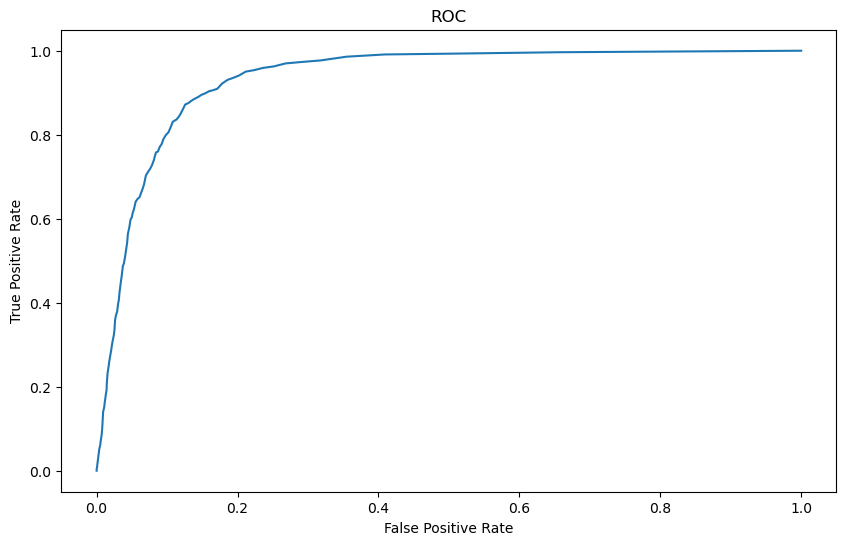

Area Under Curve:  0.9331083576785173


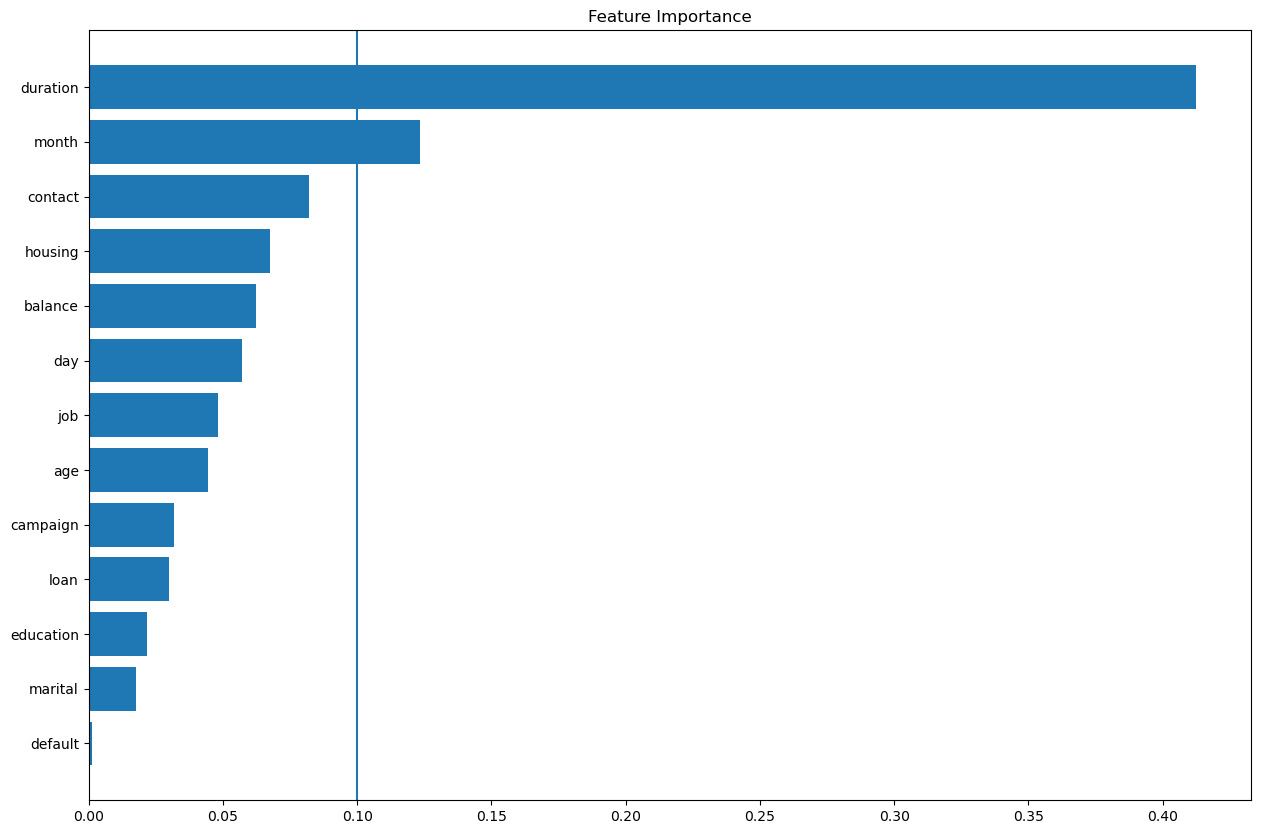

In [151]:
sm_rfc = RandomForestClassifier(random_state=10)
sm_rfc.fit(X_train_sm, y_train_sm)
y_pred = base_rfc.predict(X_test)
training_score = base_rfc.fit(X_train_sm, y_train_sm).score(X_train_sm, y_train_sm)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = sm_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = sm_rfc.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], sm_rfc.feature_importances_[sorted_importances])
_ = plt.axvline(x=0.10)
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

### ADABoost

Accuracy Score:  0.89675
Training Set Score:  1.0
Macro F1 Score:  0.6844340605676482
Weighted F1 Score:  0.906909586251411


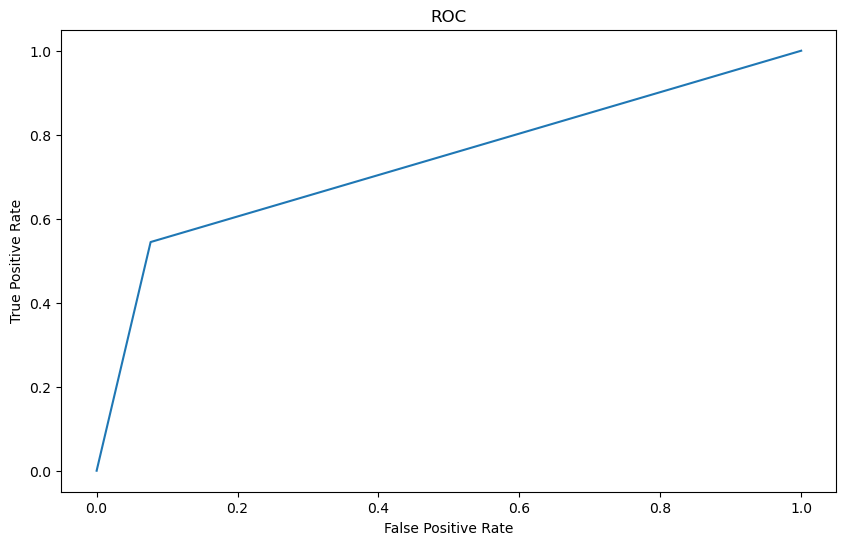

Area Under Curve:  0.7339252410675583


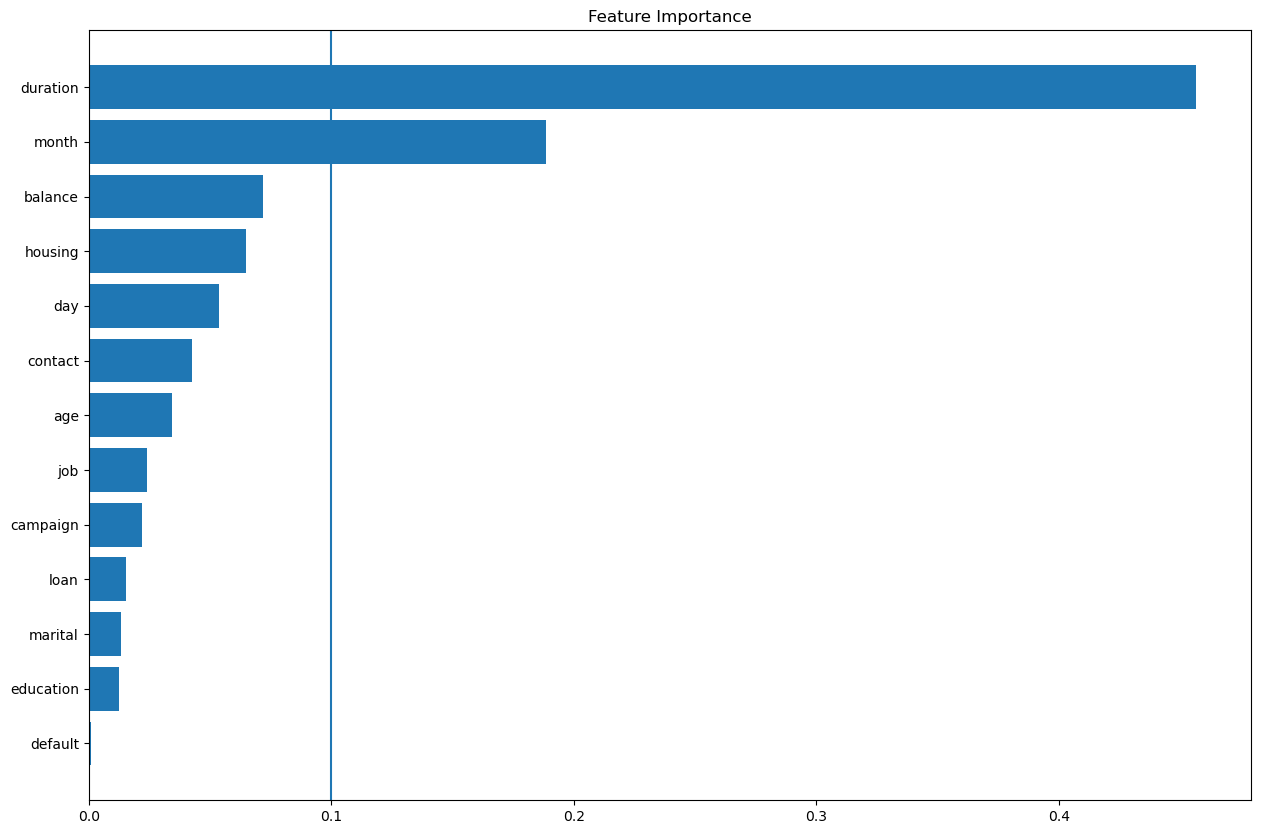

In [152]:
base_estimator = DecisionTreeClassifier(random_state=10)
sm_adaboost = AdaBoostClassifier(base_estimator = base_estimator)
sm_adaboost.fit(X_train_sm, y_train_sm)
y_pred = sm_adaboost.predict(X_test)
training_score = base_adaboost.fit(X_train_sm, y_train_sm).score(X_train_sm, y_train_sm)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = sm_adaboost.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = sm_adaboost.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], sm_adaboost.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
_ = plt.axvline(x=0.10)
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

## CatBoost

Learning rate set to 0.058902
0:	learn: 0.6223362	total: 21.9ms	remaining: 21.9s
1:	learn: 0.5673296	total: 39.8ms	remaining: 19.9s
2:	learn: 0.5271293	total: 58.2ms	remaining: 19.3s
3:	learn: 0.4950711	total: 76.5ms	remaining: 19.1s
4:	learn: 0.4675523	total: 98.2ms	remaining: 19.5s
5:	learn: 0.4390194	total: 120ms	remaining: 19.8s
6:	learn: 0.4184017	total: 144ms	remaining: 20.4s
7:	learn: 0.4018472	total: 168ms	remaining: 20.9s
8:	learn: 0.3875250	total: 193ms	remaining: 21.2s
9:	learn: 0.3740843	total: 220ms	remaining: 21.7s
10:	learn: 0.3611498	total: 250ms	remaining: 22.5s
11:	learn: 0.3505990	total: 286ms	remaining: 23.6s
12:	learn: 0.3393135	total: 329ms	remaining: 24.9s
13:	learn: 0.3292547	total: 362ms	remaining: 25.5s
14:	learn: 0.3195173	total: 397ms	remaining: 26.1s
15:	learn: 0.3123144	total: 429ms	remaining: 26.4s
16:	learn: 0.3049909	total: 465ms	remaining: 26.9s
17:	learn: 0.2996521	total: 498ms	remaining: 27.2s
18:	learn: 0.2930399	total: 544ms	remaining: 28.1s
19:	le

163:	learn: 0.1695351	total: 6.36s	remaining: 32.4s
164:	learn: 0.1693602	total: 6.39s	remaining: 32.4s
165:	learn: 0.1690135	total: 6.43s	remaining: 32.3s
166:	learn: 0.1686493	total: 6.47s	remaining: 32.3s
167:	learn: 0.1685026	total: 6.5s	remaining: 32.2s
168:	learn: 0.1683022	total: 6.54s	remaining: 32.2s
169:	learn: 0.1680296	total: 6.58s	remaining: 32.1s
170:	learn: 0.1677631	total: 6.62s	remaining: 32.1s
171:	learn: 0.1675200	total: 6.65s	remaining: 32s
172:	learn: 0.1673076	total: 6.69s	remaining: 32s
173:	learn: 0.1667879	total: 6.73s	remaining: 32s
174:	learn: 0.1665580	total: 6.77s	remaining: 31.9s
175:	learn: 0.1663576	total: 6.8s	remaining: 31.9s
176:	learn: 0.1662124	total: 6.87s	remaining: 31.9s
177:	learn: 0.1660689	total: 6.92s	remaining: 31.9s
178:	learn: 0.1658747	total: 6.96s	remaining: 31.9s
179:	learn: 0.1657825	total: 7.01s	remaining: 31.9s
180:	learn: 0.1656687	total: 7.06s	remaining: 31.9s
181:	learn: 0.1655309	total: 7.11s	remaining: 32s
182:	learn: 0.1654128	

322:	learn: 0.1447896	total: 12.2s	remaining: 25.5s
323:	learn: 0.1446554	total: 12.2s	remaining: 25.5s
324:	learn: 0.1445964	total: 12.2s	remaining: 25.4s
325:	learn: 0.1444682	total: 12.3s	remaining: 25.4s
326:	learn: 0.1443898	total: 12.3s	remaining: 25.3s
327:	learn: 0.1443008	total: 12.3s	remaining: 25.3s
328:	learn: 0.1442270	total: 12.4s	remaining: 25.2s
329:	learn: 0.1440304	total: 12.4s	remaining: 25.2s
330:	learn: 0.1439447	total: 12.4s	remaining: 25.1s
331:	learn: 0.1438279	total: 12.5s	remaining: 25.1s
332:	learn: 0.1437004	total: 12.5s	remaining: 25s
333:	learn: 0.1436076	total: 12.5s	remaining: 25s
334:	learn: 0.1434789	total: 12.6s	remaining: 24.9s
335:	learn: 0.1433622	total: 12.6s	remaining: 24.9s
336:	learn: 0.1433597	total: 12.6s	remaining: 24.8s
337:	learn: 0.1432480	total: 12.7s	remaining: 24.8s
338:	learn: 0.1430799	total: 12.7s	remaining: 24.7s
339:	learn: 0.1429573	total: 12.7s	remaining: 24.7s
340:	learn: 0.1428438	total: 12.7s	remaining: 24.6s
341:	learn: 0.14

485:	learn: 0.1306511	total: 17.3s	remaining: 18.3s
486:	learn: 0.1305724	total: 17.3s	remaining: 18.2s
487:	learn: 0.1305021	total: 17.4s	remaining: 18.2s
488:	learn: 0.1304165	total: 17.4s	remaining: 18.2s
489:	learn: 0.1303689	total: 17.4s	remaining: 18.1s
490:	learn: 0.1302985	total: 17.5s	remaining: 18.1s
491:	learn: 0.1302428	total: 17.5s	remaining: 18s
492:	learn: 0.1301471	total: 17.5s	remaining: 18s
493:	learn: 0.1300494	total: 17.6s	remaining: 18s
494:	learn: 0.1299944	total: 17.6s	remaining: 17.9s
495:	learn: 0.1299232	total: 17.6s	remaining: 17.9s
496:	learn: 0.1298094	total: 17.6s	remaining: 17.8s
497:	learn: 0.1296971	total: 17.7s	remaining: 17.8s
498:	learn: 0.1296261	total: 17.7s	remaining: 17.8s
499:	learn: 0.1295470	total: 17.7s	remaining: 17.7s
500:	learn: 0.1295018	total: 17.8s	remaining: 17.7s
501:	learn: 0.1294535	total: 17.8s	remaining: 17.6s
502:	learn: 0.1293889	total: 17.8s	remaining: 17.6s
503:	learn: 0.1293149	total: 17.9s	remaining: 17.6s
504:	learn: 0.1292

648:	learn: 0.1200344	total: 22.1s	remaining: 11.9s
649:	learn: 0.1199743	total: 22.1s	remaining: 11.9s
650:	learn: 0.1199293	total: 22.1s	remaining: 11.9s
651:	learn: 0.1198848	total: 22.2s	remaining: 11.8s
652:	learn: 0.1198498	total: 22.2s	remaining: 11.8s
653:	learn: 0.1198088	total: 22.2s	remaining: 11.8s
654:	learn: 0.1197430	total: 22.3s	remaining: 11.7s
655:	learn: 0.1196608	total: 22.3s	remaining: 11.7s
656:	learn: 0.1196056	total: 22.3s	remaining: 11.7s
657:	learn: 0.1195589	total: 22.4s	remaining: 11.6s
658:	learn: 0.1194857	total: 22.4s	remaining: 11.6s
659:	learn: 0.1194025	total: 22.4s	remaining: 11.6s
660:	learn: 0.1193407	total: 22.5s	remaining: 11.5s
661:	learn: 0.1193115	total: 22.5s	remaining: 11.5s
662:	learn: 0.1192671	total: 22.5s	remaining: 11.4s
663:	learn: 0.1191888	total: 22.6s	remaining: 11.4s
664:	learn: 0.1191512	total: 22.6s	remaining: 11.4s
665:	learn: 0.1190255	total: 22.6s	remaining: 11.3s
666:	learn: 0.1189435	total: 22.7s	remaining: 11.3s
667:	learn: 

810:	learn: 0.1106723	total: 27.8s	remaining: 6.49s
811:	learn: 0.1106086	total: 27.9s	remaining: 6.45s
812:	learn: 0.1105857	total: 27.9s	remaining: 6.42s
813:	learn: 0.1105455	total: 27.9s	remaining: 6.38s
814:	learn: 0.1105102	total: 28s	remaining: 6.35s
815:	learn: 0.1104586	total: 28s	remaining: 6.31s
816:	learn: 0.1104214	total: 28s	remaining: 6.28s
817:	learn: 0.1103506	total: 28.1s	remaining: 6.25s
818:	learn: 0.1102475	total: 28.1s	remaining: 6.21s
819:	learn: 0.1101900	total: 28.2s	remaining: 6.18s
820:	learn: 0.1101663	total: 28.2s	remaining: 6.15s
821:	learn: 0.1101355	total: 28.2s	remaining: 6.12s
822:	learn: 0.1100916	total: 28.3s	remaining: 6.08s
823:	learn: 0.1100095	total: 28.3s	remaining: 6.05s
824:	learn: 0.1099070	total: 28.4s	remaining: 6.02s
825:	learn: 0.1098422	total: 28.4s	remaining: 5.98s
826:	learn: 0.1098180	total: 28.4s	remaining: 5.95s
827:	learn: 0.1097702	total: 28.5s	remaining: 5.92s
828:	learn: 0.1097140	total: 28.5s	remaining: 5.88s
829:	learn: 0.1096

970:	learn: 0.1032349	total: 33.6s	remaining: 1s
971:	learn: 0.1031995	total: 33.7s	remaining: 970ms
972:	learn: 0.1031546	total: 33.7s	remaining: 935ms
973:	learn: 0.1030923	total: 33.8s	remaining: 901ms
974:	learn: 0.1030495	total: 33.8s	remaining: 867ms
975:	learn: 0.1030245	total: 33.8s	remaining: 832ms
976:	learn: 0.1029628	total: 33.9s	remaining: 797ms
977:	learn: 0.1029154	total: 33.9s	remaining: 763ms
978:	learn: 0.1028904	total: 33.9s	remaining: 728ms
979:	learn: 0.1028332	total: 34s	remaining: 694ms
980:	learn: 0.1027490	total: 34s	remaining: 659ms
981:	learn: 0.1027220	total: 34.1s	remaining: 624ms
982:	learn: 0.1026659	total: 34.1s	remaining: 590ms
983:	learn: 0.1026025	total: 34.1s	remaining: 555ms
984:	learn: 0.1025705	total: 34.2s	remaining: 520ms
985:	learn: 0.1025103	total: 34.2s	remaining: 486ms
986:	learn: 0.1024706	total: 34.2s	remaining: 451ms
987:	learn: 0.1024108	total: 34.3s	remaining: 416ms
988:	learn: 0.1023746	total: 34.3s	remaining: 382ms
989:	learn: 0.10229

136:	learn: 0.1754600	total: 5.61s	remaining: 35.3s
137:	learn: 0.1752085	total: 5.64s	remaining: 35.3s
138:	learn: 0.1749533	total: 5.68s	remaining: 35.2s
139:	learn: 0.1747117	total: 5.73s	remaining: 35.2s
140:	learn: 0.1745077	total: 5.77s	remaining: 35.1s
141:	learn: 0.1742508	total: 5.8s	remaining: 35.1s
142:	learn: 0.1740576	total: 5.84s	remaining: 35s
143:	learn: 0.1738770	total: 5.88s	remaining: 35s
144:	learn: 0.1737259	total: 5.92s	remaining: 34.9s
145:	learn: 0.1733647	total: 5.97s	remaining: 34.9s
146:	learn: 0.1730391	total: 6.01s	remaining: 34.9s
147:	learn: 0.1728354	total: 6.04s	remaining: 34.8s
148:	learn: 0.1726536	total: 6.08s	remaining: 34.8s
149:	learn: 0.1724823	total: 6.12s	remaining: 34.7s
150:	learn: 0.1721547	total: 6.16s	remaining: 34.6s
151:	learn: 0.1719350	total: 6.19s	remaining: 34.5s
152:	learn: 0.1713826	total: 6.23s	remaining: 34.5s
153:	learn: 0.1711968	total: 6.27s	remaining: 34.4s
154:	learn: 0.1710355	total: 6.31s	remaining: 34.4s
155:	learn: 0.170

300:	learn: 0.1474720	total: 12.1s	remaining: 28s
301:	learn: 0.1473293	total: 12.1s	remaining: 28s
302:	learn: 0.1472387	total: 12.2s	remaining: 28s
303:	learn: 0.1472377	total: 12.2s	remaining: 27.9s
304:	learn: 0.1470687	total: 12.2s	remaining: 27.9s
305:	learn: 0.1470053	total: 12.3s	remaining: 27.8s
306:	learn: 0.1469192	total: 12.3s	remaining: 27.8s
307:	learn: 0.1468014	total: 12.4s	remaining: 27.8s
308:	learn: 0.1467014	total: 12.4s	remaining: 27.8s
309:	learn: 0.1464414	total: 12.5s	remaining: 27.7s
310:	learn: 0.1462740	total: 12.5s	remaining: 27.7s
311:	learn: 0.1461428	total: 12.5s	remaining: 27.7s
312:	learn: 0.1460490	total: 12.6s	remaining: 27.6s
313:	learn: 0.1459057	total: 12.6s	remaining: 27.6s
314:	learn: 0.1458035	total: 12.7s	remaining: 27.5s
315:	learn: 0.1456687	total: 12.7s	remaining: 27.5s
316:	learn: 0.1455202	total: 12.7s	remaining: 27.4s
317:	learn: 0.1454138	total: 12.8s	remaining: 27.4s
318:	learn: 0.1454110	total: 12.8s	remaining: 27.3s
319:	learn: 0.1453

459:	learn: 0.1323097	total: 18s	remaining: 21.1s
460:	learn: 0.1322659	total: 18s	remaining: 21.1s
461:	learn: 0.1321590	total: 18.1s	remaining: 21.1s
462:	learn: 0.1320800	total: 18.1s	remaining: 21s
463:	learn: 0.1320063	total: 18.1s	remaining: 21s
464:	learn: 0.1319721	total: 18.2s	remaining: 20.9s
465:	learn: 0.1319489	total: 18.2s	remaining: 20.9s
466:	learn: 0.1319276	total: 18.3s	remaining: 20.8s
467:	learn: 0.1318825	total: 18.3s	remaining: 20.8s
468:	learn: 0.1318455	total: 18.3s	remaining: 20.7s
469:	learn: 0.1317531	total: 18.4s	remaining: 20.7s
470:	learn: 0.1316730	total: 18.4s	remaining: 20.7s
471:	learn: 0.1316718	total: 18.4s	remaining: 20.6s
472:	learn: 0.1315454	total: 18.5s	remaining: 20.6s
473:	learn: 0.1314226	total: 18.5s	remaining: 20.5s
474:	learn: 0.1313696	total: 18.5s	remaining: 20.5s
475:	learn: 0.1312754	total: 18.6s	remaining: 20.5s
476:	learn: 0.1311725	total: 18.6s	remaining: 20.4s
477:	learn: 0.1310893	total: 18.7s	remaining: 20.4s
478:	learn: 0.130986

621:	learn: 0.1217048	total: 23.6s	remaining: 14.4s
622:	learn: 0.1216936	total: 23.7s	remaining: 14.3s
623:	learn: 0.1216456	total: 23.7s	remaining: 14.3s
624:	learn: 0.1216232	total: 23.7s	remaining: 14.2s
625:	learn: 0.1215578	total: 23.7s	remaining: 14.2s
626:	learn: 0.1214704	total: 23.8s	remaining: 14.1s
627:	learn: 0.1213941	total: 23.8s	remaining: 14.1s
628:	learn: 0.1213402	total: 23.8s	remaining: 14.1s
629:	learn: 0.1211462	total: 23.9s	remaining: 14s
630:	learn: 0.1210903	total: 23.9s	remaining: 14s
631:	learn: 0.1210409	total: 23.9s	remaining: 13.9s
632:	learn: 0.1209984	total: 24s	remaining: 13.9s
633:	learn: 0.1209170	total: 24s	remaining: 13.8s
634:	learn: 0.1208602	total: 24s	remaining: 13.8s
635:	learn: 0.1208143	total: 24.1s	remaining: 13.8s
636:	learn: 0.1207625	total: 24.1s	remaining: 13.7s
637:	learn: 0.1206860	total: 24.1s	remaining: 13.7s
638:	learn: 0.1206164	total: 24.1s	remaining: 13.6s
639:	learn: 0.1205916	total: 24.2s	remaining: 13.6s
640:	learn: 0.1205355	

784:	learn: 0.1120949	total: 28.7s	remaining: 7.85s
785:	learn: 0.1120073	total: 28.7s	remaining: 7.82s
786:	learn: 0.1119603	total: 28.7s	remaining: 7.78s
787:	learn: 0.1118993	total: 28.8s	remaining: 7.74s
788:	learn: 0.1118513	total: 28.8s	remaining: 7.7s
789:	learn: 0.1117958	total: 28.8s	remaining: 7.66s
790:	learn: 0.1117654	total: 28.9s	remaining: 7.63s
791:	learn: 0.1117314	total: 28.9s	remaining: 7.59s
792:	learn: 0.1116788	total: 28.9s	remaining: 7.55s
793:	learn: 0.1116430	total: 29s	remaining: 7.51s
794:	learn: 0.1116146	total: 29s	remaining: 7.47s
795:	learn: 0.1115450	total: 29s	remaining: 7.44s
796:	learn: 0.1115157	total: 29.1s	remaining: 7.4s
797:	learn: 0.1114803	total: 29.1s	remaining: 7.36s
798:	learn: 0.1113975	total: 29.1s	remaining: 7.32s
799:	learn: 0.1113589	total: 29.1s	remaining: 7.29s
800:	learn: 0.1112928	total: 29.2s	remaining: 7.25s
801:	learn: 0.1112537	total: 29.2s	remaining: 7.21s
802:	learn: 0.1111611	total: 29.2s	remaining: 7.17s
803:	learn: 0.111091

943:	learn: 0.1044623	total: 34.8s	remaining: 2.07s
944:	learn: 0.1044239	total: 34.9s	remaining: 2.03s
945:	learn: 0.1043909	total: 34.9s	remaining: 1.99s
946:	learn: 0.1043541	total: 34.9s	remaining: 1.96s
947:	learn: 0.1043069	total: 35s	remaining: 1.92s
948:	learn: 0.1042685	total: 35s	remaining: 1.88s
949:	learn: 0.1042316	total: 35.1s	remaining: 1.84s
950:	learn: 0.1041977	total: 35.1s	remaining: 1.81s
951:	learn: 0.1041716	total: 35.1s	remaining: 1.77s
952:	learn: 0.1041385	total: 35.2s	remaining: 1.73s
953:	learn: 0.1040938	total: 35.2s	remaining: 1.7s
954:	learn: 0.1040361	total: 35.2s	remaining: 1.66s
955:	learn: 0.1039955	total: 35.3s	remaining: 1.62s
956:	learn: 0.1039651	total: 35.3s	remaining: 1.59s
957:	learn: 0.1039265	total: 35.3s	remaining: 1.55s
958:	learn: 0.1038788	total: 35.4s	remaining: 1.51s
959:	learn: 0.1038011	total: 35.4s	remaining: 1.48s
960:	learn: 0.1037237	total: 35.4s	remaining: 1.44s
961:	learn: 0.1037044	total: 35.5s	remaining: 1.4s
962:	learn: 0.1036

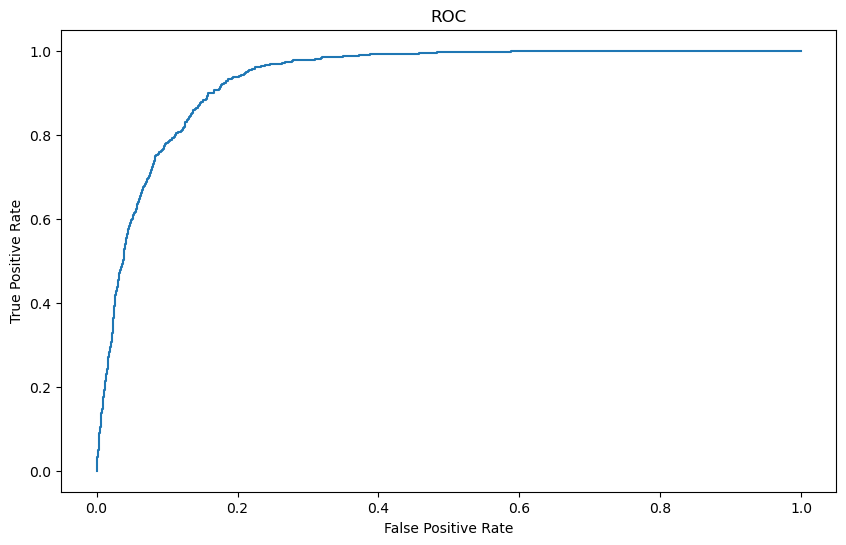

Area Under Curve:  0.9334307140690444


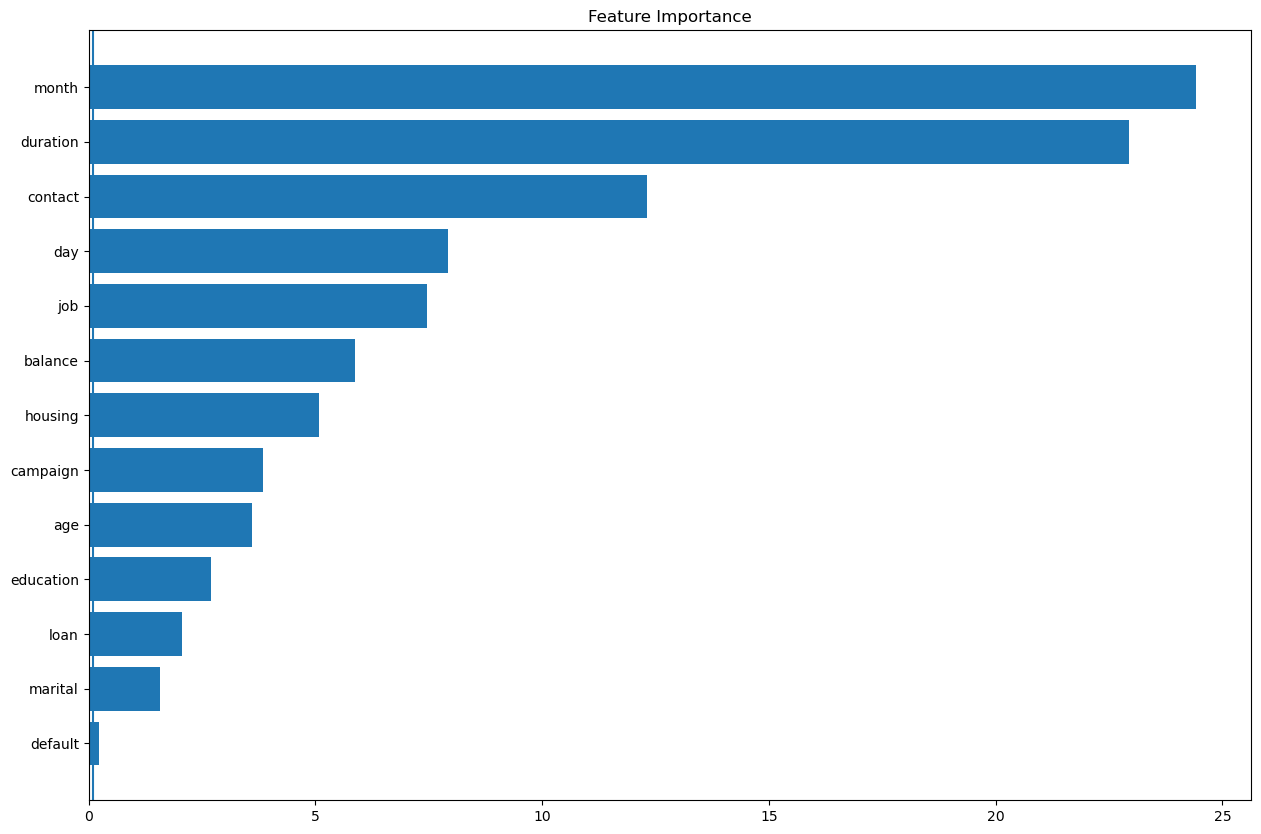

In [153]:
sm_cb = CatBoostClassifier(random_state=10)
sm_cb.fit(X_train_sm, y_train_sm)
y_pred = sm_cb.predict(X_test)
training_score = sm_cb.fit(X_train_sm, y_train_sm).score(X_train_sm, y_train_sm)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = sm_cb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = sm_cb.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], sm_cb.feature_importances_[sorted_importances])
_ = plt.axvline(x=0.10)
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

## LightGBM

Accuracy Score:  0.91375
Training Set Score:  0.9482404098968517
Macro F1 Score:  0.7425063757660436
Weighted F1 Score:  0.9229893862247629


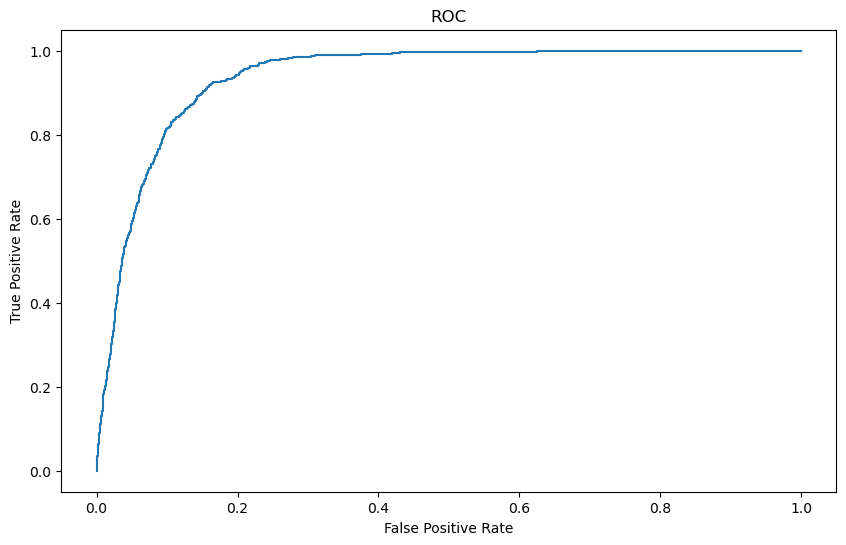

Area Under Curve:  0.9372982730788038


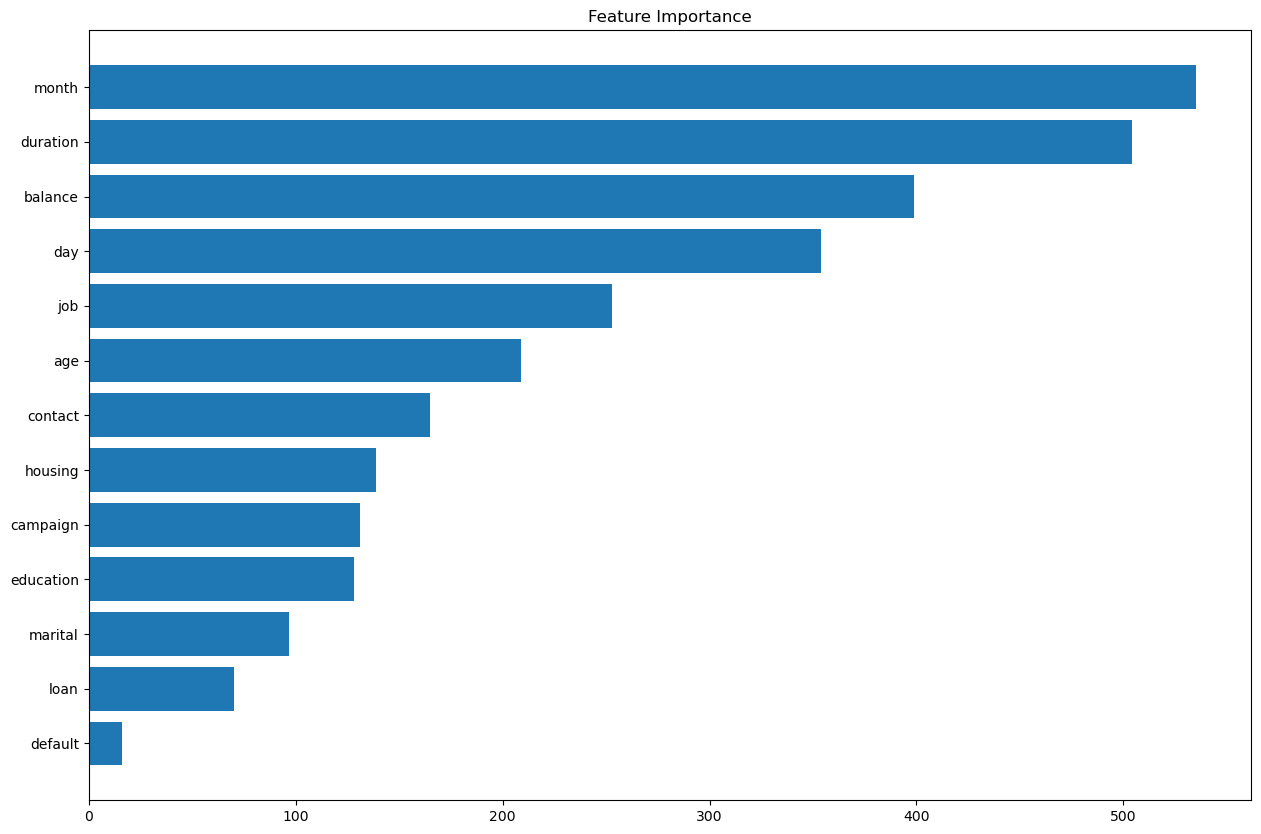

In [154]:
sm_lgbm = LGBMClassifier(random_state=10)
sm_lgbm.fit(X_train_sm, y_train_sm)
y_pred = sm_lgbm.predict(X_test)
training_score = sm_lgbm.fit(X_train_sm, y_train_sm).score(X_train_sm, y_train_sm)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
y_pred_prob = sm_lgbm.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = sm_lgbm.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], sm_lgbm.feature_importances_[sorted_importances])
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid.png', bbox_inches='tight')
plt.show()

### Hyperparameter Tuning of Best Model
The Random Forest Classifier is the best performing model as it has the highest area under the curve and the highest weighted F1 score. 


In [155]:
param_grid = {'n_estimators':np.arange(1,50), 
              'max_depth': np.arange(1,10),
             'criterion': ['gini', 'entropy']}
grid_rfc = GridSearchCV(RandomForestClassifier(random_state = 10), param_grid, cv=5, scoring = 'accuracy')
grid_rfc.fit(X_train, y_train)
print('Mean Cross Validation Score:' ,grid_rfc.best_score_)
print('Parameters with Highest Cross Validation Score: ',grid_rfc.best_params_)
print("Random Forest Classifier Model's Best Accuracy: ", grid_rfc.score(X_test,y_test))

Mean Cross Validation Score: 0.933
Parameters with Highest Cross Validation Score:  {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 26}
Random Forest Classifier Model's Best Accuracy:  0.932125


Accuracy Score:  0.92425
Training Set Score:  1.0
Macro F1 Score:  0.7473732129312398
Weighted F1 Score:  0.929059019307815


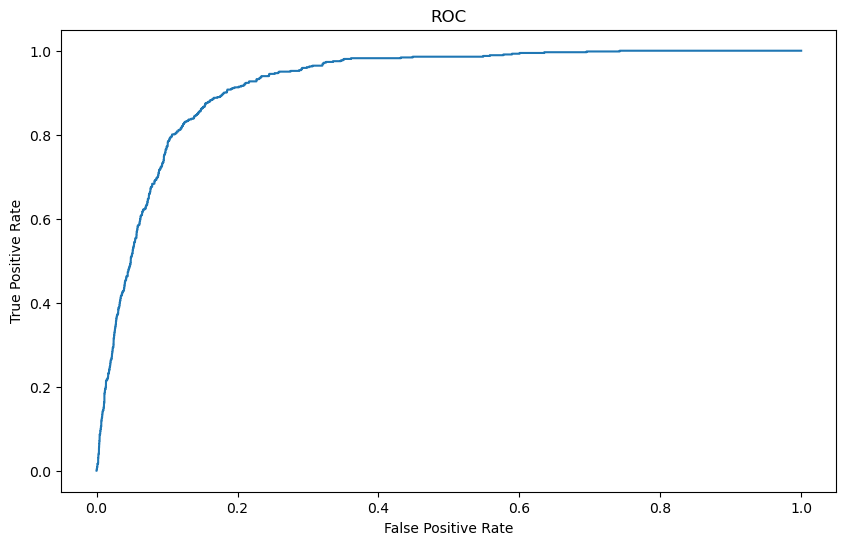

Area Under Curve:  0.9218701407315899


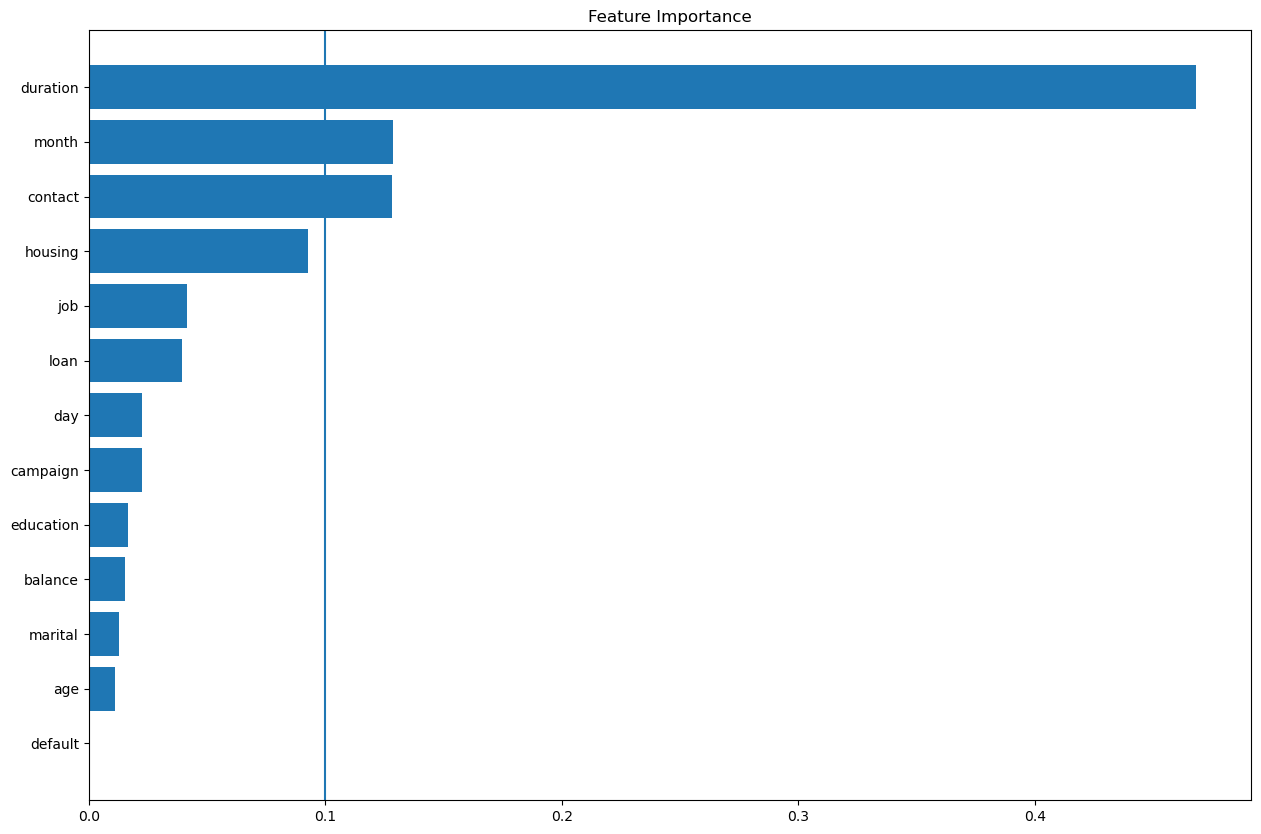

In [156]:
sm_rfc = RandomForestClassifier(random_state=10, criterion = 'gini', max_depth = 9, n_estimators = 34)
sm_rfc.fit(X_train_sm, y_train_sm)
y_pred = base_rfc.predict(X_test)
training_score = base_rfc.fit(X_train_sm, y_train_sm).score(X_train_sm, y_train_sm)
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Training Set Score: ', training_score)
print('Macro F1 Score: ', f1_score(y_test, y_pred, average = 'macro'))
print('Weighted F1 Score: ', f1_score(y_test, y_pred, average = 'weighted'))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
y_pred_prob = sm_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.savefig('roc_best_random.png', bbox_inches = 'tight')
plt.show()
print('Area Under Curve: ',auc)
sorted_importances = sm_rfc.feature_importances_.argsort()
_ = plt.figure(figsize=(15,10))
_ = plt.barh(X.columns[sorted_importances], sm_rfc.feature_importances_[sorted_importances])
_ = plt.axvline(x=0.10)
_ = plt.title('Feature Importance')
_ = plt.savefig('feature_imp_grid_best.png', bbox_inches='tight')
plt.show()

<AxesSubplot:>

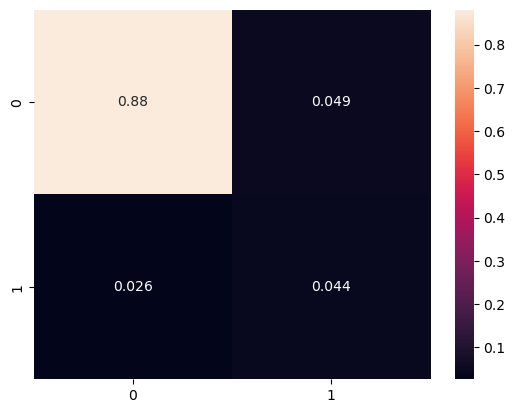

In [157]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True)

# Customer Segmentation

## KMeans Clustering

In [158]:
data.head()
features = data.drop('y', axis = 1)
target = data['y']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 10)

In [159]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

In [160]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
silhouette_avg = []
inertia = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state = 10, init = 'k-means++')
    kmeans.fit(scaled_X_train)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(scaled_X_train, cluster_labels))
    inertia.append(kmeans.inertia_)

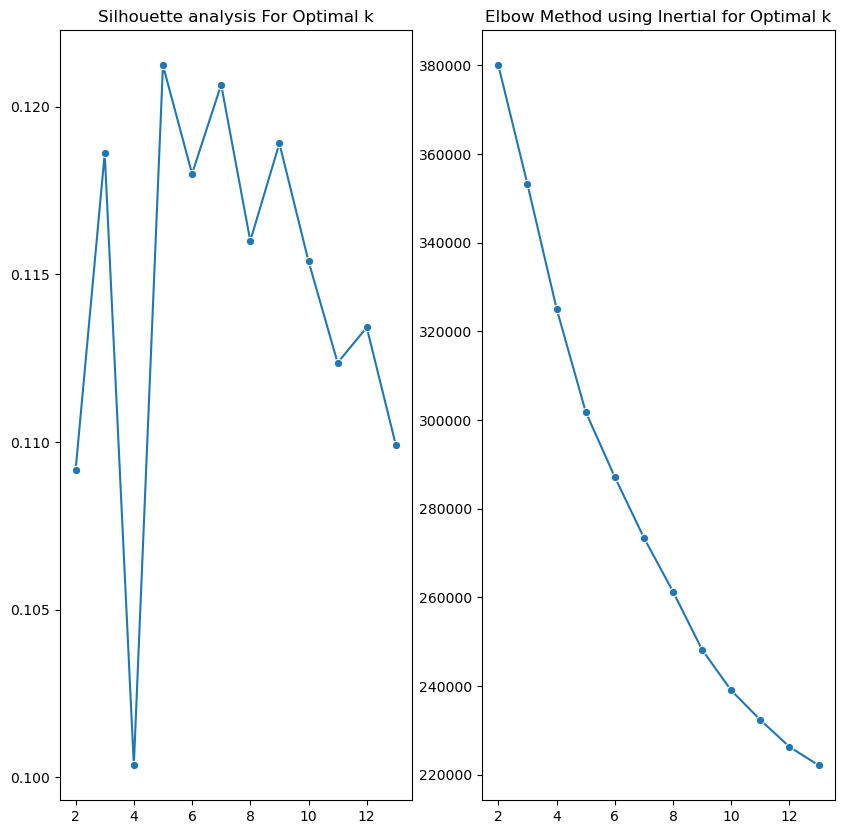

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
sns.lineplot(x=range_n_clusters,y=silhouette_avg, ax = axes[0], marker = 'o')
axes[0].set_title('Silhouette analysis For Optimal k')
sns.lineplot(x= range_n_clusters, y = inertia, ax= axes[1], marker = 'o')
axes[1].set_title('Elbow Method using Inertial for Optimal k')
plt.show();

In [162]:
kmeans2 = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
kmeans2.fit(scaled_X_train)
scaled_X_train_2 = pd.DataFrame(scaled_X_train)
scaled_X_train_2.columns = X_train.columns
scaled_X_train_2['Segment KMeans'] = kmeans2.labels_
scaled_X_train_2['y_true'] = y_train.values

In [163]:
scaled_X_train_2['Segment KMeans'].value_counts()/len(scaled_X_train)*100

1    60.390625
0    39.609375
Name: Segment KMeans, dtype: float64

In [164]:
scaled_X_train_2['y_true'].value_counts()/len(scaled_X_train)*100

0    92.70625
1     7.29375
Name: y_true, dtype: float64

In [165]:
accuracy_score(scaled_X_train_2['y_true'], scaled_X_train_2['Segment KMeans'])

0.40978125

<AxesSubplot:xlabel='y_true', ylabel='count'>

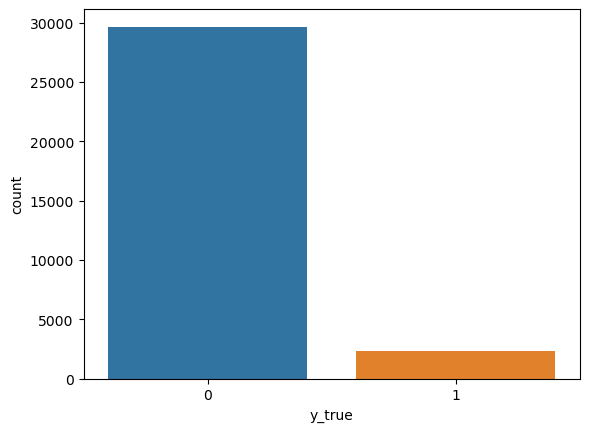

In [166]:
fig, ax
sns.countplot(x = 'y_true', data = scaled_X_train_2)

In [167]:
scaled_X_train_2.head(2)

age       job   marital  education   default   balance   housing  \
0 -0.055182 -0.383516 -0.257935  -1.621047 -0.143879 -0.327491 -1.226261   
1  0.360136 -0.383516 -0.257935  -1.621047 -0.143879 -0.425036 -1.226261   

       loan   contact       day     month  duration  campaign  Segment KMeans  \
0 -0.454723  1.414203  0.119386 -0.002837 -0.444611 -0.271513               1   
1 -0.454723 -0.755184  0.724215  0.865868  0.169030 -0.583709               0   

   y_true  
0       0  
1       0

In [168]:
kmeans2_results = pd.DataFrame(y_test)
kmeans2_results['y_pred'] = kmeans2.predict(X_test)

C:\Users\ibane\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but KMeans was fitted without feature names



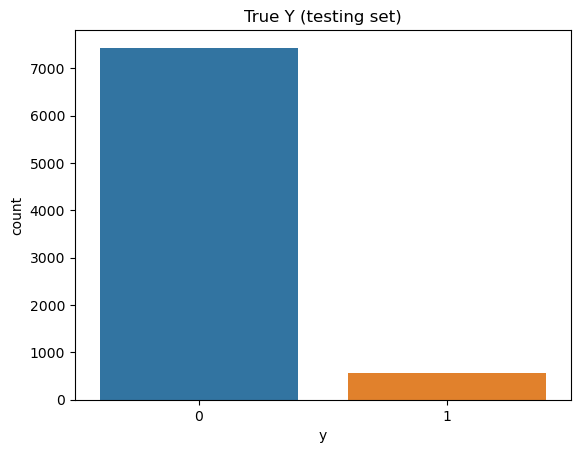

In [169]:
sns.countplot(x = kmeans2_results['y'])
plt.title('True Y (testing set)')
plt.show();

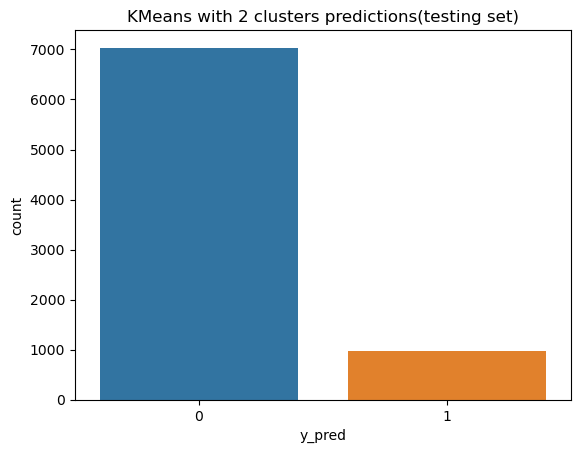

In [170]:
sns.countplot(x = kmeans2_results['y_pred'])
plt.title('KMeans with 2 clusters predictions(testing set)')
plt.show();

### 4 Clusters

In [171]:
kmeans4 = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans4.fit(scaled_X_train)
scaled_X_train4 = pd.DataFrame(scaled_X_train)
scaled_X_train4.columns = X_train.columns
scaled_X_train4['Segment KMeans'] = kmeans4.labels_
scaled_X_train4['y_true'] = y_train.values

In [172]:
scaled_X_train4['Segment KMeans'].value_counts()/len(scaled_X_train)*100

2    36.831250
1    31.071875
0    30.068750
3     2.028125
Name: Segment KMeans, dtype: float64

In [173]:
scaled_X_train4['y_true'].value_counts()/len(scaled_X_train)*100

0    92.70625
1     7.29375
Name: y_true, dtype: float64

In [174]:
accuracy_score(scaled_X_train4['y_true'], scaled_X_train4['Segment KMeans'])

0.314625

In [175]:
scaled_X_train4.head()

age       job   marital  education   default   balance   housing  \
0 -0.055182 -0.383516 -0.257935  -1.621047 -0.143879 -0.327491 -1.226261   
1  0.360136 -0.383516 -0.257935  -1.621047 -0.143879 -0.425036 -1.226261   
2 -0.470500 -0.079530  1.398812   1.081965 -0.143879 -0.087619  0.815487   
3 -0.781988 -0.991486 -0.257935  -1.621047 -0.143879 -0.557990  0.815487   
4  0.983112  1.440397 -0.257935  -0.269541 -0.143879 -0.047004  0.815487   

       loan   contact       day     month  duration  campaign  Segment KMeans  \
0 -0.454723  1.414203  0.119386 -0.002837 -0.444611 -0.271513               2   
1 -0.454723 -0.755184  0.724215  0.865868  0.169030 -0.583709               0   
2 -0.454723 -0.755184 -0.727376  0.431515 -0.556533 -0.583709               1   
3 -0.454723  1.414203  1.450011 -0.437189  1.052828 -0.271513               2   
4 -0.454723 -0.755184  0.845181  0.431515 -0.525658 -0.271513               0   

   y_true  
0       0  
1       0  
2       0  
3       0  
4       0

## PCA and Kmeans Clustering Analysis

In [176]:
data.head()

age  job  marital  education  default  balance  housing  loan  contact  \
32971   47    1        0          1        0     3823        1     1        0   
1820    47    1        1          0        0       94        1     0        2   
16869   38    2        1          0        0       21        1     0        0   
31489   58    4        0          2        0      315        1     0        0   
21295   60    1        1          1        0     5450        0     0        0   

       day  month  duration  campaign  y  
32971   17      4       647         2  0  
1820     9      5       209         3  0  
16869   25      7        65         4  0  
31489    1      4       121         2  0  
21295   18      8       113         4  0

In [177]:
features = data.drop('y', axis = 1)
target = data['y']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 10)

In [178]:
X_train

age  job  marital  education  default  balance  housing  loan  contact  \
10983   40    3        1          0        0      322        0     0        2   
22626   44    3        1          0        0       41        0     0        0   
13868   36    4        2          2        0     1013        1     0        0   
6985    33    1        1          0        0     -342        1     0        2   
16431   50    9        1          1        0     1130        1     0        0   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
39609   26    8        2          1        0      100        0     0        0   
3364    53    4        1          2        0     4928        1     0        2   
39835   40    1        1          1        0     1451        0     0        0   
15222   31    4        0          2        0      294        1     0        0   
25355   33    9        0          1        1       10        1     1        0   

       day  month  duration  campaign  
10983   17      6       140         2  
22626   22      8       299         1  
13868   10      7       111         1  
6985    28      5       528         2  
16431   23      7       119         2  
...    ...    ...       ...       ...  
39609   26      5       445         1  
3364    15      5       738         7  
39835    1      6       314         1  
15222   17      7       536         5  
25355   18     11       167         5  

[32000 rows x 13 columns]

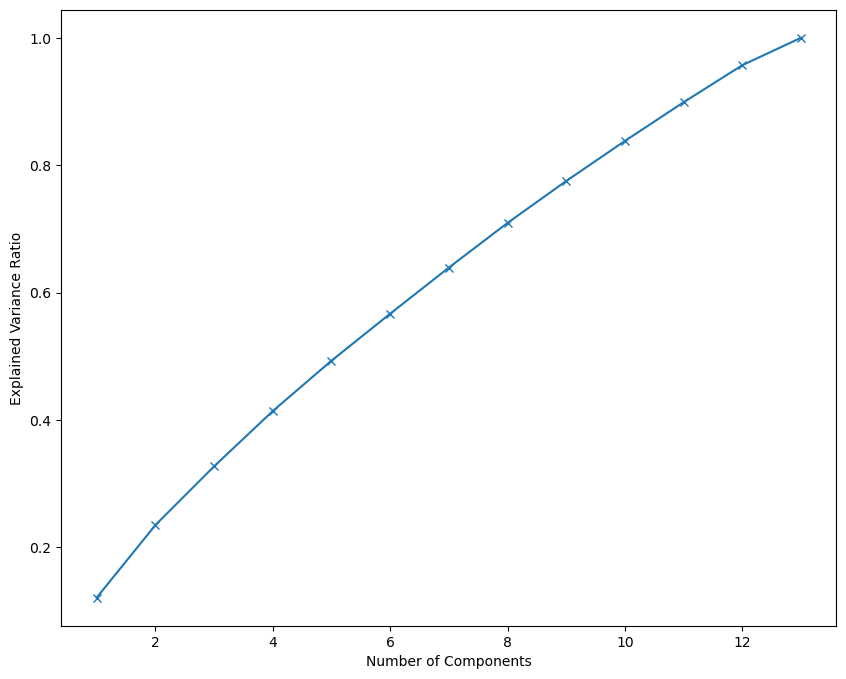

In [179]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
pca = PCA()
pca.fit(scaled_X_train)
plt.figure(figsize=(10,8))
plt.plot(range(1,14), pca.explained_variance_ratio_.cumsum(), marker = 'x')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show();

Not abundantly clear how many clusters we should go with. I know from the feature importances extracted that we are looking for around 3 or 4 clusters. 

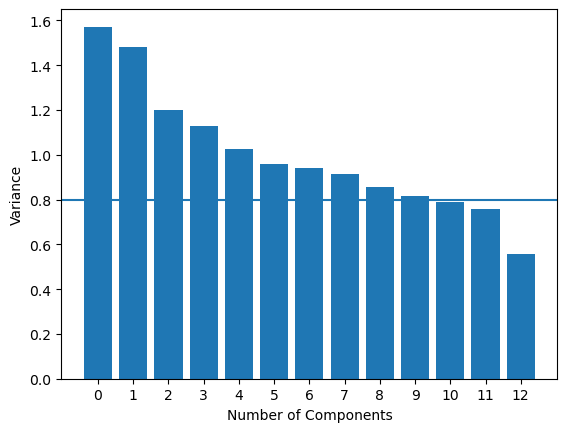

In [180]:
features_pca = range(pca.n_components_)
plt.bar(features_pca, pca.explained_variance_)
plt.xticks(features_pca)
plt.ylabel('Variance')
plt.xlabel('Number of Components')
plt.axhline(0.8)
plt.show()

Will keep at least 80% variance. 

### PCA with 2 components

(32000, 13)
(32000, 2)


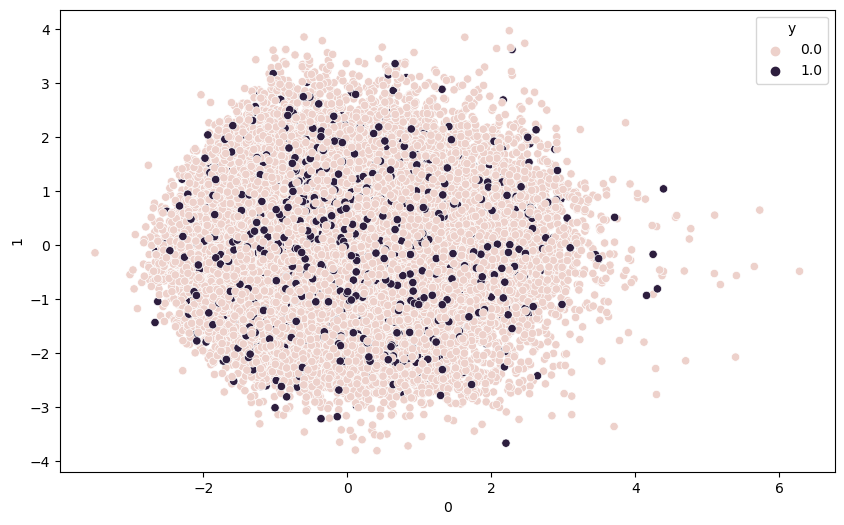

In [181]:
pca2 = PCA(n_components = 2)
pca2.fit(scaled_X_train)
transformed2 = pca2.transform(scaled_X_train)
print(scaled_X_train.shape)
print(transformed2.shape)
trans_df2 = pd.DataFrame(transformed2)
plt.figure(figsize=(10,6))
sns.scatterplot(x= trans_df2[0], y= trans_df2[1], hue = y_train)
plt.show()

(32000, 13)
(32000, 3)


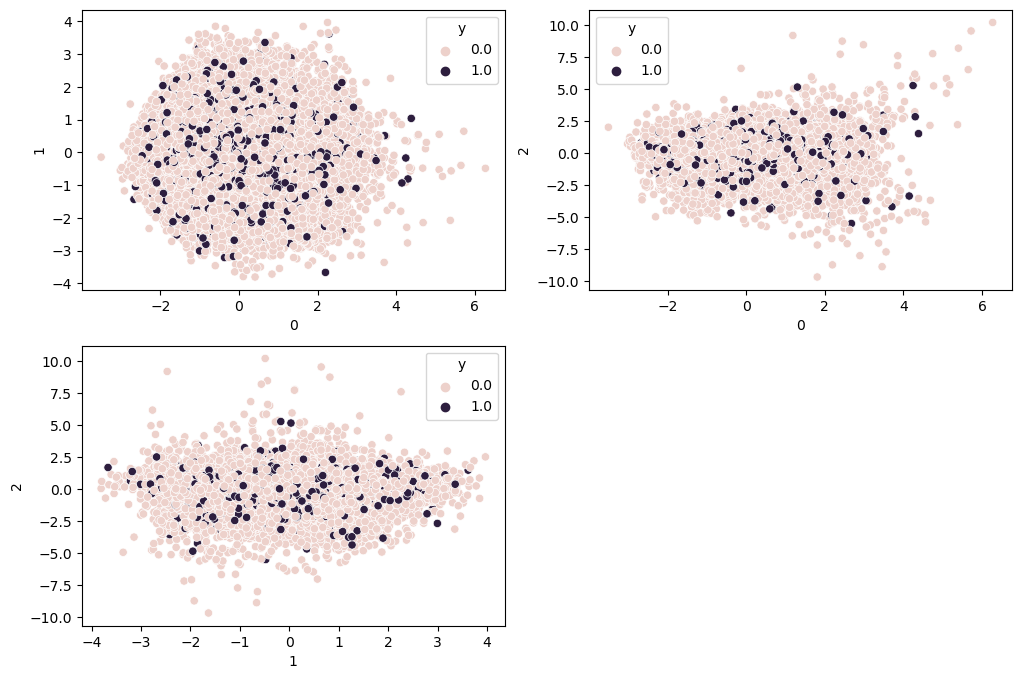

In [182]:
pca3 = PCA(n_components = 3)
pca3.fit(scaled_X_train)
transformed3 = pca3.transform(scaled_X_train)
print(scaled_X_train.shape)
print(transformed3.shape)
trans_df3 = pd.DataFrame(transformed3)
fig, axes = plt.subplots(nrows=2,ncols=2, figsize = (12, 8))
sns.scatterplot(x= trans_df3[0], y= trans_df3[1], hue = y_train, ax = axes[0,0])
sns.scatterplot(x= trans_df3[0], y= trans_df3[2], hue = y_train, ax = axes[0,1])
sns.scatterplot(x= trans_df3[1], y= trans_df3[2], hue = y_train, ax = axes[1,0])
axes[-1,-1].axis('off')
plt.show();

### PCA with 4 components

(32000, 13)
(32000, 4)


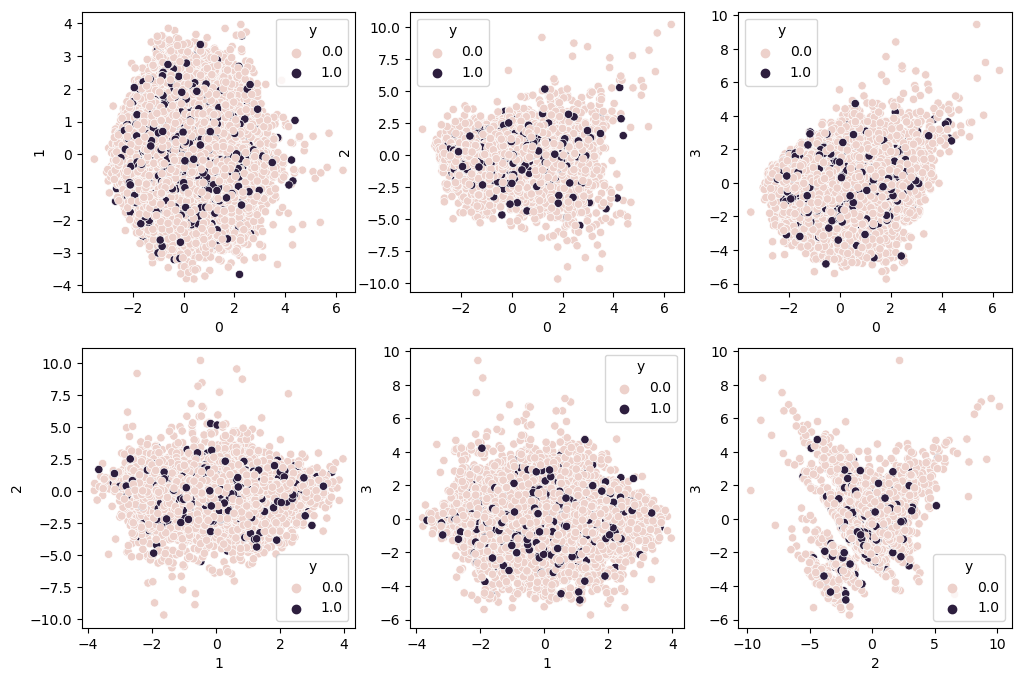

In [183]:
pca4 = PCA(n_components = 4)
pca4.fit(scaled_X_train)
transformed4 = pca4.transform(scaled_X_train)
print(scaled_X_train.shape)
print(transformed4.shape)
trans_df4 = pd.DataFrame(transformed4)
fig, axes = plt.subplots(nrows=2,ncols=3, figsize = (12, 8))
sns.scatterplot(x= trans_df4[0], y= trans_df4[1], hue = y_train, ax = axes[0,0])
sns.scatterplot(x= trans_df4[0], y= trans_df4[2], hue = y_train, ax = axes[0,1])
sns.scatterplot(x= trans_df4[0], y= trans_df4[3], hue = y_train, ax = axes[0,2])
sns.scatterplot(x= trans_df4[1], y= trans_df4[2], hue = y_train, ax = axes[1,0])
sns.scatterplot(x= trans_df4[1], y= trans_df4[3], hue = y_train, ax = axes[1,1])
sns.scatterplot(x= trans_df4[2], y= trans_df4[3], hue = y_train, ax = axes[1,2])
plt.show();

### PCA with 8 components

(32000, 13)
(32000, 8)


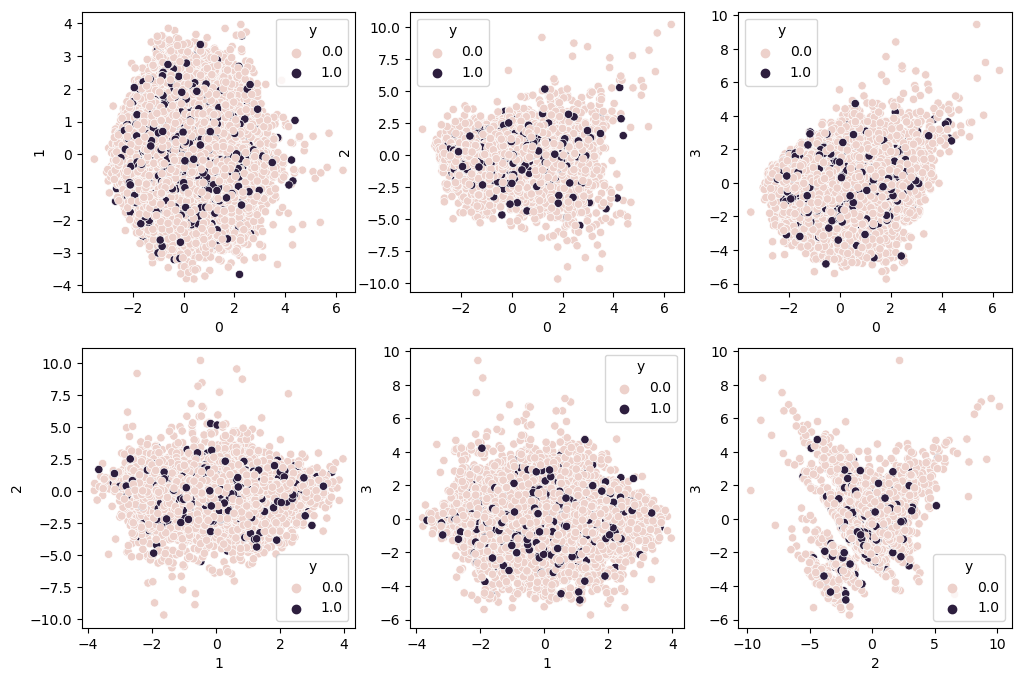

In [184]:
pca8 = PCA(n_components = 8)
pca8.fit(scaled_X_train)
transformed8 = pca8.transform(scaled_X_train)
print(scaled_X_train.shape)
print(transformed8.shape)
trans_df8 = pd.DataFrame(transformed8)
fig, axes = plt.subplots(nrows=2,ncols=3, figsize = (12, 8))
sns.scatterplot(x= trans_df8[0], y= trans_df8[1], hue = y_train, ax = axes[0,0])
sns.scatterplot(x= trans_df8[0], y= trans_df8[2], hue = y_train, ax = axes[0,1])
sns.scatterplot(x= trans_df8[0], y= trans_df8[3], hue = y_train, ax = axes[0,2])
sns.scatterplot(x= trans_df8[1], y= trans_df8[2], hue = y_train, ax = axes[1,0])
sns.scatterplot(x= trans_df8[1], y= trans_df8[3], hue = y_train, ax = axes[1,1])
sns.scatterplot(x= trans_df8[2], y= trans_df8[3], hue = y_train, ax = axes[1,2])
plt.show()

We don't see any further imporvements from 4 to 8 so I'll go ahead with 4 components

In [185]:
scores_pca = transformed4

In [186]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
silhouette_avg = []
inertia = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state = 10, init = 'k-means++')
    kmeans.fit(scores_pca)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(scores_pca, cluster_labels))
    inertia.append(kmeans.inertia_)

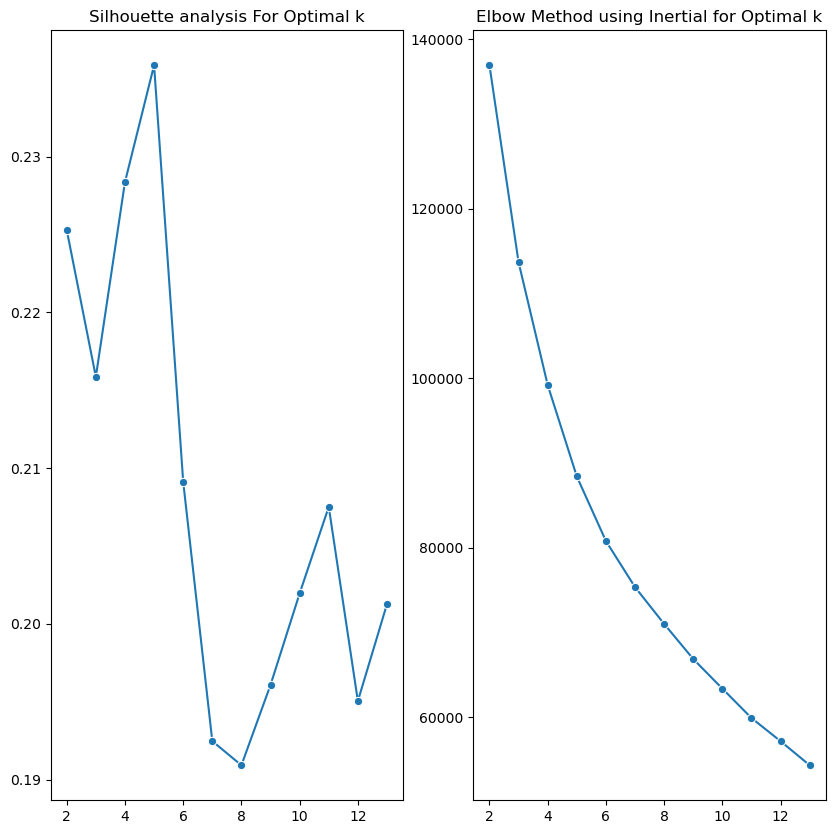

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
sns.lineplot(x=range_n_clusters,y=silhouette_avg, ax = axes[0], marker = 'o')
axes[0].set_title('Silhouette analysis For Optimal k')
sns.lineplot(x= range_n_clusters, y = inertia, ax= axes[1], marker= 'o')
axes[1].set_title('Elbow Method using Inertial for Optimal k')
plt.savefig('optimal_k.png', bbox_inches='tight')
plt.show();

In [188]:
kmeans_pca_4 = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_pca_4.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

In [189]:
scaled_X_train = pd.DataFrame(scaled_X_train)
scaled_X_train.columns = X_train.columns

In [190]:
kmeans_pca4_df = pd.concat([scaled_X_train.reset_index(drop=True), pd.DataFrame(scores_pca)], axis = 1)
kmeans_pca4_df.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']
kmeans_pca4_df['Segment K-means PCA'] = kmeans_pca_4.labels_
kmeans_pca4_df['Segment'] = kmeans_pca4_df['Segment K-means PCA'].map({0:'first', 1:'second', 2: 'third', 3: 'fourth'})
kmeans_pca4_df['Segment K-means PCA'].value_counts()

0    10327
2     9125
3     8529
1     4019
Name: Segment K-means PCA, dtype: int64

In [191]:
kmeans_pca4_df.head(2)

age       job   marital  education   default   balance   housing  \
0 -0.055182 -0.383516 -0.257935  -1.621047 -0.143879 -0.327491 -1.226261   
1  0.360136 -0.383516 -0.257935  -1.621047 -0.143879 -0.425036 -1.226261   

       loan   contact       day     month  duration  campaign  Component 1  \
0 -0.454723  1.414203  0.119386 -0.002837 -0.444611 -0.271513    -0.194294   
1 -0.454723 -0.755184  0.724215  0.865868  0.169030 -0.583709     1.047043   

   Component 2  Component 3  Component 4  Segment K-means PCA Segment  
0     1.223258    -0.210821     0.535018                    0   first  
1     0.689396    -0.134173    -0.336719                    3  fourth

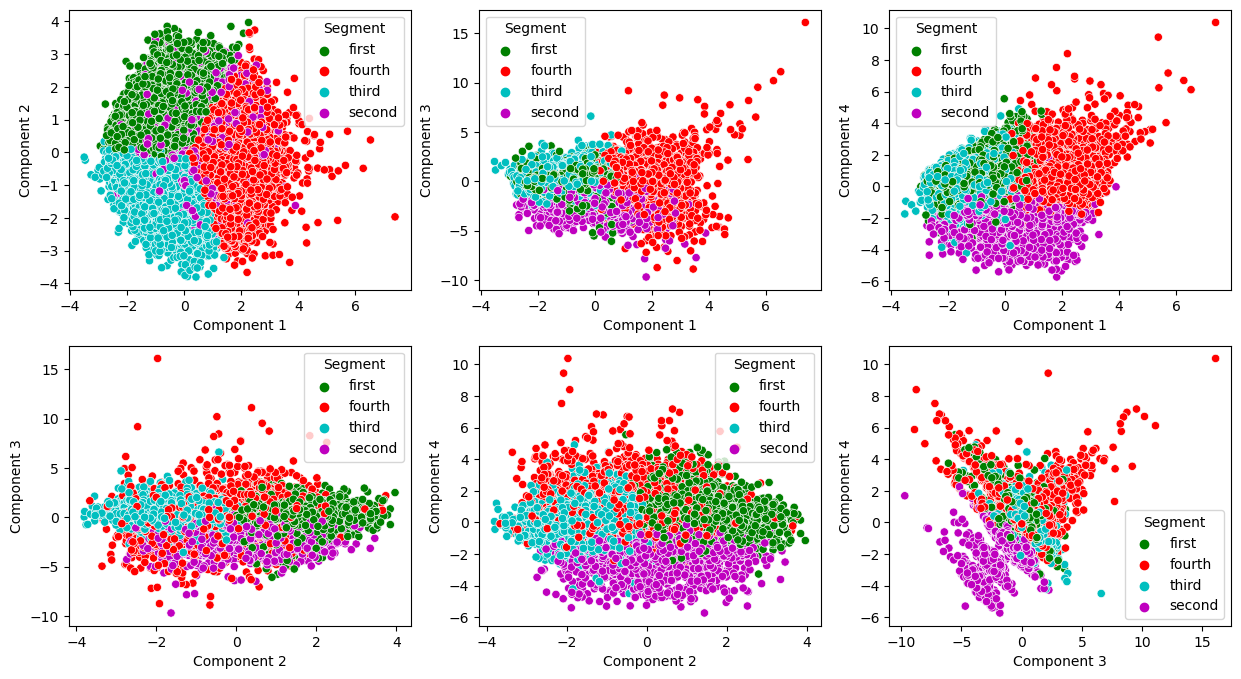

In [192]:
fig, axes = plt.subplots(nrows= 2, ncols = 3, figsize = (15,8))
sns.scatterplot(ax = axes[0,0] ,x ='Component 1', y ='Component 2', data = kmeans_pca4_df, hue = kmeans_pca4_df['Segment'], palette = ['g','r','c', 'm'])
sns.scatterplot(ax = axes[0,1] ,x ='Component 1', y ='Component 3', data = kmeans_pca4_df, hue = kmeans_pca4_df['Segment'], palette = ['g','r','c', 'm'])
sns.scatterplot(ax = axes[0,2] ,x ='Component 1', y ='Component 4', data = kmeans_pca4_df, hue = kmeans_pca4_df['Segment'], palette = ['g','r','c', 'm'])
sns.scatterplot(ax = axes[1,0] ,x ='Component 2', y ='Component 3', data = kmeans_pca4_df, hue = kmeans_pca4_df['Segment'], palette = ['g','r','c', 'm'])
sns.scatterplot(ax = axes[1,1] ,x ='Component 2', y ='Component 4', data = kmeans_pca4_df, hue = kmeans_pca4_df['Segment'], palette = ['g','r','c', 'm'])
sns.scatterplot(ax = axes[1,2] ,x ='Component 3', y ='Component 4', data = kmeans_pca4_df, hue = kmeans_pca4_df['Segment'], palette = ['g','r','c', 'm'])
plt.show();

reference: https://365datascience.com/tutorials/python-tutorials/pca-k-means/

In [193]:
features_kmeans = X_train.assign(segment = kmeans_pca_4.labels_).groupby(['segment']).mean().round()
features_kmeans

age  job  marital  education  default  balance  housing  loan  \
segment                                                                   
0        44.0  3.0      1.0        1.0      0.0   1003.0      1.0   0.0   
1        41.0  4.0      1.0        1.0      0.0    336.0      1.0   1.0   
2        33.0  5.0      2.0        1.0      0.0   1031.0      1.0   0.0   
3        45.0  5.0      1.0        1.0      0.0   2272.0      0.0   0.0   

         contact   day  month  duration  campaign  
segment                                            
0            1.0  14.0    5.0     246.0       3.0  
1            0.0  16.0    7.0     255.0       3.0  
2            1.0  15.0    5.0     296.0       2.0  
3            0.0  19.0    8.0     223.0       4.0

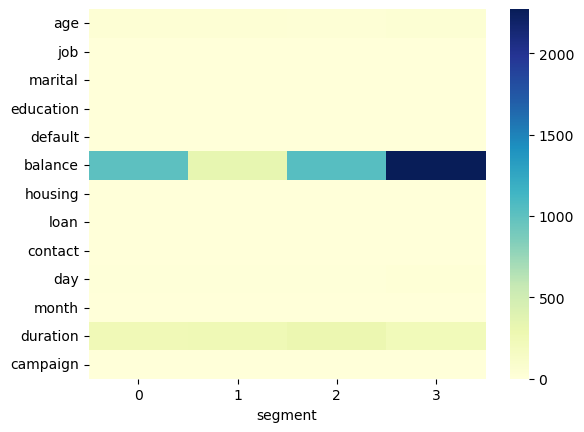

In [194]:
sns.heatmap(features_kmeans.T, cmap = 'YlGnBu')
plt.show();

Checking with 3 clusters

In [195]:
kmeans_pca_3 = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
kmeans_pca_3.fit(scores_pca)
scaled_X_train = pd.DataFrame(scaled_X_train)
scaled_X_train.columns = X_train.columns

In [196]:
kmeans_pca3_df = pd.concat([scaled_X_train.reset_index(drop=True), pd.DataFrame(scores_pca)], axis = 1)
kmeans_pca3_df.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
kmeans_pca3_df['Segment K-means PCA'] = kmeans_pca_3.labels_
kmeans_pca3_df['Segment'] = kmeans_pca3_df['Segment K-means PCA'].map({0:'first', 1:'second', 2: 'third'})
kmeans_pca3_df['Segment K-means PCA'].value_counts()

0    11677
2    10287
1    10036
Name: Segment K-means PCA, dtype: int64

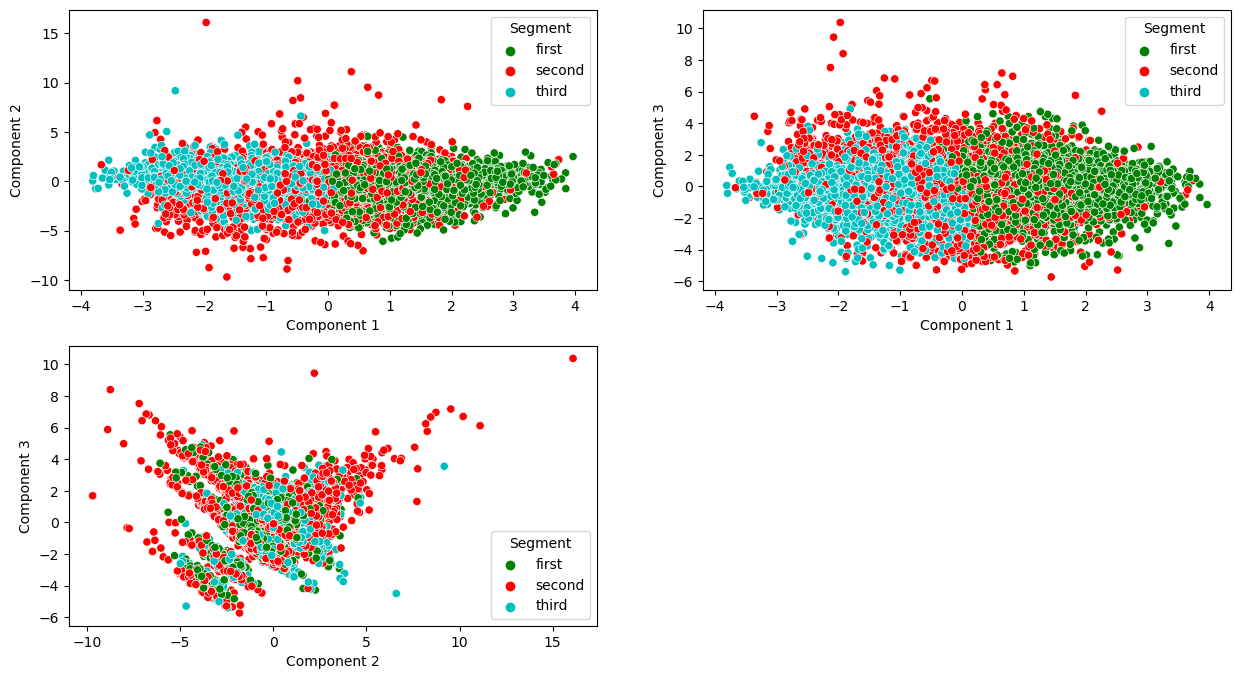

In [197]:
fig, axes = plt.subplots(nrows= 2, ncols = 2, figsize = (15,8))
sns.scatterplot(ax = axes[0,0] ,x ='Component 1', y ='Component 2', data = kmeans_pca3_df, hue = kmeans_pca3_df['Segment'], palette = ['g','r','c'])
sns.scatterplot(ax = axes[0,1] ,x ='Component 1', y ='Component 3', data = kmeans_pca3_df, hue = kmeans_pca3_df['Segment'], palette = ['g','r','c'])
sns.scatterplot(ax = axes[1,0] ,x ='Component 2', y ='Component 3', data = kmeans_pca3_df, hue = kmeans_pca3_df['Segment'], palette = ['g','r','c'])
axes[-1,-1].axis('off')
plt.savefig('PCA_3.png', bbox_inches='tight')
plt.show();

K Means with 5 clusters as it had the highest sihouette score

In [198]:
kmeans5 = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans5.fit(scores_pca)

KMeans(n_clusters=5, random_state=42)

In [199]:
scaled_X_train = pd.DataFrame(scaled_X_train)
scaled_X_train.columns = X_train.columns

In [200]:
kmeans_pca5_df = pd.concat([scaled_X_train.reset_index(drop=True), pd.DataFrame(scores_pca)], axis = 1)
kmeans_pca5_df.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']
kmeans_pca5_df['Segment K-means PCA'] = kmeans5.labels_
kmeans_pca5_df['Segment'] = kmeans_pca5_df['Segment K-means PCA'].map({0:'first', 1:'second', 2: 'third', 3: 'fourth', 4: 'fifth'})
kmeans_pca5_df['Segment K-means PCA'].value_counts()

0    9610
3    8749
1    7850
2    3883
4    1908
Name: Segment K-means PCA, dtype: int64

In [201]:
kmeans_pca5_df

age       job   marital  education   default   balance   housing  \
0     -0.055182 -0.383516 -0.257935  -1.621047 -0.143879 -0.327491 -1.226261   
1      0.360136 -0.383516 -0.257935  -1.621047 -0.143879 -0.425036 -1.226261   
2     -0.470500 -0.079530  1.398812   1.081965 -0.143879 -0.087619  0.815487   
3     -0.781988 -0.991486 -0.257935  -1.621047 -0.143879 -0.557990  0.815487   
4      0.983112  1.440397 -0.257935  -0.269541 -0.143879 -0.047004  0.815487   
...         ...       ...       ...        ...       ...       ...       ...   
31995 -1.508794  1.136411  1.398812  -0.269541 -0.143879 -0.404555 -1.226261   
31996  1.294601 -0.079530 -0.257935   1.081965 -0.143879  1.271424  0.815487   
31997 -0.055182 -0.991486 -0.257935  -0.269541 -0.143879  0.064427 -1.226261   
31998 -0.989647 -0.079530 -1.914682   1.081965 -0.143879 -0.337211  0.815487   
31999 -0.781988  1.440397 -1.914682  -0.269541  6.950297 -0.435798  0.815487   

           loan   contact       day     month  duration  campaign  \
0     -0.454723  1.414203  0.119386 -0.002837 -0.444611 -0.271513   
1     -0.454723 -0.755184  0.724215  0.865868  0.169030 -0.583709   
2     -0.454723 -0.755184 -0.727376  0.431515 -0.556533 -0.583709   
3     -0.454723  1.414203  1.450011 -0.437189  1.052828 -0.271513   
4     -0.454723 -0.755184  0.845181  0.431515 -0.525658 -0.271513   
...         ...       ...       ...       ...       ...       ...   
31995 -0.454723 -0.755184  1.208079 -0.437189  0.732500 -0.583709   
31996 -0.454723  1.414203 -0.122546 -0.437189  1.863297  1.289467   
31997 -0.454723 -0.755184 -1.816069 -0.002837  0.226921 -0.583709   
31998 -0.454723 -0.755184  0.119386  0.431515  1.083703  0.665075   
31999  2.199141 -0.755184  0.240352  2.168924 -0.340408  0.665075   

       Component 1  Component 2  Component 3  Component 4  \
0        -0.194294     1.223258    -0.210821     0.535018   
1         1.047043     0.689396    -0.134173    -0.336719   
2        -0.616771    -1.532186     0.505193    -0.114510   
3        -1.630812     1.037472    -0.877794     0.986499   
4         0.948754     0.029854     0.122101     0.215164   
...            ...          ...          ...          ...   
31995    -0.112285    -2.295591     0.005274    -0.308093   
31996    -0.019413     0.675817     1.038657     1.241770   
31997    -0.024315     0.435284     1.264824    -0.957901   
31998     0.306872    -0.175138     0.007182    -0.088559   
31999     1.569574     0.239102    -4.157942    -3.934070   

       Segment K-means PCA Segment  
0                        0   first  
1                        1  second  
2                        3  fourth  
3                        0   first  
4                        1  second  
...                    ...     ...  
31995                    3  fourth  
31996                    0   first  
31997                    1  second  
31998                    1  second  
31999                    2   third  

[32000 rows x 19 columns]

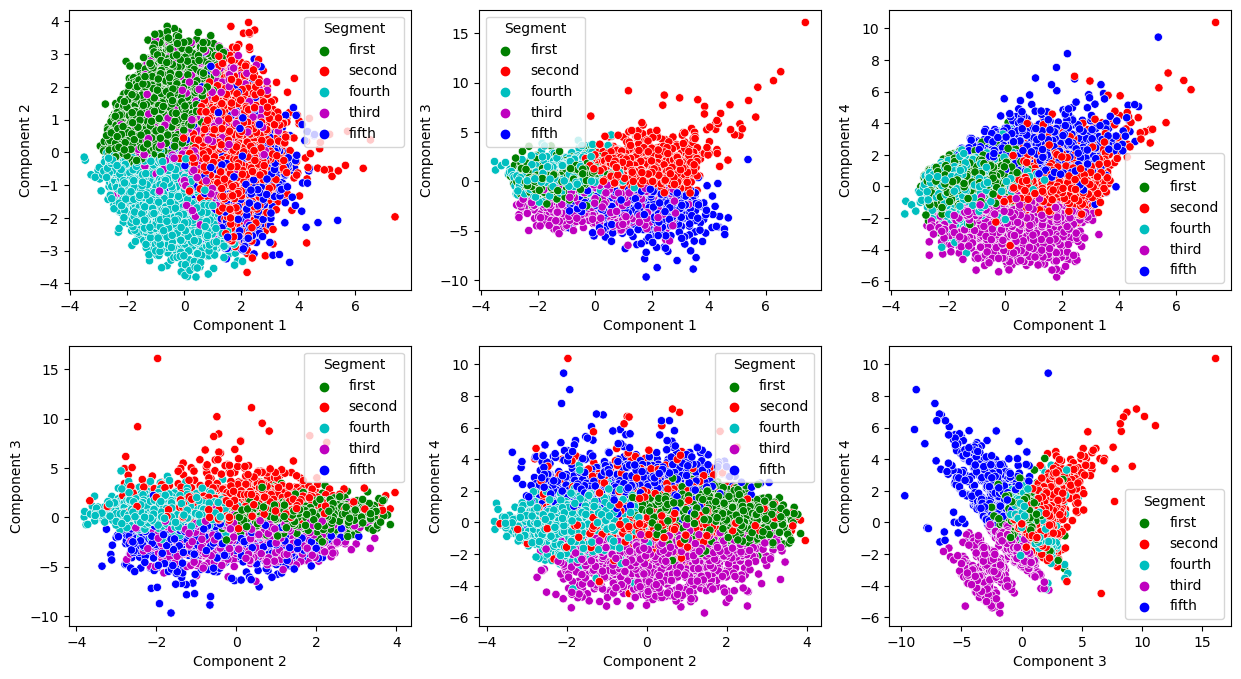

In [202]:
fig, axes = plt.subplots(nrows= 2, ncols = 3, figsize = (15,8))
sns.scatterplot(ax = axes[0,0] ,x ='Component 1', y ='Component 2', data = kmeans_pca5_df, hue = kmeans_pca5_df['Segment'], palette = ['g','r','c', 'm', 'b'])
sns.scatterplot(ax = axes[0,1] ,x ='Component 1', y ='Component 3', data = kmeans_pca5_df, hue = kmeans_pca5_df['Segment'], palette = ['g','r','c', 'm', 'b'])
sns.scatterplot(ax = axes[0,2] ,x ='Component 1', y ='Component 4', data = kmeans_pca5_df, hue = kmeans_pca5_df['Segment'], palette = ['g','r','c', 'm', 'b'])
sns.scatterplot(ax = axes[1,0] ,x ='Component 2', y ='Component 3', data = kmeans_pca5_df, hue = kmeans_pca5_df['Segment'], palette = ['g','r','c', 'm', 'b'])
sns.scatterplot(ax = axes[1,1] ,x ='Component 2', y ='Component 4', data = kmeans_pca5_df, hue = kmeans_pca5_df['Segment'], palette = ['g','r','c', 'm', 'b'])
sns.scatterplot(ax = axes[1,2] ,x ='Component 3', y ='Component 4', data = kmeans_pca5_df, hue = kmeans_pca5_df['Segment'], palette = ['g','r','c', 'm', 'b'])
plt.savefig('PCA_4.png', bbox_inches='tight')
plt.show();

# Conclusion
The best performing model here is a Random Forest Classifier which yield an accuracy score 92% after SMOTE analysis was conducted to account for the imbalance in the dataset. It is important to note that whilst the success metrics outlined in aims of the project is accuracy, the weighted f1 score was prioritised due to the imbalance in the dataset. For this model, the weighted f1 score is 92% as well. 
The Random Forest Classifier, along side other classification algorigthms highlighted the month of last contact, the duration of the last contact, the means of last contact, and the balance as important features in the dataset for the classifcation. This was in line with the results of KMeans clustering with PCA. 3 to 4 clusters look visible. To gain a better idea of the problem, it's worth looking into how many clients signed up for subscriptions who then tried to withdraw their deposits before the maturity time. This alongisde the duration of the contacts can help gain a better understanding of the relationship duration and subscription. Otherwise, it does look like the longer a customer is spoken with the higher the chance of them subscribing for term deposits. October and March have the highest subscription rates and therefore is worth driving more attention to these two months through telephone/cellphone contact. 


pick two or three and do 2D plots; 